In [1]:
import sqlalchemy
import sqlite3, csv, os
from sqlalchemy import (Boolean, Column, Enum, ForeignKey, Integer, String,PickleType,MetaData,
                        Float,Table, UniqueConstraint, create_engine)
from sqlalchemy import (not_, select,and_) 
from datetime import datetime
from sqlalchemy import *
from sqlalchemy.dialects.postgresql import ARRAY
#from sklearn import datasets
#from sklearn import *
import sklearn
# from sklearn.model_selection import train_test_split
from numpy import genfromtxt
import numpy as np
import time
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
#from sklearn import model_selection
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# from unsupervised_alt import *
from scipy import io
import scipy

In [4]:
data_path = "/home/lun5/Documents/multiplex/data/"
input_path = "/home/lun5/Documents/multiplex/input/"
data_fname = 'Filtered.QCed.NoTcorr.SegExclude.HighDAPI.log2.Median.Norm.Cells.csv'
f = open(os.path.join(input_path,data_fname),'rb')
f_csv = csv.DictReader(f)
print f_csv.fieldnames

start_time = time.time()
biomarkers = np.load(os.path.join(data_path,'biomarkers.npy'))
print('----Load pickle takes %s seconds - so much faster----' %(time.time() - start_time))
print 'shape of biomarkers is', biomarkers.shape

fields = f_csv.fieldnames[3:15] + f_csv.fieldnames[16:]
print len(fields)
cyt_bio_indx = ['.Cyt.' in fields[i] for i in xrange(len(fields))]
print 'there are ', sum(cyt_bio_indx), ' cytoplasm biomarkers'

memb_bio_indx = ['.Memb.' in fields[i] for i in xrange(len(fields))]
print 'there are ', sum(memb_bio_indx), 'membrane biomarkers'

nuc_bio_indx = ['.Nuc.' in fields[i] for i in xrange(len(fields))]
print 'there are ', sum(nuc_bio_indx), 'nuclear biomarkers'

print np.nonzero(['Number.of.Nuclei' in fields[i] for i in xrange(len(fields))])[0][0]
print biomarkers.shape
print np.sum(biomarkers[:,7] == 1)
split_name = [str.split(fields[i],'.')[-1] for i in xrange(len(fields))]
nuc_bio_indx = np.nonzero(np.array(nuc_bio_indx))[0]
print nuc_bio_indx
print len(split_name)
nuc_biomarkers_names = [split_name[nuc_bio_indx[i]] for i in xrange(len(nuc_bio_indx))]
print len(nuc_biomarkers_names)
print sorted(nuc_biomarkers_names, key=str.lower)

['slide_name', 'POSITION', 'ID', 'CellCentroid.X', 'CellCentroid.Y', 'Epithelium.Stroma', 'Perimeter', 'Eccentricity', 'MajorAxisLength', 'MinorAxisLength', 'Number.of.Nuclei', 'Area.Cell', 'Area.Nuclei', 'Area.Memb', 'Area.Cyt', 'SS', 'Median.Cell.pERK', 'Median.Cell.CD31', 'Median.Cell.BetaCatenin', 'Median.Cell.S6', 'Median.Cell.pS6235', 'Median.Cell.Fibronectin', 'Median.Cell.beta_actin', 'Median.Cell.pck26', 'Median.Cell.Glut1', 'Median.Cell.NaKATPase', 'Median.Cell.SMA', 'Median.Cell.Albumin', 'Median.Cell.CK19', 'Median.Cell.EGFR', 'Median.Cell.p4EBP1', 'Median.Cell.Wnt5', 'Median.Cell.pNDRG1', 'Median.Cell.FOXO3a', 'Median.Cell.MLH1', 'Median.Cell.E_cad', 'Median.Cell.pGSK3a', 'Median.Cell.LaminA_C', 'Median.Cell.pGSK3beta', 'Median.Cell.EZH2', 'Median.Cell.ALDH1', 'Median.Cell.p21', 'Median.Cell.Claudin1', 'Median.Cell.CD20', 'Median.Cell.IHH', 'Median.Cell.pEGFR', 'Median.Cell.NDRG1', 'Median.Cell.CD68', 'Median.Cell.TKLP1', 'Median.Cell.CD8', 'Median.Cell.CD79', 'Median.Cell

In [11]:
print fields[:12]

['CellCentroid.X', 'CellCentroid.Y', 'Epithelium.Stroma', 'Perimeter', 'Eccentricity', 'MajorAxisLength', 'MinorAxisLength', 'Number.of.Nuclei', 'Area.Cell', 'Area.Nuclei', 'Area.Memb', 'Area.Cyt']


In [27]:
fields[180:]

['Median.Nuc.pERK',
 'Median.Nuc.CD31',
 'Median.Nuc.BetaCatenin',
 'Median.Nuc.S6',
 'Median.Nuc.pS6235',
 'Median.Nuc.Fibronectin',
 'Median.Nuc.beta_actin',
 'Median.Nuc.pck26',
 'Median.Nuc.Glut1',
 'Median.Nuc.NaKATPase',
 'Median.Nuc.SMA',
 'Median.Nuc.Albumin',
 'Median.Nuc.CK19',
 'Median.Nuc.EGFR',
 'Median.Nuc.p4EBP1',
 'Median.Nuc.Wnt5',
 'Median.Nuc.pNDRG1',
 'Median.Nuc.FOXO3a',
 'Median.Nuc.MLH1',
 'Median.Nuc.E_cad',
 'Median.Nuc.pGSK3a',
 'Median.Nuc.LaminA_C',
 'Median.Nuc.pGSK3beta',
 'Median.Nuc.EZH2',
 'Median.Nuc.ALDH1',
 'Median.Nuc.p21',
 'Median.Nuc.Claudin1',
 'Median.Nuc.CD20',
 'Median.Nuc.IHH',
 'Median.Nuc.pEGFR',
 'Median.Nuc.NDRG1',
 'Median.Nuc.CD68',
 'Median.Nuc.TKLP1',
 'Median.Nuc.CD8',
 'Median.Nuc.CD79',
 'Median.Nuc.PTEN',
 'Median.Nuc.pMET_Y1349',
 'Median.Nuc.pMAPKAPK2',
 'Median.Nuc.FOXO1',
 'Median.Nuc.Akt',
 'Median.Nuc.CA9',
 'Median.Nuc.CleavedCaspase3',
 'Median.Nuc.ERK',
 'Median.Nuc.p_p38MAPK',
 'Median.Nuc.EPCAM',
 'Median.Nuc.CD3',
 'M

In [5]:
f_quality = open(os.path.join(input_path,'biomarkers_quality.csv'),'rb')
f_csv_quality = csv.DictReader(f_quality)
# print f_csv.fieldnames

marker = []
quality = []
for row in f_csv_quality:
    marker.append(row['marker'])
    quality.append(row['quality'])
    
print len(marker)
print len(quality)
print sorted(nuc_biomarkers_names)

61
61
['4EBP1', 'ALDH1', 'Akt', 'Albumin', 'BetaCatenin', 'CA9', 'CD163', 'CD20', 'CD3', 'CD31', 'CD68', 'CD79', 'CD8', 'CK19', 'COX2', 'Claudin1', 'CleavedCaspase3', 'ColIV', 'DAPI', 'EGFR', 'EPCAM', 'ERK', 'EZH2', 'E_cad', 'FOXO1', 'FOXO3a', 'Fibronectin', 'Glut1', 'IHH', 'LaminA_C', 'MLH1', 'MSH2', 'NDRG1', 'NaKATPase', 'PCNA', 'PI3Kp110a', 'PTEN', 'S6', 'SMA', 'TKLP1', 'Wnt5', 'beta_actin', 'cMET_epitomics', 'p21', 'p4EBP1', 'p53', 'pEGFR', 'pERK', 'pGSK3a', 'pGSK3beta', 'pMAPKAPK2', 'pMET_Y1349', 'pNDRG1', 'pS6235', 'p_p38MAPK', 'pck26']


In [6]:
nuc_biomarkers_names = [nuc_biomarkers_names[i].lower() for i in xrange(len(nuc_biomarkers_names))]
marker = [marker[i].lower() for i in xrange(len(marker))]
# print nuc_biomarkers_names
# print marker

# indx_in = np.array([nuc_biomarkers_names[i] in marker for i in xrange(len(nuc_biomarkers_names))])
# print np.sum(indx_in)

marker.index(nuc_biomarkers_names[1])

nuc_biomarker_qual = np.array([int(quality[marker.index(nuc_biomarkers_names[i])]) 
                               for i in xrange(len(nuc_bio_indx))])
print nuc_biomarker_qual

indx_good_nuc_biomarker = nuc_bio_indx[nuc_biomarker_qual == 1]
print indx_good_nuc_biomarker
print len(indx_good_nuc_biomarker)

[1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 1 2 1 1 2 1 1 1 1 2 1 1 2 2 1 1 2 1 2 1 2
 1 2 1 1 1 1 2 1 1 1 2 0 2 1 1 2 1 0 1]
[180 181 182 183 184 186 187 188 189 190 191 193 194 196 198 199 201 202
 203 204 206 207 210 211 213 215 217 219 220 221 222 224 225 226 230 231
 233 235]
38


In [26]:
[fields[i] for i in indx_good_nuc_biomarker]

['Median.Nuc.pERK',
 'Median.Nuc.CD31',
 'Median.Nuc.BetaCatenin',
 'Median.Nuc.S6',
 'Median.Nuc.pS6235',
 'Median.Nuc.beta_actin',
 'Median.Nuc.pck26',
 'Median.Nuc.Glut1',
 'Median.Nuc.NaKATPase',
 'Median.Nuc.SMA',
 'Median.Nuc.Albumin',
 'Median.Nuc.EGFR',
 'Median.Nuc.p4EBP1',
 'Median.Nuc.pNDRG1',
 'Median.Nuc.MLH1',
 'Median.Nuc.LaminA_C',
 'Median.Nuc.pGSK3beta',
 'Median.Nuc.EZH2',
 'Median.Nuc.Claudin1',
 'Median.Nuc.NDRG1',
 'Median.Nuc.CD68',
 'Median.Nuc.CD8',
 'Median.Nuc.PTEN',
 'Median.Nuc.pMAPKAPK2',
 'Median.Nuc.Akt',
 'Median.Nuc.CA9',
 'Median.Nuc.CleavedCaspase3',
 'Median.Nuc.ERK',
 'Median.Nuc.EPCAM',
 'Median.Nuc.CD3',
 'Median.Nuc.MSH2',
 'Median.Nuc.4EBP1',
 'Median.Nuc.COX2',
 'Median.Nuc.p53',
 'Median.Nuc.ColIV']

In [7]:
delete_bm_indx = [12,19,24,27]
delete_bm = [str.split(fields[nuc_bio_indx[i]],'.')[-1] for i in delete_bm_indx]
print delete_bm
good_nuc_biomarkers = [split_name[indx_good_nuc_biomarker[i]] for i in xrange(len(indx_good_nuc_biomarker))]
print sorted(good_nuc_biomarkers)

indx_delete = [good_nuc_biomarkers.index(delete_bm[i]) for i in xrange(1,len(delete_bm))]
print indx_delete
indx_good_nuc_biomarker = np.delete(indx_good_nuc_biomarker,indx_delete)
good_nuc_biomarkers = [split_name[indx_good_nuc_biomarker[i]] for i in xrange(len(indx_good_nuc_biomarker))]
print sorted(good_nuc_biomarkers)
print len(good_nuc_biomarkers)
bm_data = biomarkers[:,indx_good_nuc_biomarker]
print bm_data.shape

['CK19', 'E_cad', 'ALDH1', 'CD20']
['4EBP1', 'ALDH1', 'Akt', 'Albumin', 'BetaCatenin', 'CA9', 'CD20', 'CD3', 'CD31', 'CD68', 'CD8', 'COX2', 'Claudin1', 'CleavedCaspase3', 'ColIV', 'EGFR', 'EPCAM', 'ERK', 'EZH2', 'E_cad', 'Glut1', 'LaminA_C', 'MLH1', 'MSH2', 'NDRG1', 'NaKATPase', 'PTEN', 'S6', 'SMA', 'beta_actin', 'p4EBP1', 'p53', 'pERK', 'pGSK3beta', 'pMAPKAPK2', 'pNDRG1', 'pS6235', 'pck26']
[15, 19, 21]
['4EBP1', 'Akt', 'Albumin', 'BetaCatenin', 'CA9', 'CD3', 'CD31', 'CD68', 'CD8', 'COX2', 'Claudin1', 'CleavedCaspase3', 'ColIV', 'EGFR', 'EPCAM', 'ERK', 'EZH2', 'Glut1', 'LaminA_C', 'MLH1', 'MSH2', 'NDRG1', 'NaKATPase', 'PTEN', 'S6', 'SMA', 'beta_actin', 'p4EBP1', 'p53', 'pERK', 'pGSK3beta', 'pMAPKAPK2', 'pNDRG1', 'pS6235', 'pck26']
35
(1312641, 35)


In [7]:
indx = nuc_bio_indx[11]
print 'biomarker name is ',fields[indx]
print 'mean of all slides for that biomarker is', np.mean(biomarkers[:,indx])
print 'median of all slides for that biomarker is', np.median(biomarkers[:,indx])
print 'std of all slides for that biomarker is', np.std(biomarkers[:,indx])
print '\n'
for i in xrange(3):
    print 'mean of slide ', str(i+1), 'for that biomarker is', np.mean(biomarkers[all_slide_id==i+1,indx])
    print 'median of slide 2 slides for that biomarker is', np.median(biomarkers[all_slide_id==i+1,indx])
    print 'std of all slide 2 for that biomarker is', np.std(biomarkers[all_slide_id==i+1,indx])
    print '\n'

print np.delete(nuc_bio_indx, 12)

biomarker name is  Median.Nuc.Albumin
mean of all slides for that biomarker is 10.2851711892
median of all slides for that biomarker is 10.237627074
std of all slides for that biomarker is 0.88467150602


mean of slide  1 for that biomarker is

NameError: name 'all_slide_id' is not defined

In [6]:
from __future__ import division
print np.sum(biomarkers[:,7] > 1)/biomarkers.shape[0]
set(biomarkers[:,7])

0.0126820661552


{1.0, 2.0, 3.0, 4.0, 5.0}

In [8]:
# query the cells in ingested spots
sqlite_file = '/home/lun5/Documents/multiplex/data/spots.db'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()
conn.text_factory = str

# select cells.cell_id, cells.spot_id, spots.stage_sumajc, spots.spot_name, spots.slide_name, spots.position
# ingestion.ingested from cells join spots on cells.spot_id = spots.spot_id 
# join ingestion on spots.spot_id = ingestion.spot_id where ingestion.ingested == 1 order by cells.spot_id
# order by cells.spot_id


sel_cmd = ('SELECT {tn1}.{coi1},{tn1}.{coi2}, {tn2}.{coi3}, {tn2}.{coi4}, {tn2}.{coi5}, {tn2}.{coi6}, {tn3}.{coi7}'
+' FROM {tn1} JOIN {tn2} ON {tn1}.{coi2} == {tn2}.{coi2} JOIN {tn3} ON {tn2}.{coi2} = {tn3}.{coi2}'
+ ' WHERE {tn3}.{coi7} == {0} ORDER BY {tn1}.{coi2}').format(1,
coi1='cell_id',coi2='spot_id',coi3='stage_sumajc',coi4 = 'spot_name',
coi5 = 'slide_name', coi6 = 'position', coi7 = 'ingested', tn1='cells',tn2='spots',tn3 = 'ingestion')

print sel_cmd
c.execute(sel_cmd)
all_outputs =  c.fetchall()

all_slide_names = [all_outputs[i][4] for i in xrange(len(all_outputs))]
all_spot_names = [all_outputs[i][3] for i in xrange(len(all_outputs))]
all_cell_stages = np.asarray([all_outputs[i][2] for i in xrange(len(all_outputs))])
all_cell_id = np.asarray([all_outputs[i][0] for i in xrange(len(all_outputs))])
all_spot_id = np.asarray([all_outputs[i][1] for i in xrange(len(all_outputs))])

print len(all_slide_names), bm_data.shape, len(all_spot_id)

# count number of cells in each spot
# select spots.spot_id 
# select spots.spot_id, count(cells.cell_id) from spots join cells on spots.spot_id = 
# cells.spot_id join ingestion on spots.spot_id = ingestion.spot_id where ingestion.ingested 
# == 1 group by spots.spot_id;

sel_cmd = ('SELECT {tn1}.{coi1},COUNT({tn1}.{coi2}) '
           +' FROM {tn1} JOIN {tn2} ON {tn1}.{coi1} = {tn2}.{coi1} JOIN {tn3} ON {tn1}.{coi1} = {tn3}.{coi1}'
           + ' WHERE {tn3}.{coi3} == {0} GROUP BY {tn1}.{coi1} ORDER BY {tn1}.{coi1}').format(
    1, coi1='spot_id',coi2='cell_id',coi3 = 'ingested', tn1='cells',tn2='spots',tn3 = 'ingestion')

print sel_cmd
c.execute(sel_cmd)
results = c.fetchall()
num_cells = np.asarray([results[i][1] for i in xrange(len(results))])
spot_id =  np.asarray([results[i][0] for i in xrange(len(results))])
print len(num_cells), len(spot_id)
# the histogram of the data
#n, bins, patches = plt.hist(num_cells, 50, normed=1, facecolor='green', alpha=0.75)

SELECT cells.cell_id,cells.spot_id, spots.stage_sumajc, spots.spot_name, spots.slide_name, spots.position, ingestion.ingested FROM cells JOIN spots ON cells.spot_id == spots.spot_id JOIN ingestion ON spots.spot_id = ingestion.spot_id WHERE ingestion.ingested == 1 ORDER BY cells.spot_id
1312641 (1312641, 35) 1312641
SELECT cells.spot_id,COUNT(cells.cell_id)  FROM cells JOIN spots ON cells.spot_id = spots.spot_id JOIN ingestion ON cells.spot_id = ingestion.spot_id WHERE ingestion.ingested == 1 GROUP BY cells.spot_id ORDER BY cells.spot_id
653 653


In [9]:
sel_cmd = ('SELECT {tn1}.{coi1} '
           +' FROM {tn1} JOIN {tn2} ON {tn1}.{coi1} = {tn2}.{coi1}'
           + ' WHERE {tn2}.{coi2} == {0}').format(1, 
           coi1='spot_id',coi2='ingested', tn1='spots',tn2 = 'ingestion')
print sel_cmd
c.execute(sel_cmd)
results = c.fetchall()
spot_id =  np.asarray([results[i][0] for i in xrange(len(results))])
print len(spot_id)

SELECT spots.spot_id  FROM spots JOIN ingestion ON spots.spot_id = ingestion.spot_id WHERE ingestion.ingested == 1
653


In [32]:
print spot_bm.shape

(3075, 56)


In [31]:
from scipy import io
output_path = '/home/lun5/Documents/multiplex/MIL/cells'
NN_OUTPUT = os.path.join(output_path,'input_data','56_biomarkers')
#bm_data = biomarkers[:,indx_good_nuc_biomarker]
bm_data = biomarkers[:,180:]
meta_data = biomarkers[:,[0,1,2,7,8]] # 0,1: xy, 2:epi_stroma, 7: num_nuclei, 8:area
for i in xrange(len(spot_id)):
    spot_name = all_spot_names[np.nonzero(all_spot_id ==spot_id[i])[0][0]]
    cell_id = all_cell_id[all_spot_id == spot_id[i]]
    if os.path.isfile(os.path.join(NN_OUTPUT,spot_name + '.mat')):
       continue
    else: 
        #print spot_name
        spot_bm = bm_data[cell_id - 1, :] # biomarker values of the spot
        spot_meta = meta_data[cell_id -1, :] # x,y coordinates of each cell
        scipy.io.savemat(os.path.join(NN_OUTPUT,spot_name + '.mat'), 
             mdict={'spot_meta':spot_meta,'spot_bm':spot_bm})

In [23]:
mat_dict = scipy.io.loadmat(os.path.join(NN_OUTPUT,spot_name + '.mat'))
print mat_dict['spot_bm'].shape,mat_dict['spot_meta'].shape

(3075, 35) (3075, 5)


In [24]:
biomarkers.shape

(1312641, 236)

30.0 3500.0


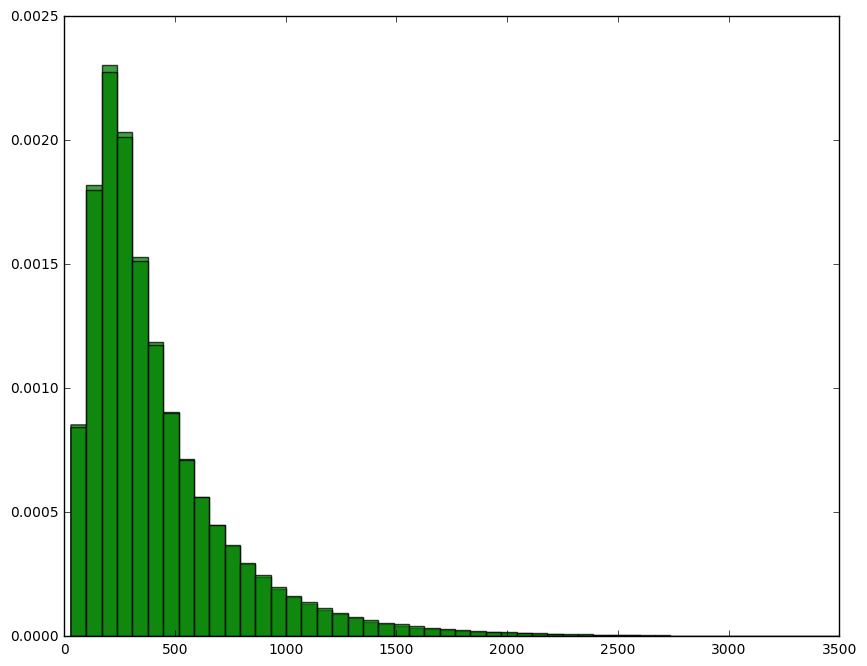

In [10]:
areas = biomarkers[:,8]
n, bins, patches = plt.hist(biomarkers[biomarkers[:,7]==1,8], 50, normed=1, facecolor='green', alpha=0.75)
n, bins, patches = plt.hist(areas, 50, normed=1, facecolor='green', alpha=0.75)
print np.min(areas),np.max(areas)

In [107]:
# test out how to calculate the entropy
import math

clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
cell_bm = spot_bm[j,:].reshape(1,-1) # cell of question
print cell_bm.shape
cell_xy = spot_xy[j,:]
nb_bm = spot_bm[ind[j][dist[j]!=0], :] # eliminate itself
print nb_bm.shape
nb_xy = spot_xy[ind[j][dist[j]!=0], :]

nb_diff_xy = nb_xy - cell_xy
nb_diff_xy = nb_diff_xy/np.linalg.norm(nb_diff_xy,axis = 1).reshape(-1,1)
#nb_angles = [math.acos(nb_diff_xy[0,:]*nb_diff_xy[i,:]) for i in range(1,nb_diff_xy.shape[0])]
nb_angles = [0]+[math.acos(np.dot(nb_diff_xy[0,:],nb_diff_xy[i,:])) for i in range(1,nb_diff_xy.shape[0])]
clf.fit(nb_bm.T,cell_bm.T)
nb_angles = [(nb_angles[i] + np.pi/100) % np.pi for i in xrange(len(nb_angles))]
print clf.coef_, nb_angles  # coefficients

bin_vec = np.linspace(0, np.pi, num=36)
nb_bin = [(bin_vec -nb_angles[i] >=0).nonzero()[0][0] for i in range(len(nb_angles))]

pk = np.zeros(36)

for i in xrange(len(nb_angles)):
    pk[nb_bin[i]] = pk[nb_bin[i]] + clf.coef_[i] 

#print pk
#print pk/np.sum(pk)
print scipy.stats.entropy(pk)
print scipy.stats.circstd(nb_angles)
coef_ = clf.coef_/np.sum(clf.coef_)
cos_mean_resultant = np.sum([coef_[i]*math.cos(nb_angles[i]) for i in range(len(coef_))])
sin_mean_resultant = np.sum([coef_[i]*math.sin(nb_angles[i]) for i in range(len(coef_))])
mean_resultant = np.sqrt(cos_mean_resultant**2+sin_mean_resultant**2)
print mean_resultant
my_std = np.sqrt(2*(1-mean_resultant))
print my_std

# divide into 36 bins

# dist_to_neighbors.append(dist[j][dist[j]!=0])
# conn = spot_epi_stroma[j] == spot_epi_stroma[ind[j][dist[j]!=0]]
# conn_types.append(np.asarray([int(conn[k]) for k in xrange(len(conn))]))
# curr_neigh_ind = ind[j][dist[j]!=0]
# neighbor_id.append(ind[j][dist[j]!=0])

(1, 35)
(3, 35)
[ 0.32374777  0.32672816  0.11575942] [0.031415926535897934, 2.0934033042840747, 1.071374994559804]
1.01299088443
0.884991623302
0.587407108205
0.908397370973


In [99]:
def calculate_spot_features(spot_bm, spot_meta,alpha, radius,l1_ratio):
    # get nearest neighbors
    spot_xy = spot_meta[:,:2]
    tree = KDTree(spot_xy)
    ind, dist = tree.query_radius(spot_xy, r = radius, return_distance = True)
    
    #num_non_zeros_nn = [] # number of contributing neighbors
    entropies = [] # entropy
    angle_std = [] # std
    neighbor_id = [] # id of neighbor
    residuals = [] # residuals at each cells
    coeff_neighbors = [] # coefficient of neighbor each cell
    
    for j in xrange(spot_bm.shape[0]):
        clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        
        cell_bm = spot_bm[j,:].reshape(1,-1) # cell of question
        cell_xy = spot_xy[j,:]
        
        nb_bm = spot_bm[ind[j][dist[j]!=0], :] # eliminate itself
        nb_xy = spot_xy[ind[j][dist[j]!=0], :]
        
        curr_neigh_ind = ind[j][dist[j]!=0]
        neighbor_id.append(ind[j][dist[j]!=0])      

        if np.min(nb_bm.shape) > 0:
            clf.fit(nb_bm.T,cell_bm.T)
            pred = clf.predict(nb_bm.T).reshape(1,-1)
            resid_biomarkers = np.square(cell_bm - pred)
            residuals.append(np.sqrt(resid_biomarkers.sum())/cell_bm.shape[1])
            coeff_neighbors.append(clf.coef_)
            
            nb_diff_xy = nb_xy - cell_xy
            nb_diff_xy = nb_diff_xy/np.linalg.norm(nb_diff_xy,axis = 1).reshape(-1,1) # normalize the vector
            
            if len(clf.coef_) >= 2 and (np.linalg.norm(clf.coef_) > 0):
                nb_angles = [0]
                for k in xrange(len(clf.coef_)-1):
                    a = np.dot(nb_diff_xy[0,:],nb_diff_xy[k+1,:])
                    a = np.sign(a)*np.minimum(1,np.abs(a))
                    nb_angles.append(math.acos(a))
                    #nb_angles.append(math.acos(np.dot(nb_diff_xy[0,:],nb_diff_xy[k+1,:])))
                    
                #nb_angles = [0]+[math.acos(np.dot(nb_diff_xy[0,:],nb_diff_xy[i,:])) for i in range(1,nb_diff_xy.shape[0])]
                #print 'Done'
                nb_angles = [(nb_angles[i] + np.pi/100) % 2*np.pi for i in xrange(len(nb_angles))]
                bin_vec = np.linspace(0, 2*np.pi, num=36)
                nb_bin = [(bin_vec -nb_angles[i] >=0).nonzero()[0][0] for i in range(len(nb_angles))]
                pk = np.zeros(36)
                for i in xrange(len(nb_angles)):
                    pk[nb_bin[i]] = pk[nb_bin[i]] + np.abs(clf.coef_[i])
                cell_entropy = scipy.stats.entropy(pk)
                if np.isinf(cell_entropy):
                    return (0, cell_xy, nb_xy, cell_entropy, nb_bm, cell_bm)
                entropies.append(cell_entropy)
                #angle_std.append(scipy.stats.circstd(nb_angles))
                coef_ = np.abs(clf.coef_)/np.sum(np.abs(clf.coef_))
                cos_mean_resultant = np.sum([coef_[i]*math.cos(nb_angles[i]) for i in range(len(coef_))])
                sin_mean_resultant = np.sum([coef_[i]*math.sin(nb_angles[i]) for i in range(len(coef_))])
                mean_resultant = np.sqrt(cos_mean_resultant**2+sin_mean_resultant**2)
                cell_angle_std = np.sqrt(2*(1-mean_resultant))
                if np.isnan(cell_angle_std):
                    return(0, cell_xy, nb_xy, cell_entropy, nb_bm, cell_bm)
                angle_std.append(cell_angle_std)
            else:
                entropies.append(0)
                angle_std.append(0)
        else:
            #print spot_name, j, nb_bm.shape                   
            residuals.append(0)
            entropies.append(0)
            angle_std.append(0)
            coeff_neighbors.append([])
    
    return (residuals, entropies, angle_std, coeff_neighbors, neighbor_id)

In [101]:
print bm_data.shape

(1312641, 35)


In [ ]:
def calculate_spot_features(spot_id, all_spot_id, bm_data, meta_data, alpha, radius,l1_ratio):
    cell_id = all_cell_id[all_spot_id == spot_id]
    spot_bm = bm_data[cell_id - 1, :] # biomarker values of the spot
    spot_meta = meta_data[cell_id -1, :] # x,y coordinates of each cell
            
    # get nearest neighbors
    spot_xy = spot_meta[:,:2]
    tree = KDTree(spot_xy)
    ind, dist = tree.query_radius(spot_xy, r = radius, return_distance = True)
    
    #num_non_zeros_nn = [] # number of contributing neighbors
    entropies = [] # entropy
    angle_std = [] # std
    neighbor_id = [] # id of neighbor
    residuals = [] # residuals at each cells
    coeff_neighbors = [] # coefficient of neighbor each cell
    
    for j in xrange(spot_bm.shape[0]):
        clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        
        cell_bm = spot_bm[j,:].reshape(1,-1) # cell of question
        cell_xy = spot_xy[j,:]
        
        nb_bm = spot_bm[ind[j][dist[j]!=0], :] # eliminate itself
        nb_xy = spot_xy[ind[j][dist[j]!=0], :]
        
        curr_neigh_ind = ind[j][dist[j]!=0]
        neighbor_id.append(ind[j][dist[j]!=0])      

        if np.min(nb_bm.shape) > 0:
            clf.fit(nb_bm.T,cell_bm.T)
            pred = clf.predict(nb_bm.T).reshape(1,-1)
            resid_biomarkers = np.square(cell_bm - pred)
            residuals.append(np.sqrt(resid_biomarkers.sum())/cell_bm.shape[1])
            coeff_neighbors.append(clf.coef_)
            
            nb_diff_xy = nb_xy - cell_xy
            nb_diff_xy = nb_diff_xy/np.linalg.norm(nb_diff_xy,axis = 1).reshape(-1,1) # normalize the vector
            
            if len(clf.coef_) >= 2 and (np.linalg.norm(clf.coef_) > 0):
                nb_angles = [0]
                for k in xrange(len(clf.coef_)-1):
                    a = np.dot(nb_diff_xy[0,:],nb_diff_xy[k+1,:])
                    a = np.sign(a)*np.minimum(1,np.abs(a))
                    nb_angles.append(math.acos(a))
                    #nb_angles.append(math.acos(np.dot(nb_diff_xy[0,:],nb_diff_xy[k+1,:])))
                    
                #nb_angles = [0]+[math.acos(np.dot(nb_diff_xy[0,:],nb_diff_xy[i,:])) for i in range(1,nb_diff_xy.shape[0])]
                #print 'Done'
                nb_angles = [(nb_angles[i] + np.pi/100) % 2*np.pi for i in xrange(len(nb_angles))]
                bin_vec = np.linspace(0, 2*np.pi, num=36)
                nb_bin = [(bin_vec -nb_angles[i] >=0).nonzero()[0][0] for i in range(len(nb_angles))]
                pk = np.zeros(36)
                for i in xrange(len(nb_angles)):
                    pk[nb_bin[i]] = pk[nb_bin[i]] + np.abs(clf.coef_[i])
                cell_entropy = scipy.stats.entropy(pk)
                if np.isinf(cell_entropy):
                    return (0, cell_xy, nb_xy, cell_entropy, nb_bm, cell_bm)
                entropies.append(cell_entropy)
                #angle_std.append(scipy.stats.circstd(nb_angles))
                coef_ = np.abs(clf.coef_)/np.sum(np.abs(clf.coef_))
                cos_mean_resultant = np.sum([coef_[i]*math.cos(nb_angles[i]) for i in range(len(coef_))])
                sin_mean_resultant = np.sum([coef_[i]*math.sin(nb_angles[i]) for i in range(len(coef_))])
                mean_resultant = np.sqrt(cos_mean_resultant**2+sin_mean_resultant**2)
                cell_angle_std = np.sqrt(2*(1-mean_resultant))
                if np.isnan(cell_angle_std):
                    return(0, cell_xy, nb_xy, cell_entropy, nb_bm, cell_bm)
                angle_std.append(cell_angle_std)
            else:
                entropies.append(0)
                angle_std.append(0)
        else:
            #print spot_name, j, nb_bm.shape                   
            residuals.append(0)
            entropies.append(0)
            angle_std.append(0)
            coeff_neighbors.append([])
    
    return (residuals, entropies, angle_std, coeff_neighbors, neighbor_id)

In [ ]:
# Loop through some possible combinations & also scramble the bm data to get an idea 
#of stage separation by these numbers
from sklearn.neighbors import NearestNeighbors, KDTree
from sklearn import linear_model
import scipy.io
from itertools import product
import math
import multiprocessing
from functools import partial

#output_path = '/media/ColonCancerStudy/NN_data'
#output_path = '/mnt/lun5/ColonCancerStudy/NN_data/'
#output_path = '/home/lun5/Documents/multiplex/NN_data'
output_path = '/home/lun5/Documents/multiplex/Entropy_data_2'
if not os.path.isdir(output_path):
    os.makedirs(output_path)

# Question is how do you choose alpha here, we can test
alphas = [.1, 1]
radii = [50,100] # Values: 50, 100
l1_ratios = [0, 0.5, 1] # need to add 0 in there

bm_data = biomarkers[:,indx_good_nuc_biomarker]
meta_data = biomarkers[:,[0,1,2,7,8]] # 0,1: xy, 2:epi_stroma, 7: num_nuclei, 8:area

seeds = [1, 50, 100]
np.random.seed(100)

#print all_spot_names[np.nonzero(all_spot_id == 30)[0][0]]
for alpha, radius, l1_ratio in product(alphas, radii,l1_ratios):
    NN_OUTPUT = os.path.join(output_path, ('Entropy_radius_' + str(radius)) + '_alpha_' +str(alpha) 
                          + '_L1ratio_' + str(l1_ratio))
    if os.path.isdir(NN_OUTPUT):
        print(('Elastic: Already started calculation for alpha = %0.2f radius = %d, l1_ratio = %0.2f') %(
            alpha, radius, l1_ratio))

    if not os.path.isdir(NN_OUTPUT):
        print(('Elastic: Have not calculated for alpha = %0.2f radius = %d, l1_ratio = %0.2f') %(
            alpha, radius, l1_ratio))
        os.makedirs(NN_OUTPUT)
    
    start_time = time.time()
    
    stop_loop = 0
    for i in xrange(len(spot_id)):
        spot_name = all_spot_names[np.nonzero(all_spot_id ==spot_id[i])[0][0]]
        cell_id = all_cell_id[all_spot_id == spot_id[i]]
        if os.path.isfile(os.path.join(NN_OUTPUT,spot_name + '.mat')):
           continue
        else: 
            #print spot_name
            spot_bm = bm_data[cell_id - 1, :] # biomarker values of the spot
            spot_meta = meta_data[cell_id -1, :] # x,y coordinates of each cell
            #print spot_bm.shape, len(cell_id)
            # original
            #residuals, entropies, angle_std, coeff_neighbors, neighbor_id = calculate_spot_features(
            #    spot_bm, spot_meta,alpha, radius,l1_ratio)
            
            output = calculate_spot_features(
                spot_bm, spot_meta,alpha, radius,l1_ratio)
            
            if output[0] == 0:
                _, cell_xy, nb_xy, cell_entropy, nb_bm, cell_bm = output
                print('%s has inf entropy' %(spot_name))
                stop_loop = 1
                break
            else: 
                residuals, entropies, angle_std, coeff_neighbors, neighbor_id = output
                
            scipy.io.savemat(os.path.join(NN_OUTPUT,spot_name + '.mat'), 
                 mdict={'spot_meta':spot_meta,'entropies':entropies,
                        'residuals':residuals,'angle_std':angle_std,
                        'coeff_neigh':coeff_neighbors, 'neighbor_id':neighbor_id
                       })
            
            # scramble
            for ss in seeds:
                np.random.seed(ss)
                scramble_spot_bm = spot_bm[np.random.permutation(np.arange(len(cell_id))),:]
                #print spot_bm.shape
                output = calculate_spot_features(scramble_spot_bm, spot_meta,alpha, radius,l1_ratio)

                if output[0] == 0:
                    _, cell_xy, nb_xy, cell_entropy, nb_bm, cell_bm = output
                    print('%s has inf entropy' %(spot_name))
                    stop_loop = 1
                    break
                else: 
                    residuals, entropies, angle_std, coeff_neighbors, neighbor_id = output

                scipy.io.savemat(os.path.join(NN_OUTPUT,str(ss)+ '_' +
                                              spot_name + '_scramble.mat'), 
                     mdict={'spot_meta':spot_meta,'entropies':entropies,
                            'residuals':residuals,'angle_std':angle_std,
                            'coeff_neigh':coeff_neighbors, 'neighbor_id':neighbor_id
                           })
    
    print('Done with alpha=%0.1f, radius = %d in %0.2f seconds' %(alpha,radius, time.time() - start_time))            
    if stop_loop == 1:
        break
            

Elastic: Have not calculated for alpha = 0.10 radius = 50, l1_ratio = 0.00


In [106]:
pk = np.array([0,0,0,0,0])
cell_entropy = scipy.stats.entropy(pk + 1e-6)
print cell_entropy
pk = np.array([1,1,1])
cell_entropy = scipy.stats.entropy(pk)
print cell_entropy

1.60943791243
1.09861228867


In [82]:
print len(output), nb_bm.shape, cell_bm.shape, cell_xy.shape, nb_xy.shape

clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
clf.fit(nb_bm.T,cell_bm.T)
pred = clf.predict(nb_bm.T).reshape(1,-1)
resid_biomarkers = np.square(cell_bm - pred)
residual = np.sqrt(resid_biomarkers.sum())/cell_bm.shape[1]
print 'residual is ', residual
nb_diff_xy = nb_xy - cell_xy
print np.linalg.norm(nb_diff_xy, axis = 1),nb_diff_xy.shape

# normalize the vector
nb_diff_xy = nb_diff_xy/np.linalg.norm(nb_diff_xy,axis = 1).reshape(-1,1) 
print np.linalg.norm(nb_diff_xy,axis = 1)

if len(clf.coef_) >= 2:
    nb_angles = [0]
    for k in xrange(len(clf.coef_)-1):
        a = np.dot(nb_diff_xy[0,:],nb_diff_xy[k+1,:])
        a = np.sign(a)*np.minimum(1,np.abs(a))
        nb_angles.append(math.acos(a))
        #nb_angles.append(math.acos(np.dot(nb_diff_xy[0,:],nb_diff_xy[k+1,:])))
    print 'neighbor angle is ', nb_angles     
    #nb_angles = [0]+[math.acos(np.dot(nb_diff_xy[0,:],nb_diff_xy[i,:])) for i in range(1,nb_diff_xy.shape[0])]
    #print 'Done'
    nb_angles = [(nb_angles[i] + np.pi/100) % (2*np.pi) for i in xrange(len(nb_angles))]
    print 'Move it a little: neighbor angle is ', nb_angles 
    bin_vec = np.linspace(0, 2*np.pi, num=36)
    nb_bin = [(bin_vec -nb_angles[i] >=0).nonzero()[0][0] for i in range(len(nb_angles))]
    print 'neighbor bin is ', nb_bin
    pk = np.zeros(36)
    for i in xrange(len(nb_angles)):
        pk[nb_bin[i]] = pk[nb_bin[i]] + np.abs(clf.coef_[i])
    #pk = pk/np.sum(pk)
    cell_entropy = scipy.stats.entropy(pk)
    print 'pk is ', pk
    print 'cell entropy is', cell_entropy
    
    #angle_std.append(scipy.stats.circstd(nb_angles))
    coef_ = np.abs(clf.coef_)/np.sum(np.abs(clf.coef_))
    cos_mean_resultant = np.sum([coef_[i]*math.cos(nb_angles[i]) for i in range(len(coef_))])
    sin_mean_resultant = np.sum([coef_[i]*math.sin(nb_angles[i]) for i in range(len(coef_))])
    mean_resultant = np.sqrt(np.sum(cos_mean_resultant**2+sin_mean_resultant**2))
    print mean_resultant
    cell_angle_std = np.sqrt(2*(1-mean_resultant))

6 (5, 35) (1, 35) (2,) (5, 2)
residual is  0.0
[ 45.17742799  23.          37.01351105  26.30589288  30.6757233 ] (5, 2)
[ 1.  1.  1.  1.  1.]
neighbor angle is  [0, 1.659452208662334, 1.6324317594750692, 0.24130521026270274, 1.3273927411194486]
Move it a little: neighbor angle is  [0.031415926535897934, 1.690868135198232, 1.6638476860109672, 0.27272113679860066, 1.3588086676553466]
neighbor bin is  [1, 10, 10, 2, 8]
pk is  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cell entropy is -inf
nan


/home/lun5/anaconda2/envs/sql/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


In [88]:
print np.linalg.norm(cell_bm) > 0
print nb_bm

False
[[  3.2056115    5.80888997   7.04698143   6.69240214   4.88910779
   10.56433088   5.45253166   5.95502658   4.37781216   5.31434033
   11.31907388   4.22477441   4.03141044   1.34386026   5.19610849
    6.00046888   0.           2.6329864    3.30729813   2.92595877
    3.97653423   0.           3.92240409   0.69285463   6.31905948
    4.52021401   6.14983405   6.09919775   3.9341194    0.           3.3126515
    4.97861647   2.91265061   2.36515009   5.06458959]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  4.92731033   5.86947612   0.           0.           0.           0.
    0.           6.509025

In [12]:
sel_cmd = ('SELECT {tn1}.{coi1},{tn1}.{coi2},{tn1}.{coi3} '
           +' FROM {tn1} JOIN {tn2} ON {tn1}.{coi1} = {tn2}.{coi1}'
           + ' WHERE {tn2}.{coi4} == {0}').format(
    1, coi1='spot_id',coi2='spot_name',coi3 = 'stage_sumajc',
    coi4 = 'ingested', tn1='spots',tn2 = 'ingestion')

print sel_cmd
c.execute(sel_cmd)
results = c.fetchall()
spot_ids =  np.asarray([results[i][0] for i in xrange(len(results))])
spot_names = np.asarray([results[i][1] for i in xrange(len(results))])
spot_stages = np.asarray([results[i][2] for i in xrange(len(results))])

SELECT spots.spot_id,spots.spot_name,spots.stage_sumajc  FROM spots JOIN ingestion ON spots.spot_id = ingestion.spot_id WHERE ingestion.ingested == 1


/home/lun5/Documents/multiplex/output/Entropy_radius_50_alpha_0.1_L1ratio_0
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559234)  after:  559233
length entropy after:  559234
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 558107)  after:  558106
seed  1  length scramble entropy after:  558107
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.0567322420421 0.0866135159097
0.059995079359 0.0924619651782
0.0666261751859 0.102503427318


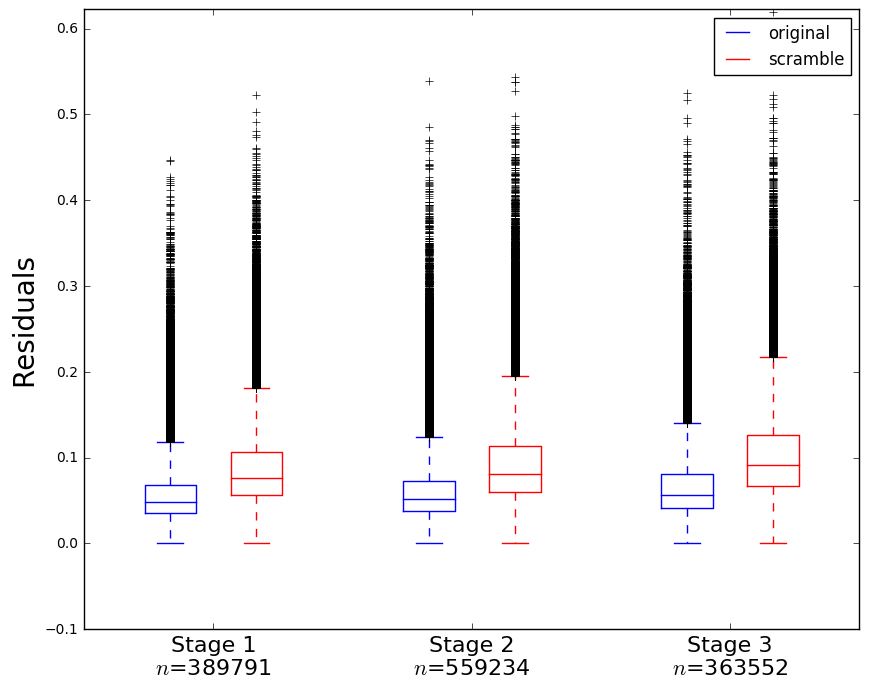

1.6846103876 1.65376264233
1.61950974975 1.58935666339
1.536642608 1.51041628313


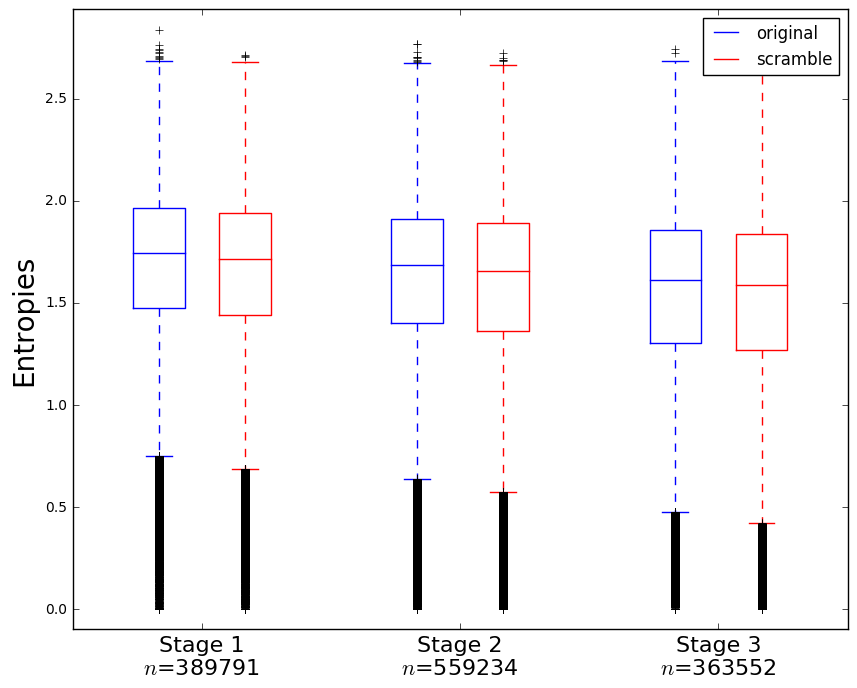

1.08960347023 1.07537585315
1.07118385206 1.05608935641
1.04231924954 1.02827852532


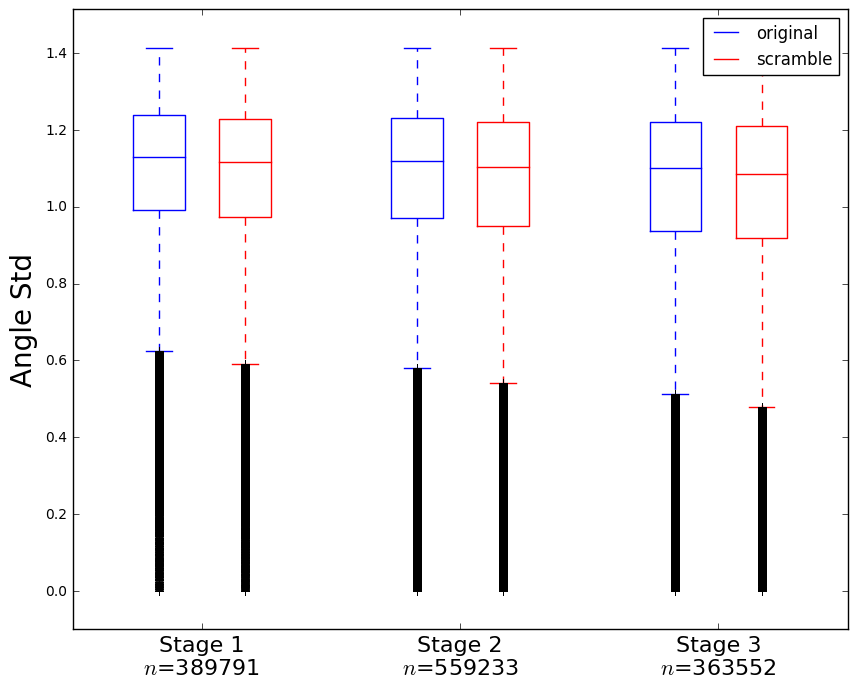

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 558346)  after:  558345
seed  50  length scramble entropy after:  558346
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.0567322420421 0.0866742759068
0.059995079359 0.0924868289581
0.0666261751859 0.102510118632


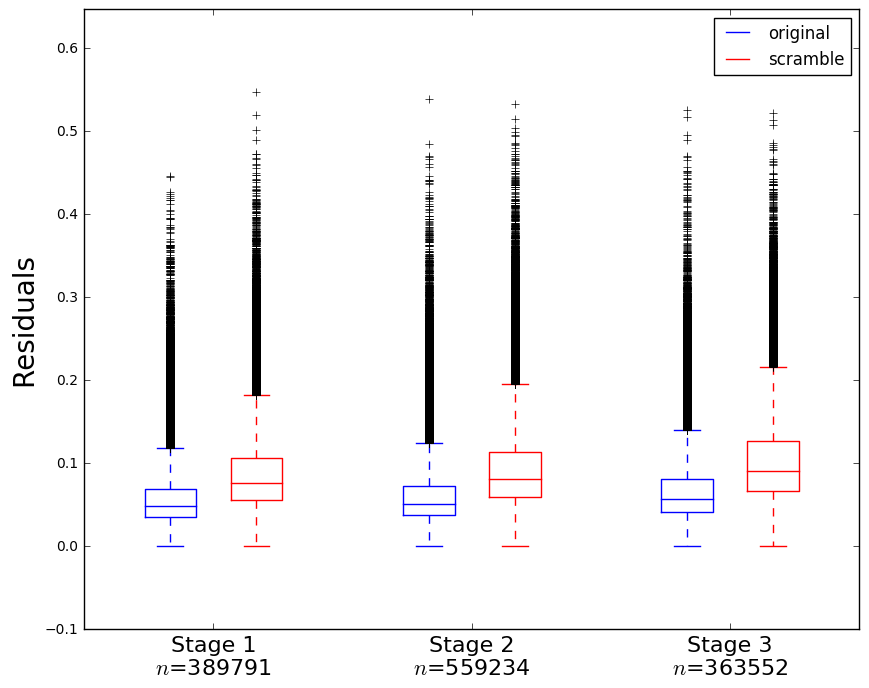

1.6846103876 1.65395798437
1.61950974975 1.58987363016
1.536642608 1.51040348289


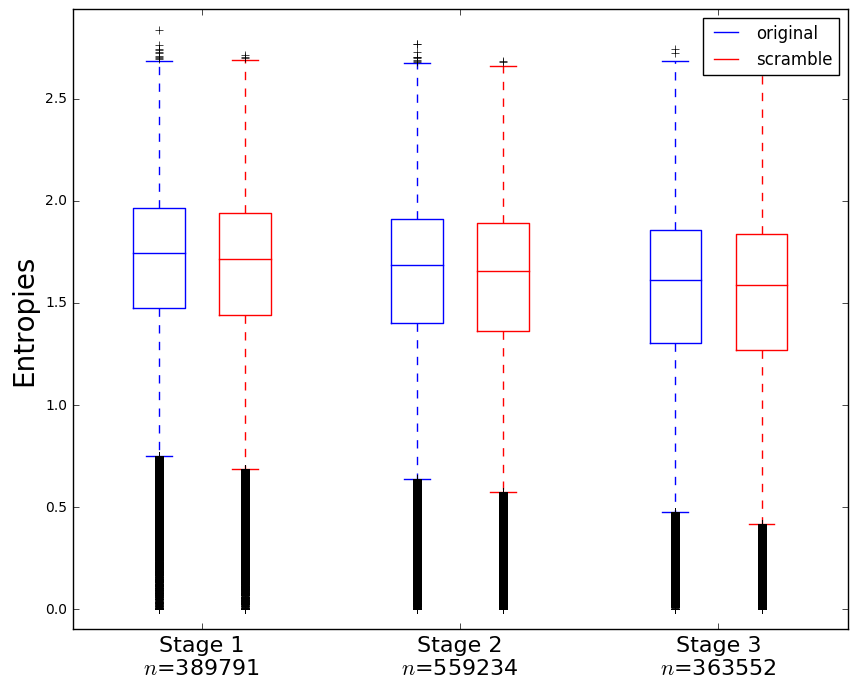

1.08960347023 1.07558208849
1.07118385206 1.05656495915
1.04231924954 1.02828974445


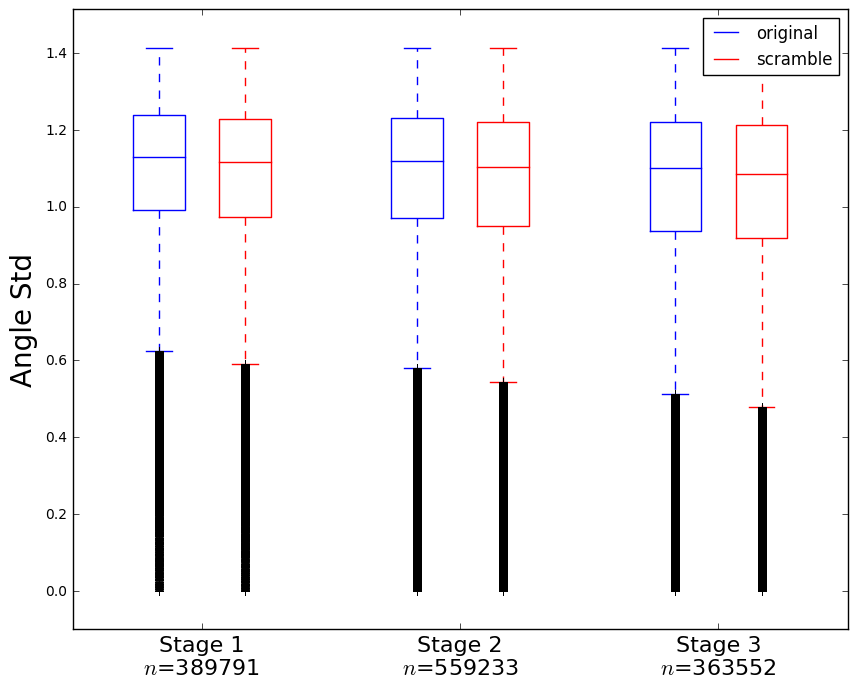

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 556660)  after:  556659
seed  200  length scramble entropy after:  556660
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.0567322420421 0.0867056253865
0.059995079359 0.0924166123292
0.0666261751859 0.102514208395


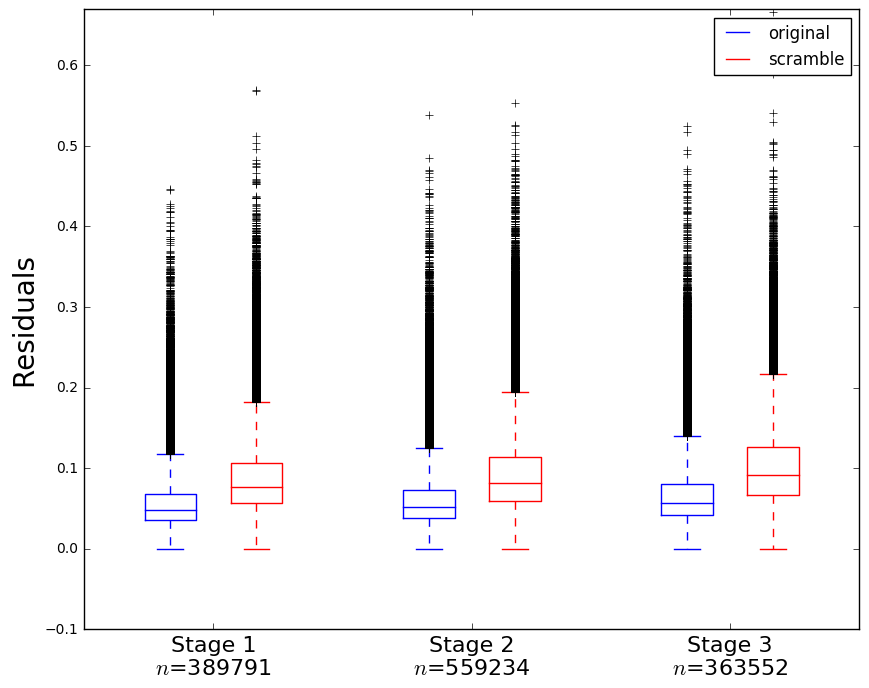

1.6846103876 1.65412253082
1.61950974975 1.58984530356
1.536642608 1.51021789219


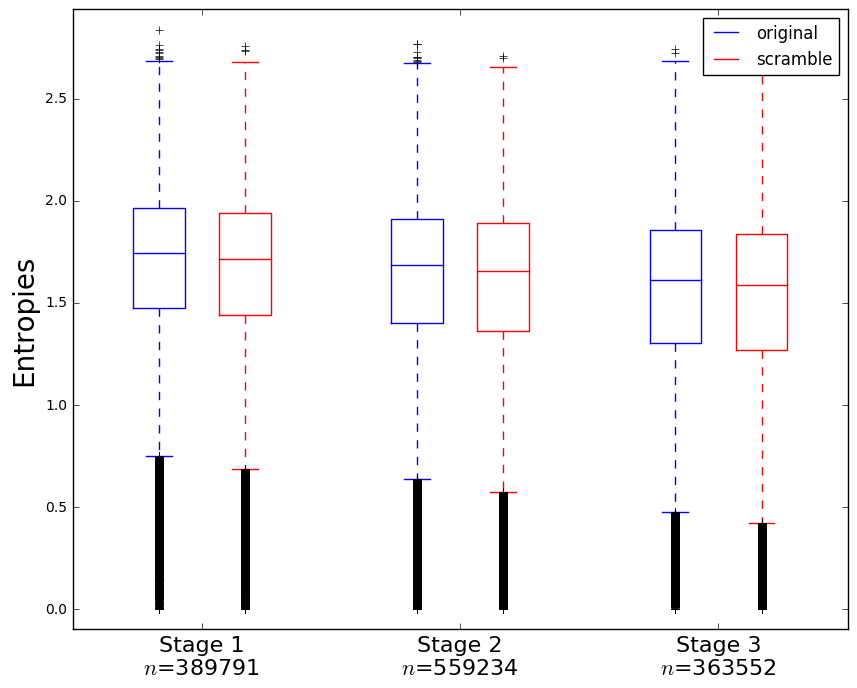

1.08960347023 1.07559575865
1.07118385206 1.0565816137
1.04231924954 1.0285120828


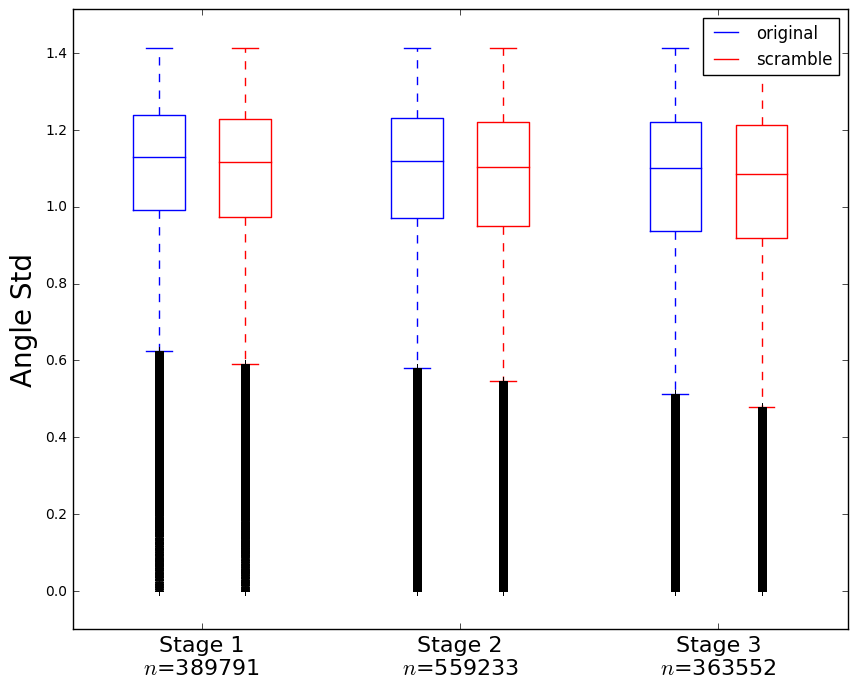

/home/lun5/Documents/multiplex/output/Entropy_radius_50_alpha_0.1_L1ratio_0.5
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559234)  after:  559233
length entropy after:  559234
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 558107)  after:  558106
seed  1  length scramble entropy after:  558107
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.059762845463 0.0906359243248
0.0627971360055 0.0961399704395
0.0693595565958 0.105838285674


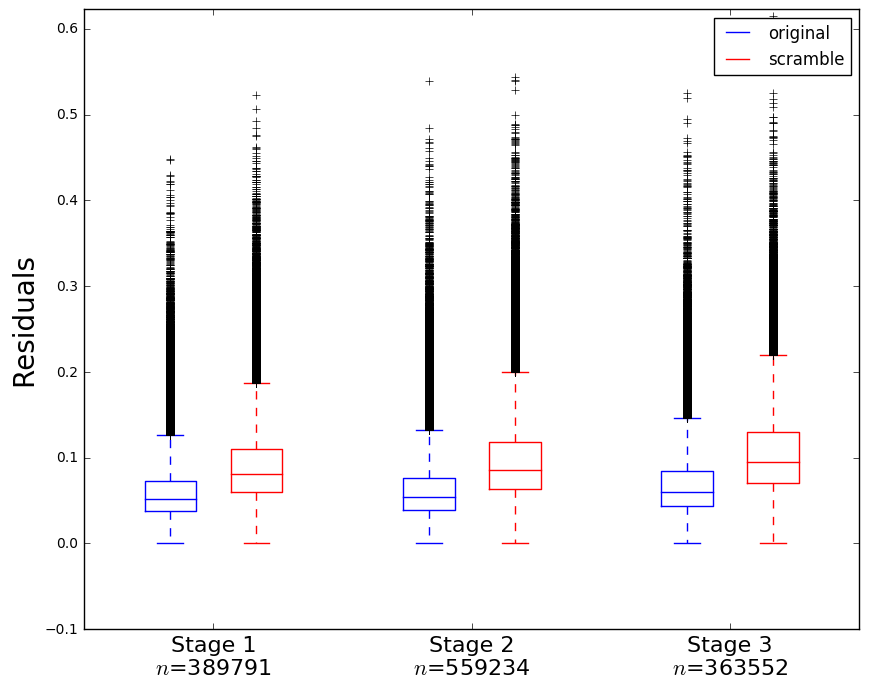

1.27936765892 1.2506069986
1.23867059857 1.22042819102
1.18273118001 1.18882259335


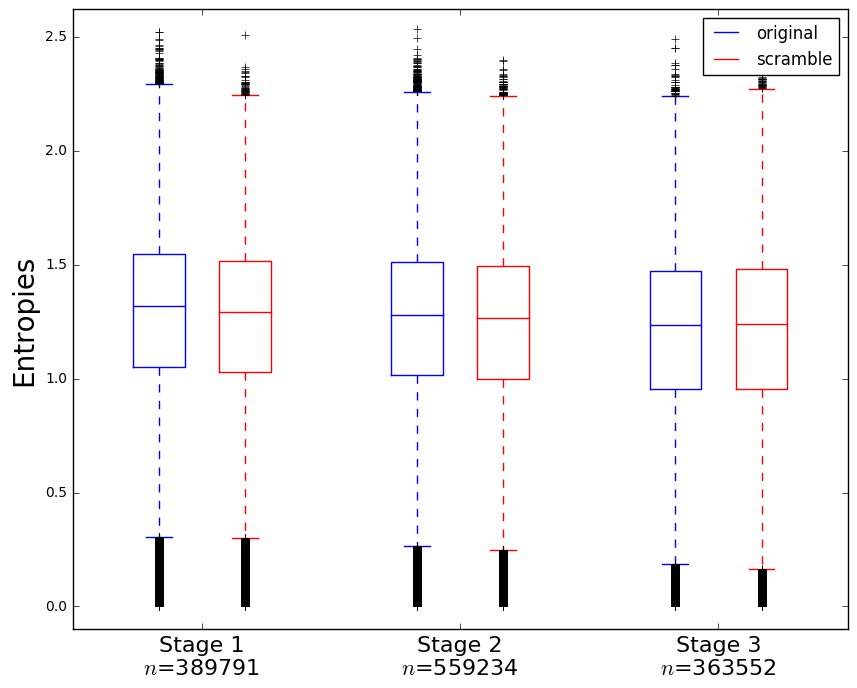

0.963398825598 0.946387251996
0.948670804721 0.934267286797
0.924325870526 0.918393957838


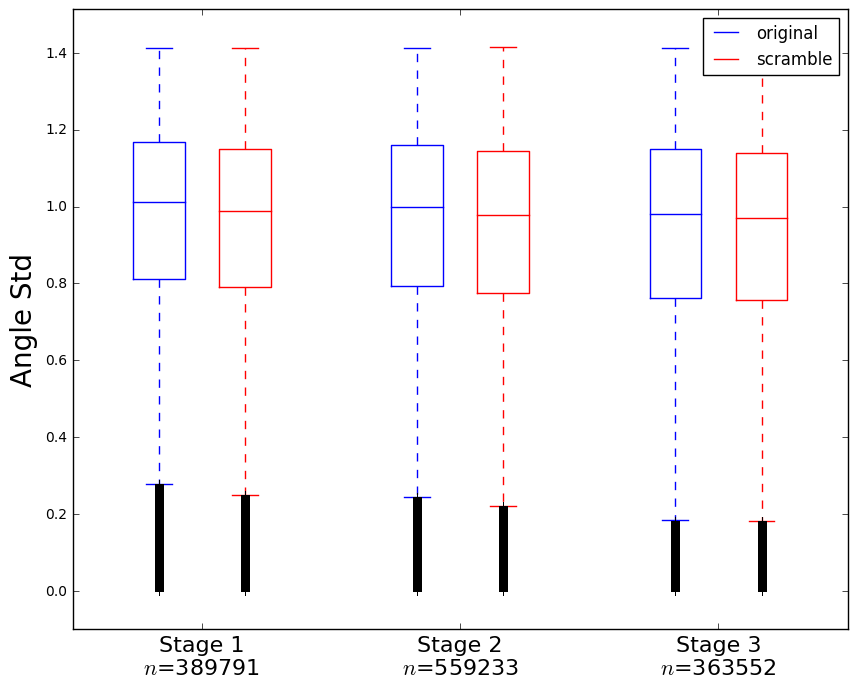

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 558346)  after:  558345
seed  50  length scramble entropy after:  558346
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.059762845463 0.0907004410726
0.0627971360055 0.0961579336305
0.0693595565958 0.105846684734


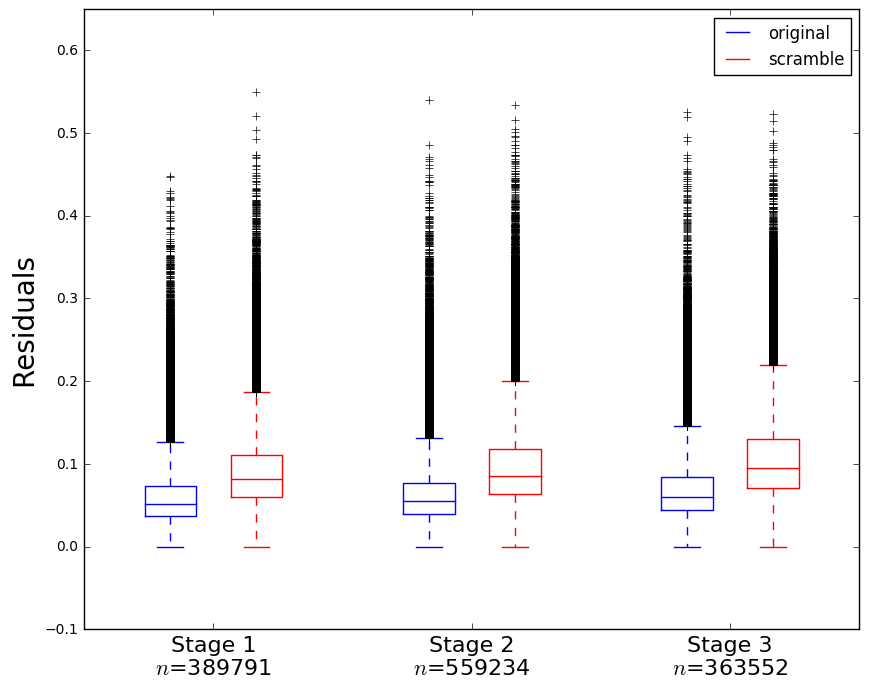

1.27936765892 1.25125301359
1.23867059857 1.22143446503
1.18273118001 1.1890123312


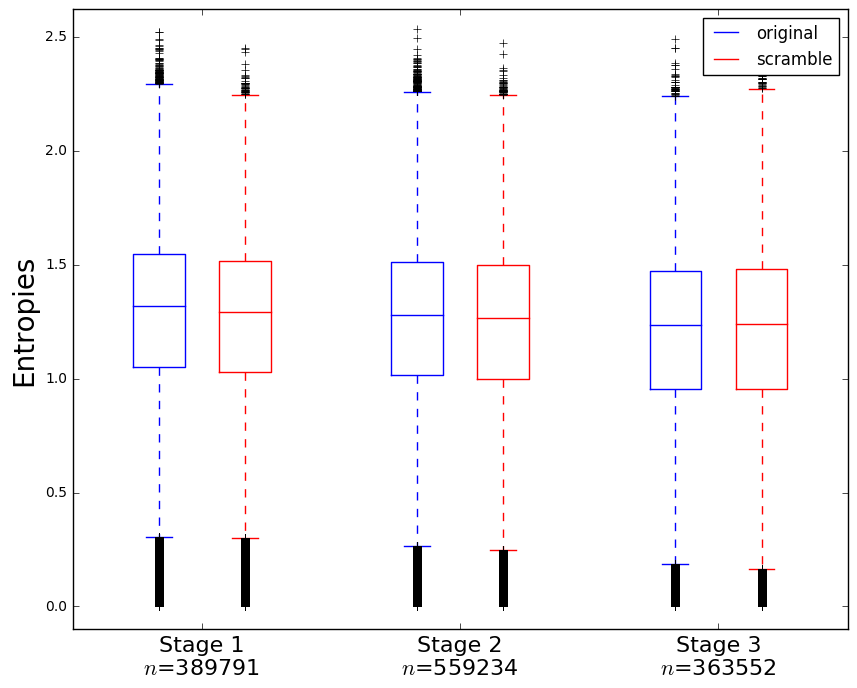

0.963398825598 0.94660725832
0.948670804721 0.934945850231
0.924325870526 0.918324154357


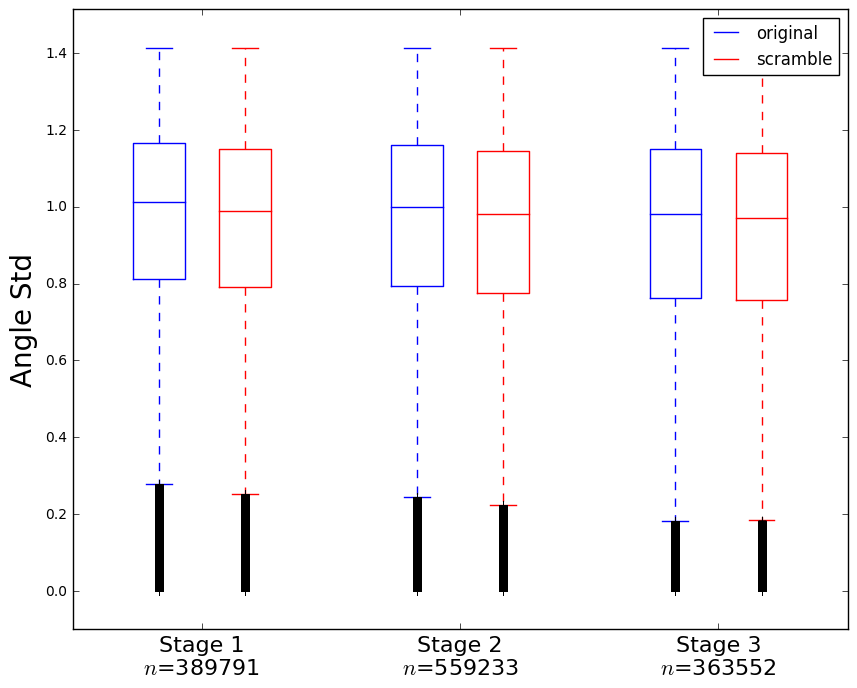

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 556660)  after:  556659
seed  200  length scramble entropy after:  556660
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.059762845463 0.0907274559745
0.0627971360055 0.0960928555188
0.0693595565958 0.105851935732


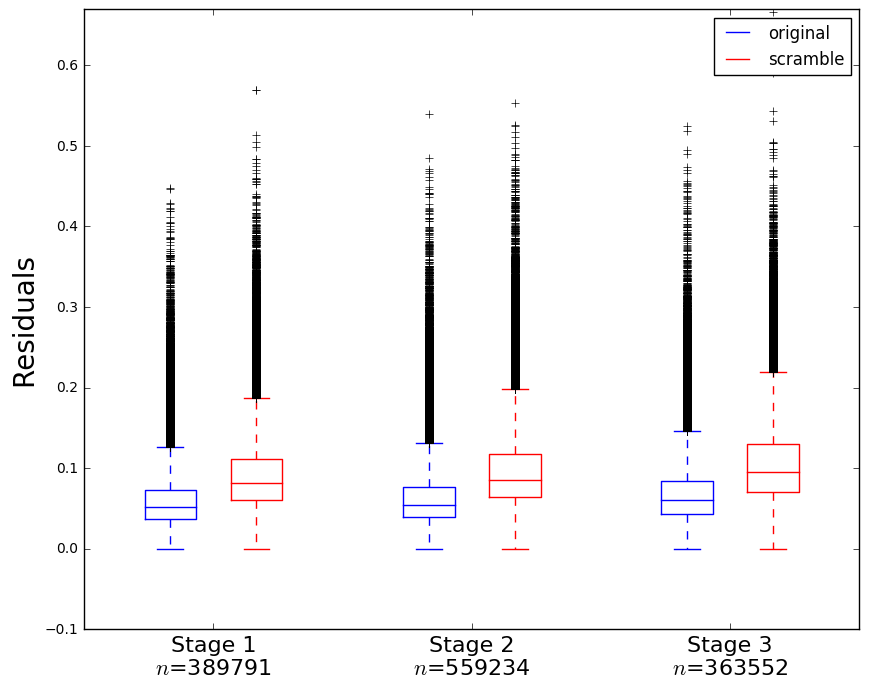

1.27936765892 1.25152285274
1.23867059857 1.220764631
1.18273118001 1.18846030704


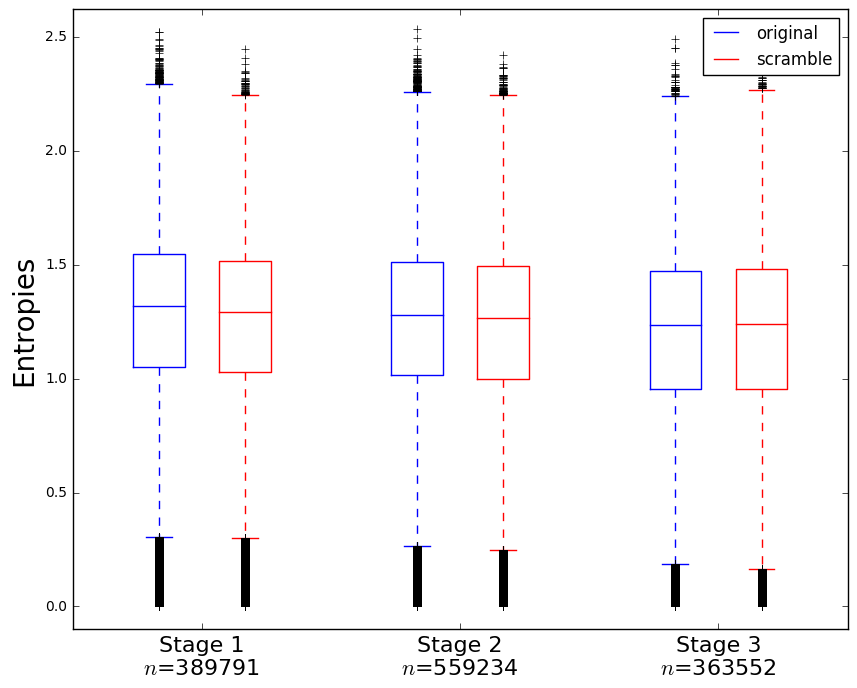

0.963398825598 0.946855213569
0.948670804721 0.934770030633
0.924325870526 0.91816120876


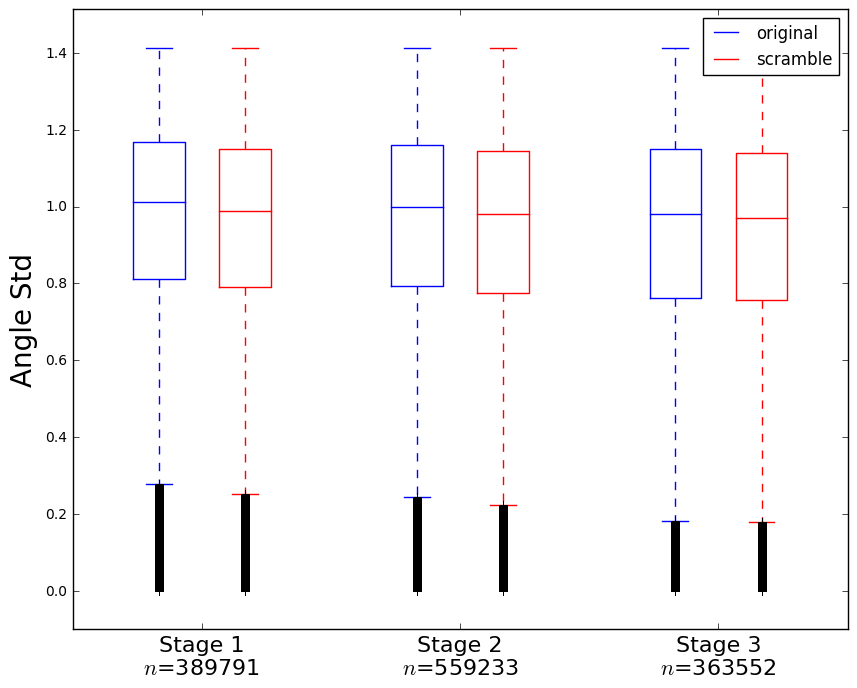

/home/lun5/Documents/multiplex/output/Entropy_radius_50_alpha_0.1_L1ratio_1
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559206)  after:  559204
length entropy after:  559206
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 556730)  after:  556728
seed  1  length scramble entropy after:  556730
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.0607338242662 0.0930297159906
0.0637541185612 0.0984961164271
0.0704510289976 0.108316941881


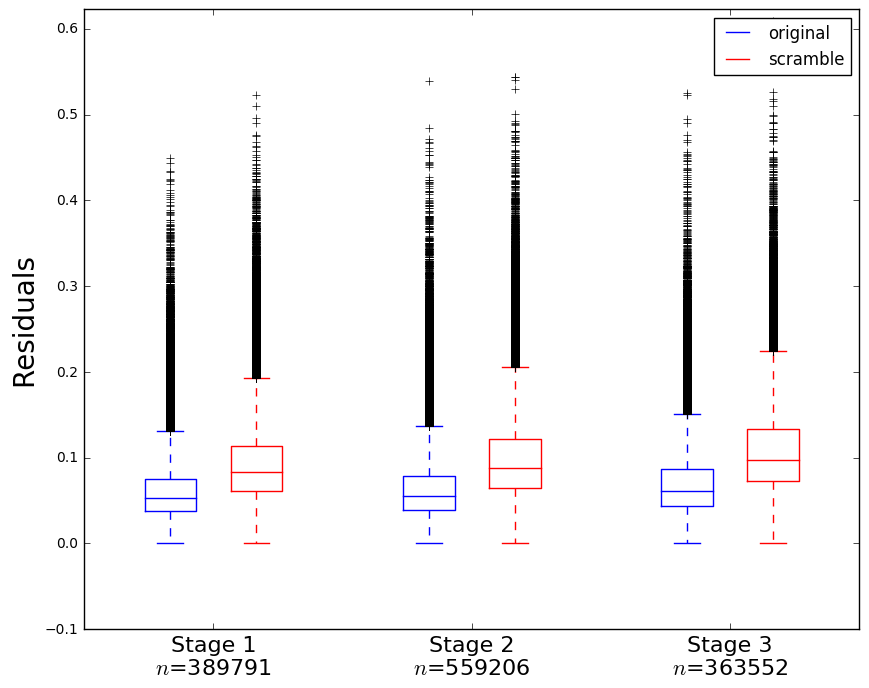

0.995822401106 1.01570695622
0.974297438062 0.997456919697
0.945422351186 0.984381009025


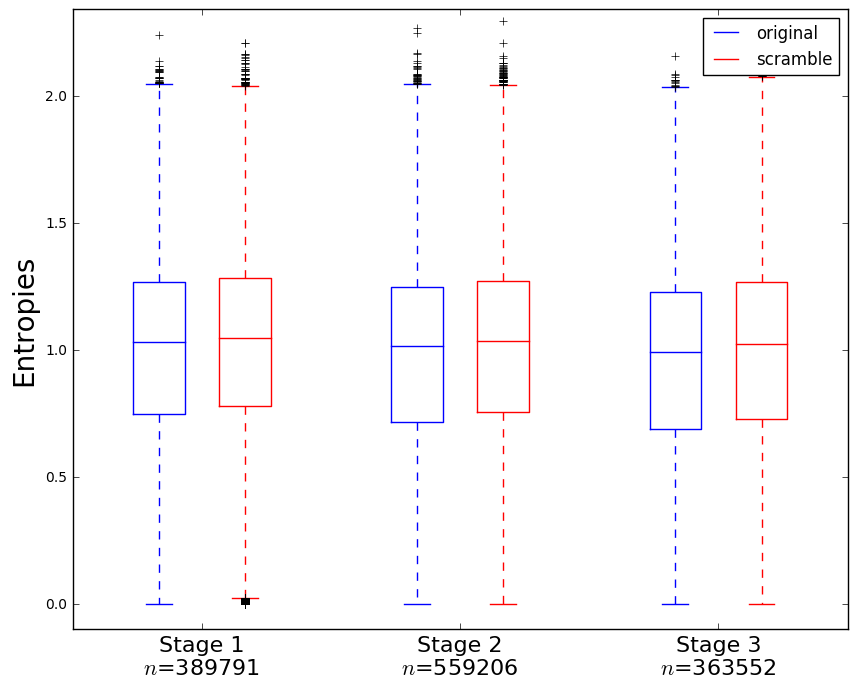

0.839384817609 0.846414352804
0.830606116692 0.837893038853
0.814913458624 0.829587682665


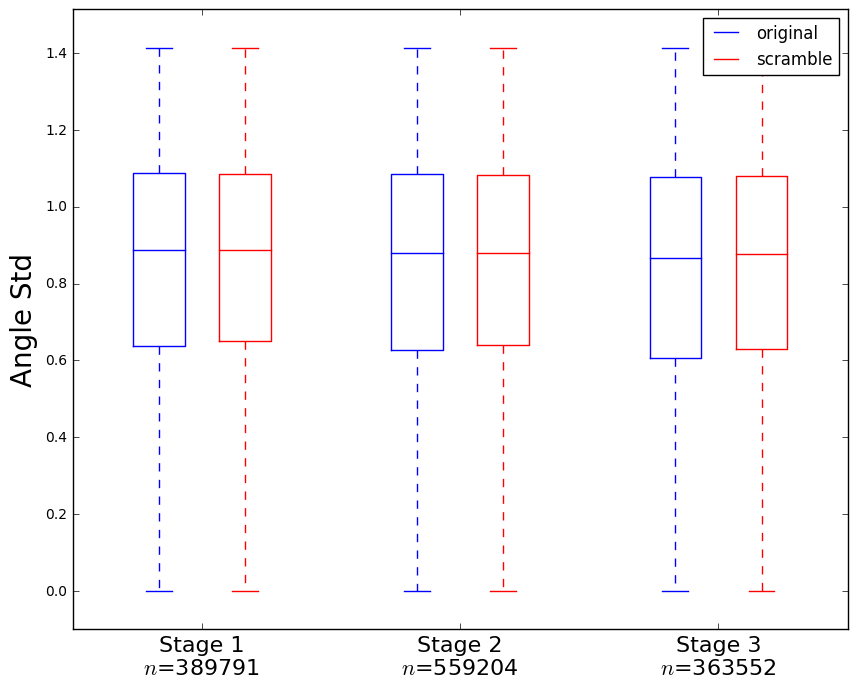

seed  50  length scramble angle std. Before:  (1, 388399)  after:  388398
seed  50  length scramble entropy after:  388399
seed  50  length scramble angle std. Before:  (1, 558346)  after:  558345
seed  50  length scramble entropy after:  558346
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.0607338242662 0.0930991722775
0.0637541185612 0.0985257582484
0.0704510289976 0.10832162064


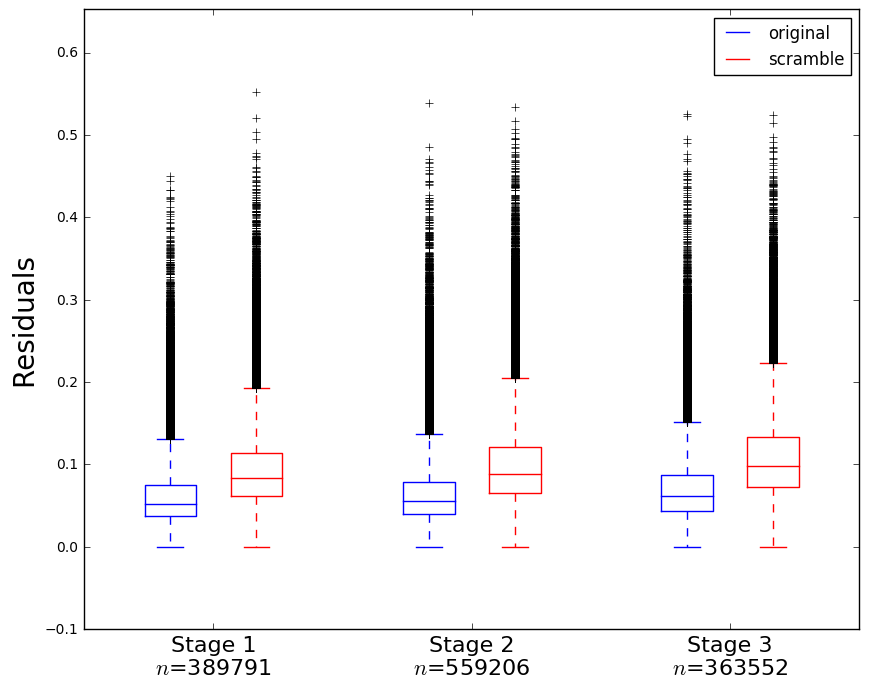

0.995822401106 1.01552134659
0.974297438062 0.998184796571
0.945422351186 0.984729804991


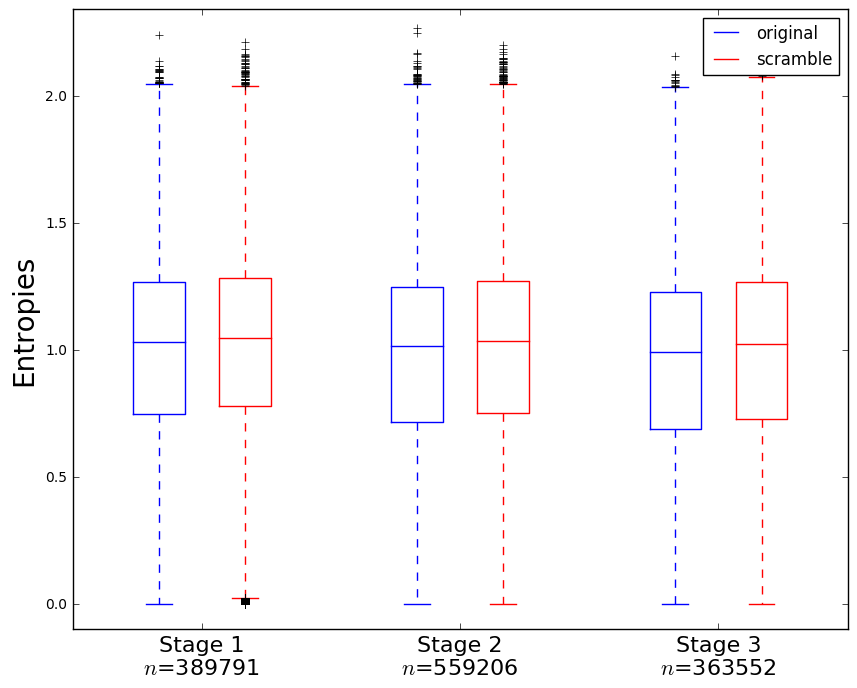

0.839384817609 0.846219306903
0.830606116692 0.838470792298
0.814913458624 0.82957534678


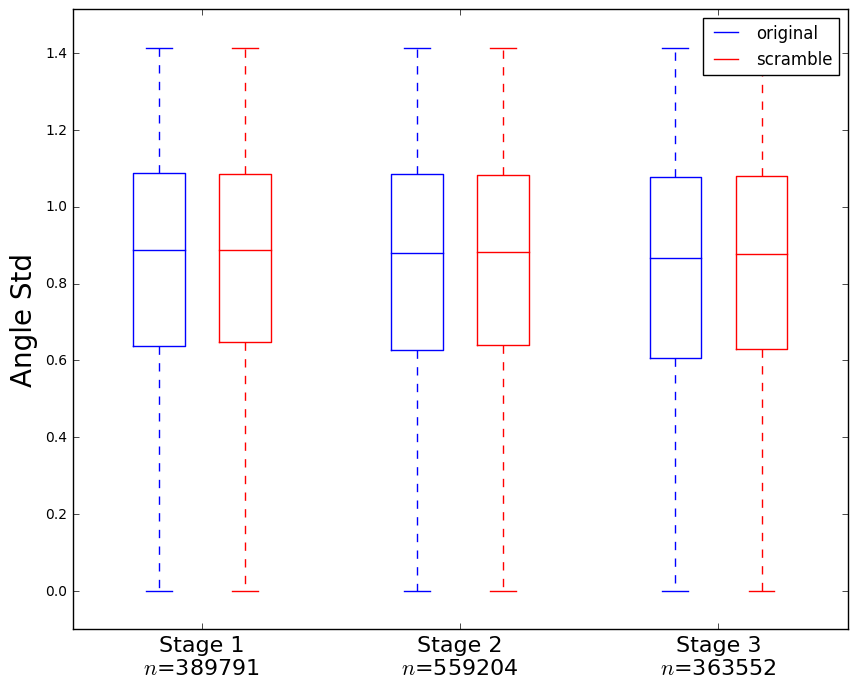

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 555149)  after:  555147
seed  200  length scramble entropy after:  555149
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.0607338242662 0.0931270599492
0.0637541185612 0.0984606807153
0.0704510289976 0.108329673584


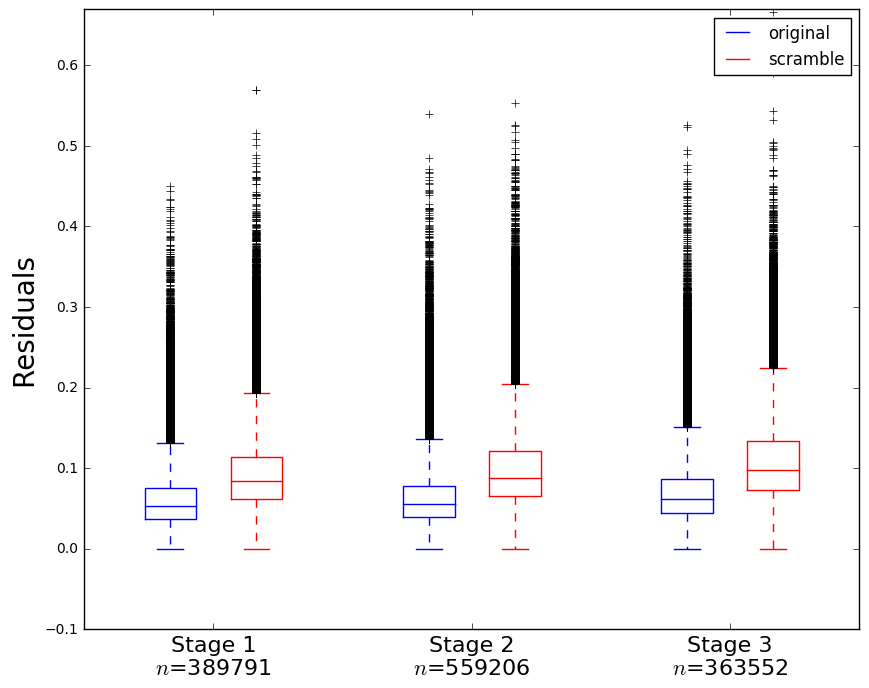

0.995822401106 1.01595053683
0.974297438062 0.997706140011
0.945422351186 0.983743358013


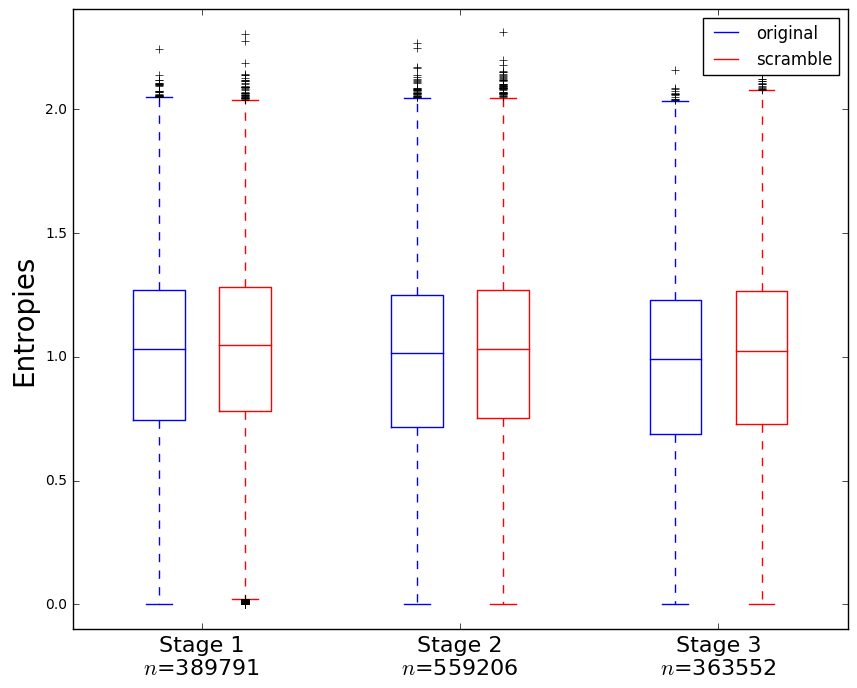

0.839384817609 0.84670775437
0.830606116692 0.83842239781
0.814913458624 0.82918046203


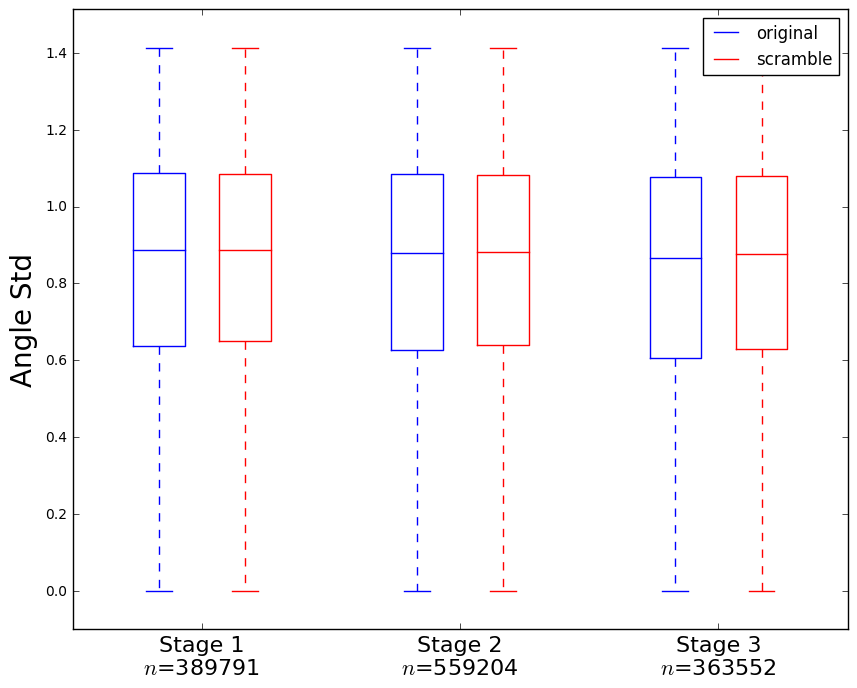

/home/lun5/Documents/multiplex/output/Entropy_radius_100_alpha_0.1_L1ratio_0
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559234)  after:  559233
length entropy after:  559234
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 558107)  after:  558106
seed  1  length scramble entropy after:  558107
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.0331273739493 0.0427255418801
0.0353278634842 0.0457156527238
0.0391590680762 0.0505852319106


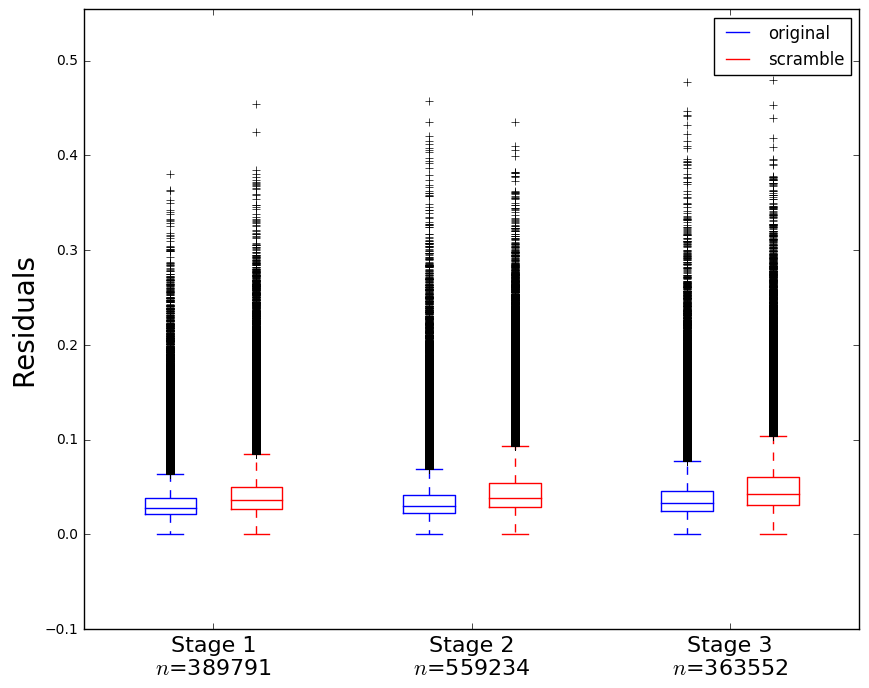

2.69159880898 2.69403414991
2.64843876481 2.65128444268
2.58072301194 2.58371183708


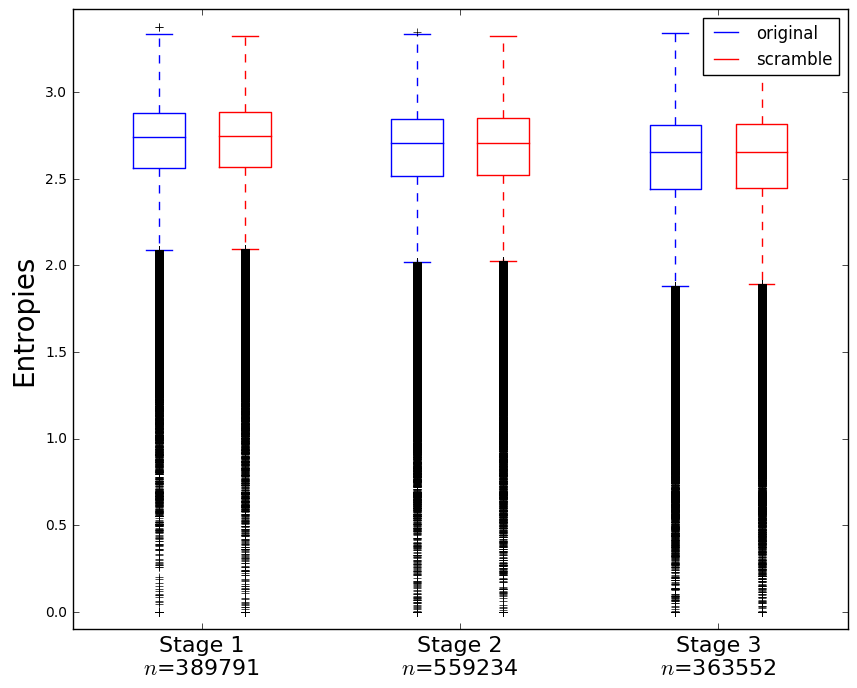

1.19932547289 1.20265845459
1.19579261006 1.19876828804
1.1863559596 1.18828086367


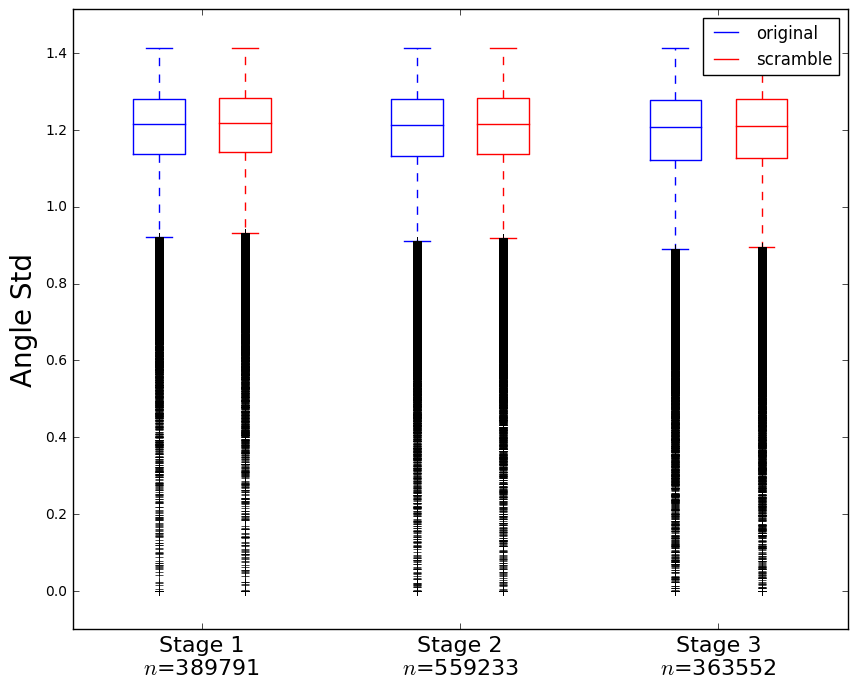

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 558346)  after:  558345
seed  50  length scramble entropy after:  558346
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.0331273739493 0.0427273233757
0.0353278634842 0.0456819065927
0.0391590680762 0.0505695632194


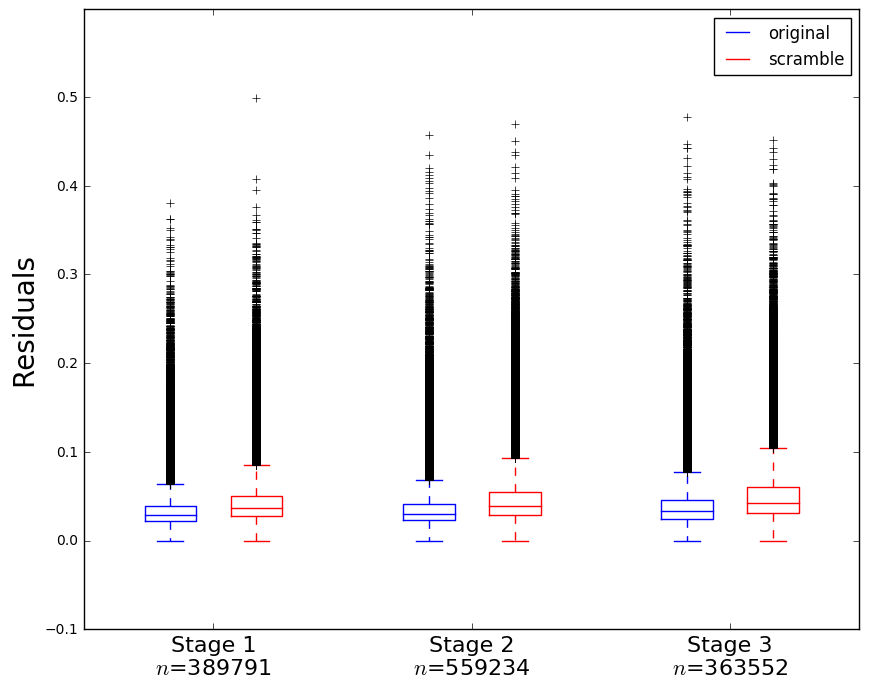

2.69159880898 2.69420903314
2.64843876481 2.6513103609
2.58072301194 2.58336904751


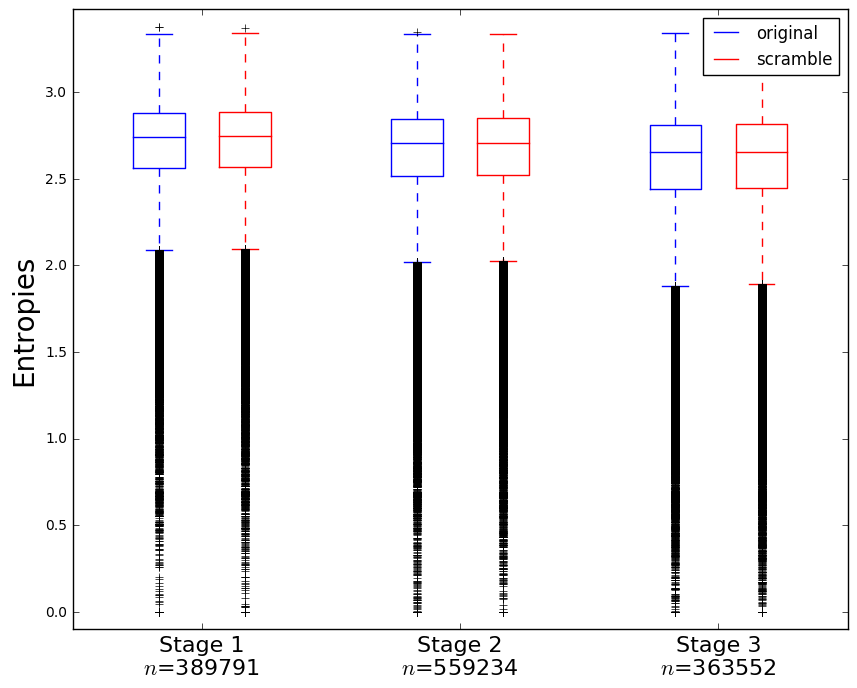

1.19932547289 1.20247322122
1.19579261006 1.19871544055
1.1863559596 1.1882223607


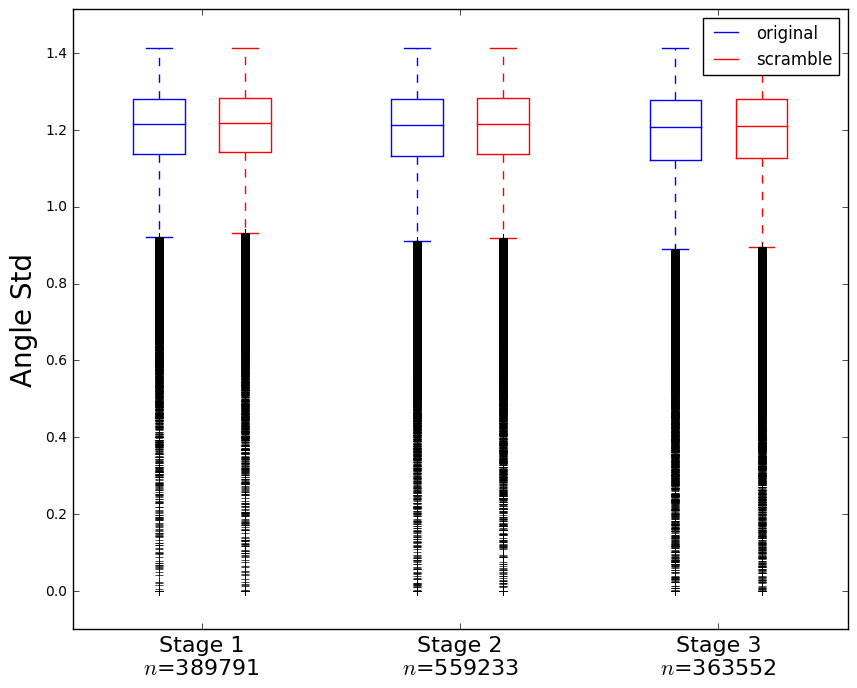

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 556660)  after:  556659
seed  200  length scramble entropy after:  556660
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.0331273739493 0.042721990479
0.0353278634842 0.0457036126736
0.0391590680762 0.0505883983267


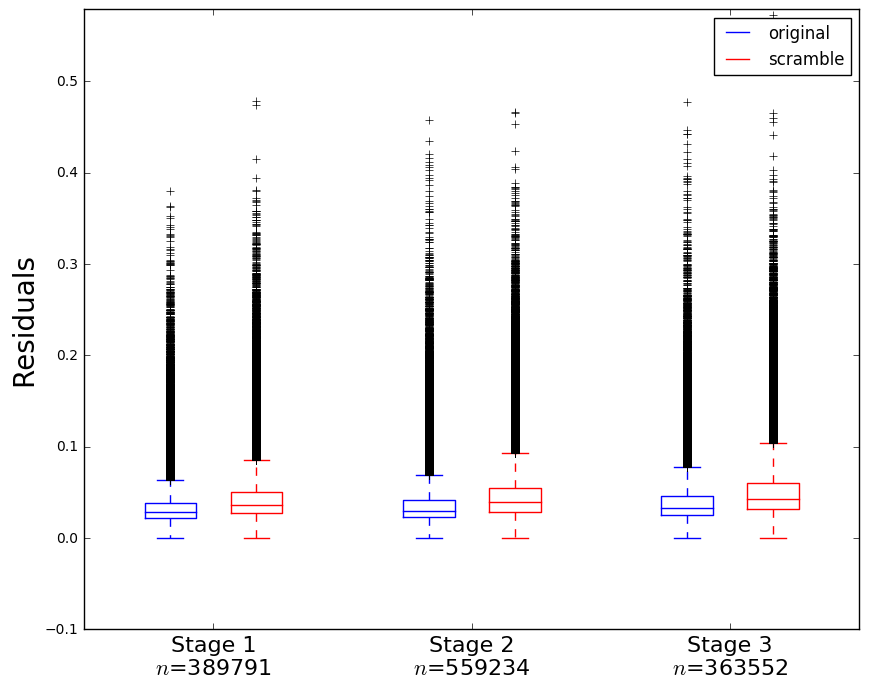

2.69159880898 2.69411150647
2.64843876481 2.65140680194
2.58072301194 2.58360515145


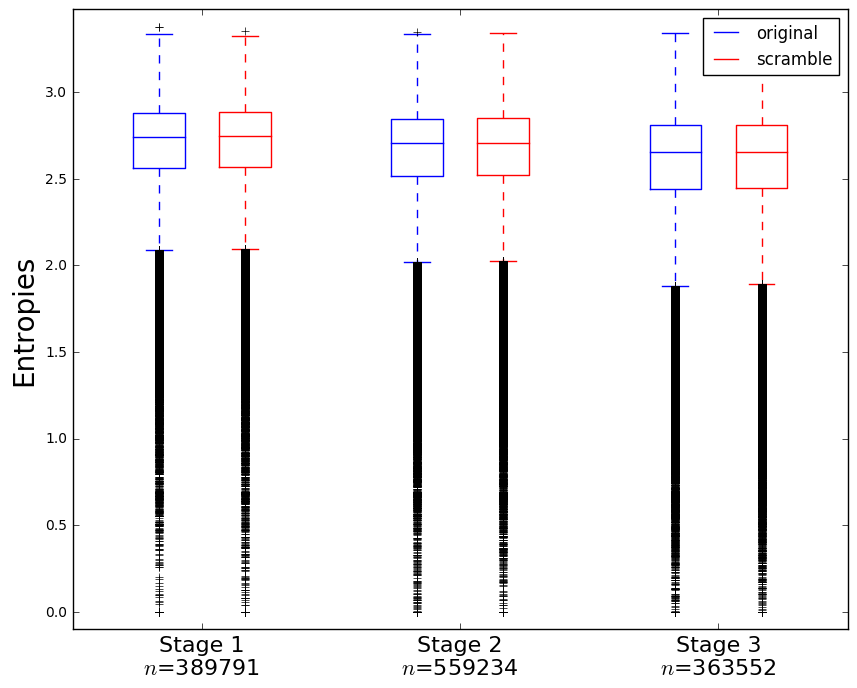

1.19932547289 1.20265666608
1.19579261006 1.19867161241
1.1863559596 1.18854770176


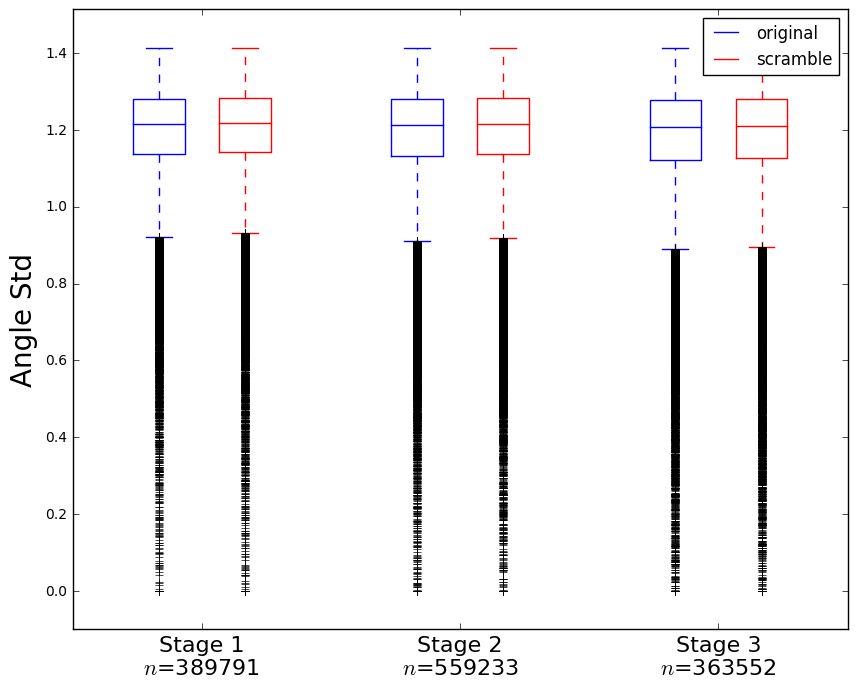

/home/lun5/Documents/multiplex/output/Entropy_radius_100_alpha_0.1_L1ratio_0.5
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559234)  after:  559233
length entropy after:  559234
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 558107)  after:  558106
seed  1  length scramble entropy after:  558107
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.0448668572117 0.0587012865195
0.0470113985418 0.0614036789257
0.0510862158934 0.0659944253305


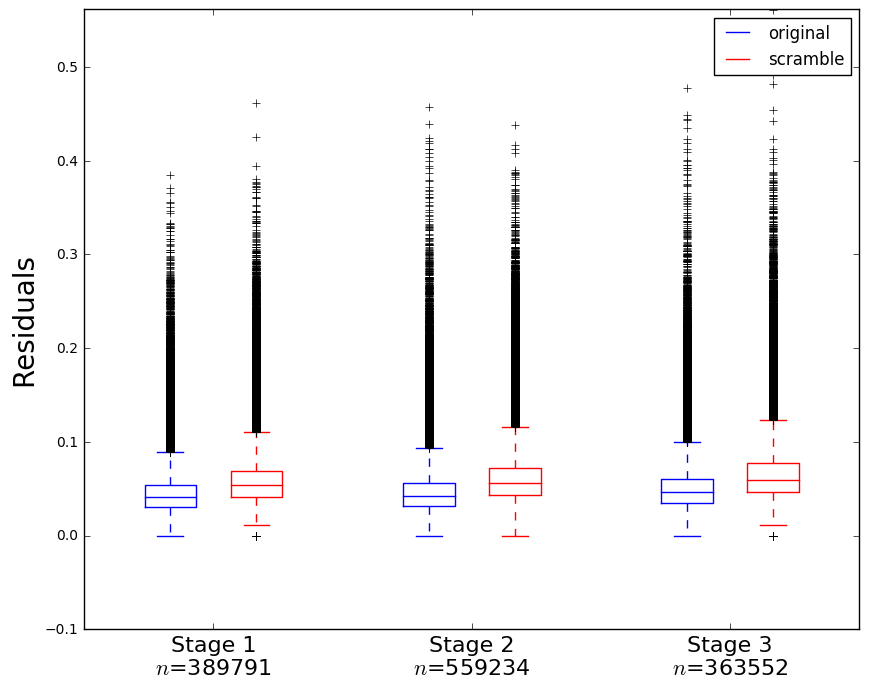

1.7941351696 1.82558960049
1.77174921909 1.82118859027
1.73876953577 1.81778695836


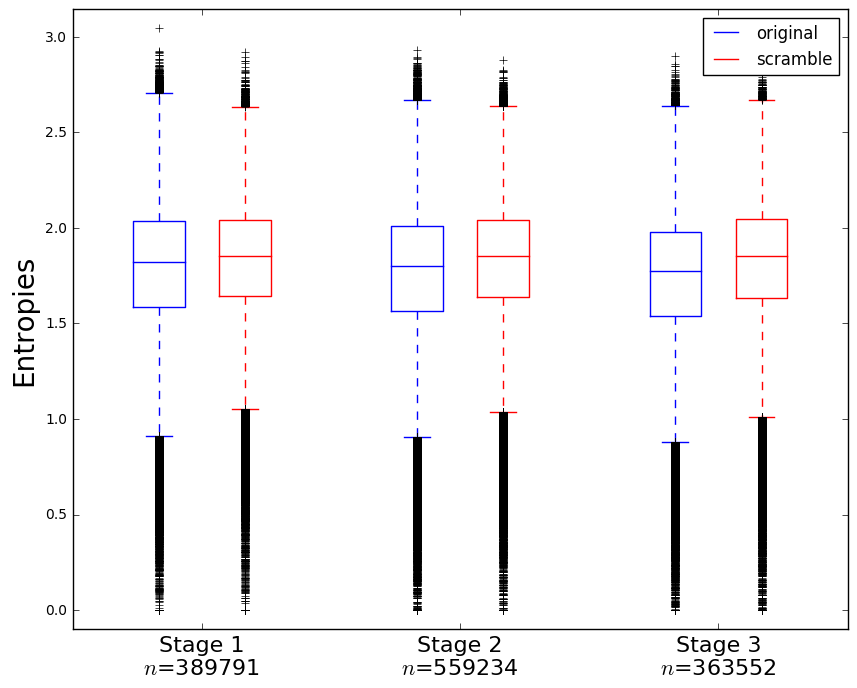

1.04205126007 1.06043475244
1.03955288216 1.06013759172
1.03328058719 1.05744754756


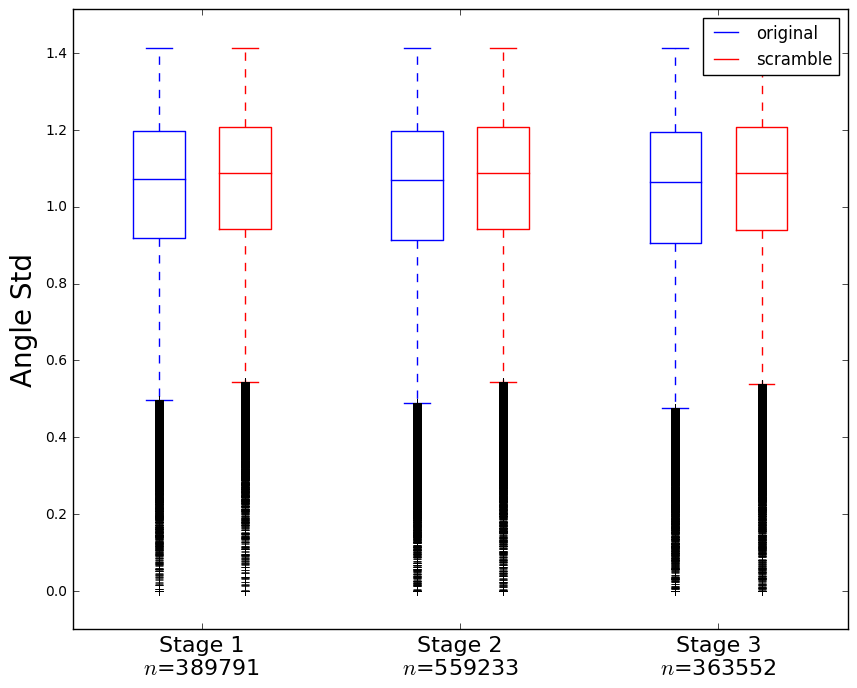

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 558346)  after:  558345
seed  50  length scramble entropy after:  558346
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.0448668572117 0.058686977403
0.0470113985418 0.0613862270689
0.0510862158934 0.065978129892


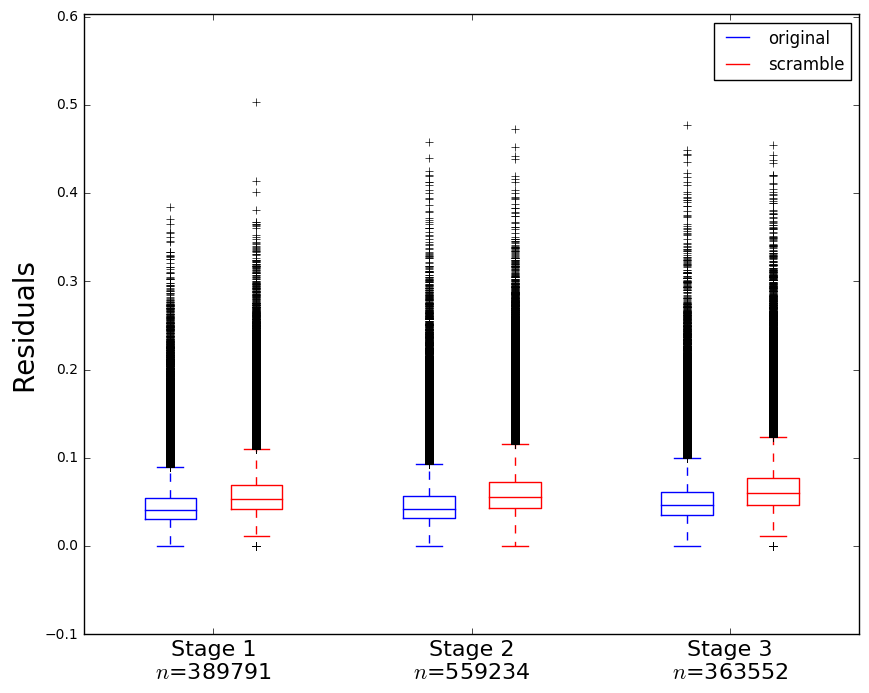

1.7941351696 1.82528544719
1.77174921909 1.8220087694
1.73876953577 1.81796860508


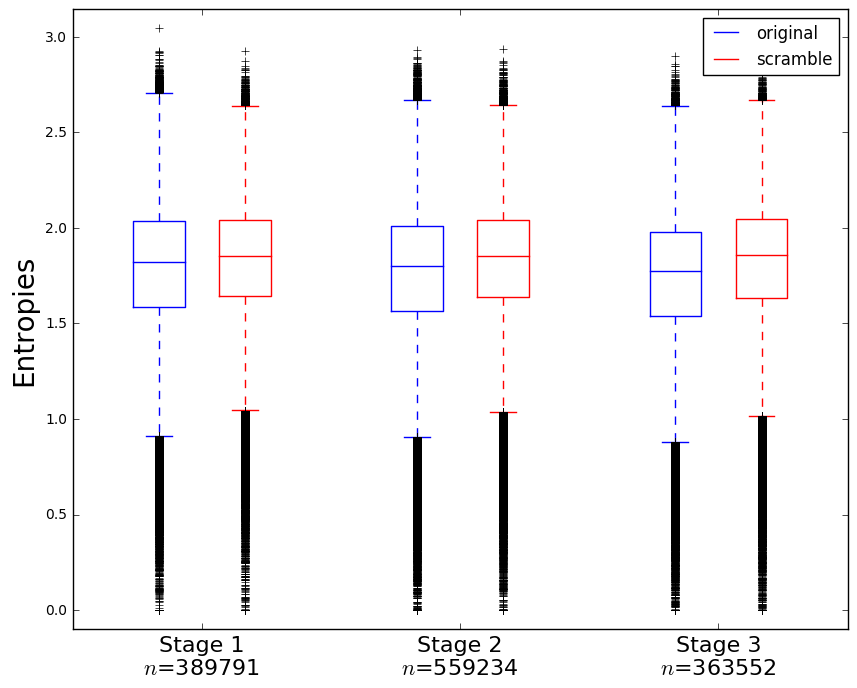

1.04205126007 1.05987028607
1.03955288216 1.06028690299
1.03328058719 1.05679967782


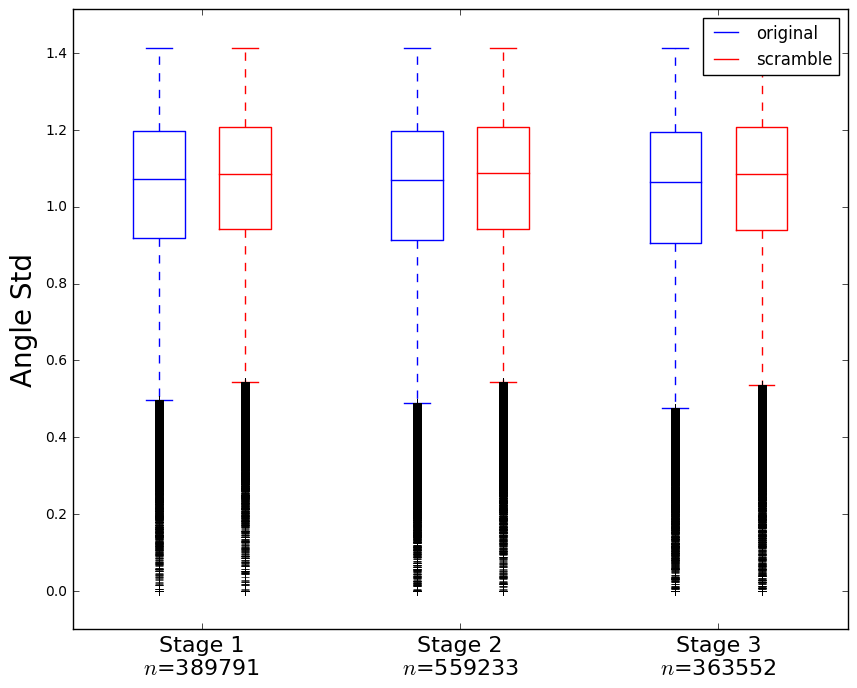

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 556660)  after:  556659
seed  200  length scramble entropy after:  556660
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.0448668572117 0.0586892058599
0.0470113985418 0.061395968772
0.0510862158934 0.0659950706575


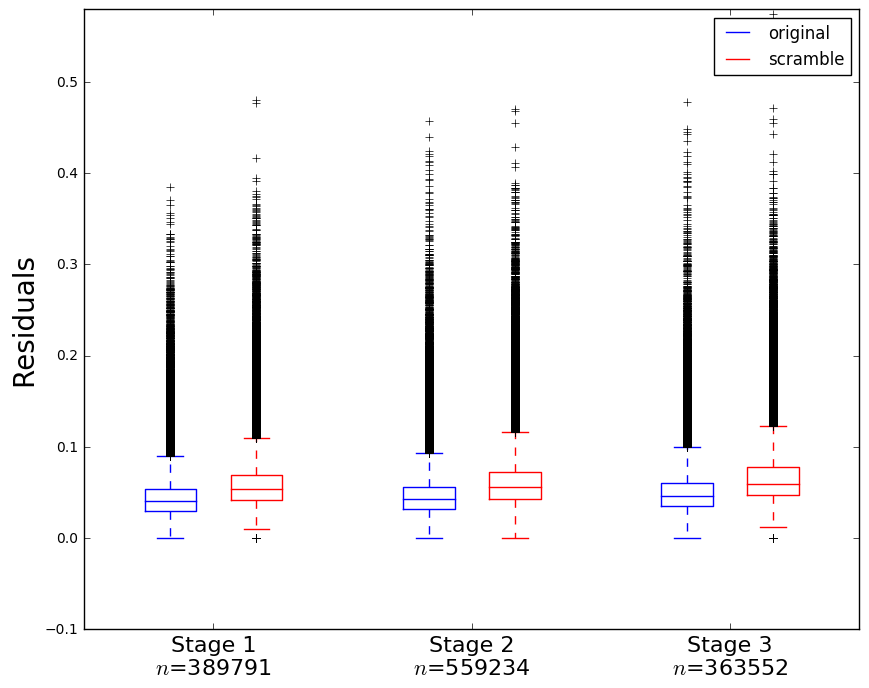

1.7941351696 1.82521741946
1.77174921909 1.82210570349
1.73876953577 1.81874365244


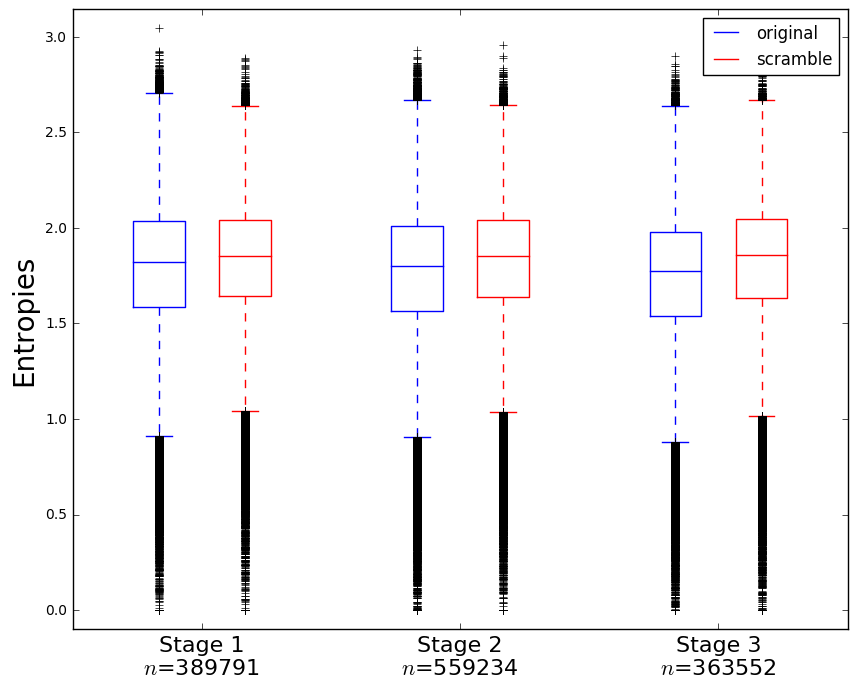

1.04205126007 1.06004217069
1.03955288216 1.06051807095
1.03328058719 1.05764873104


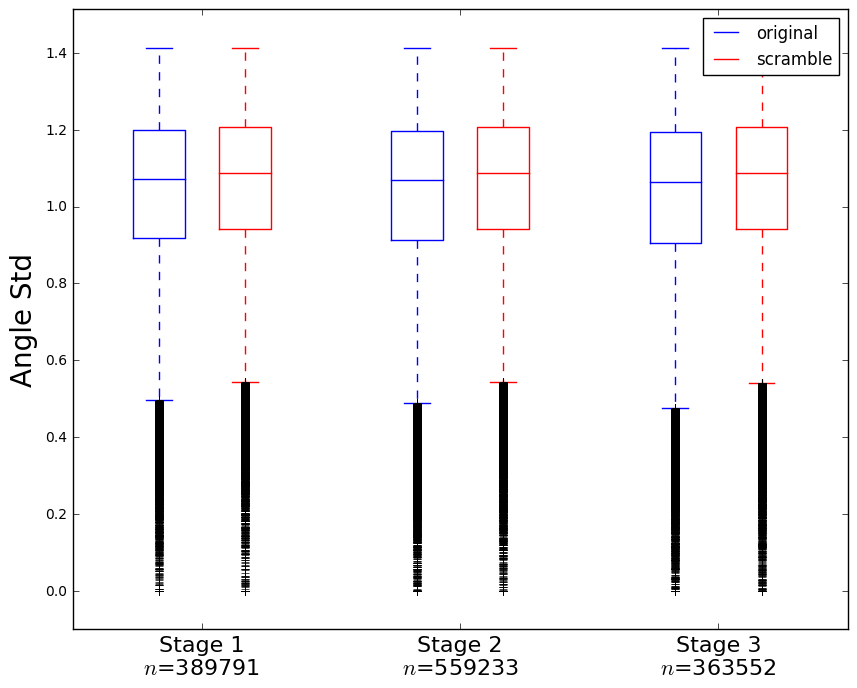

/home/lun5/Documents/multiplex/output/Entropy_radius_100_alpha_0.1_L1ratio_1
length angle std before:  (1, 389343)  after:  389342
length entropy after:  389343
length angle std before:  (1, 559206)  after:  559204
length entropy after:  559206
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 558107)  after:  558106
seed  1  length scramble entropy after:  558107
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.0477287924731 0.0645178554923
0.0499965088949 0.0675679936847
0.0545841774981 0.0729283624835


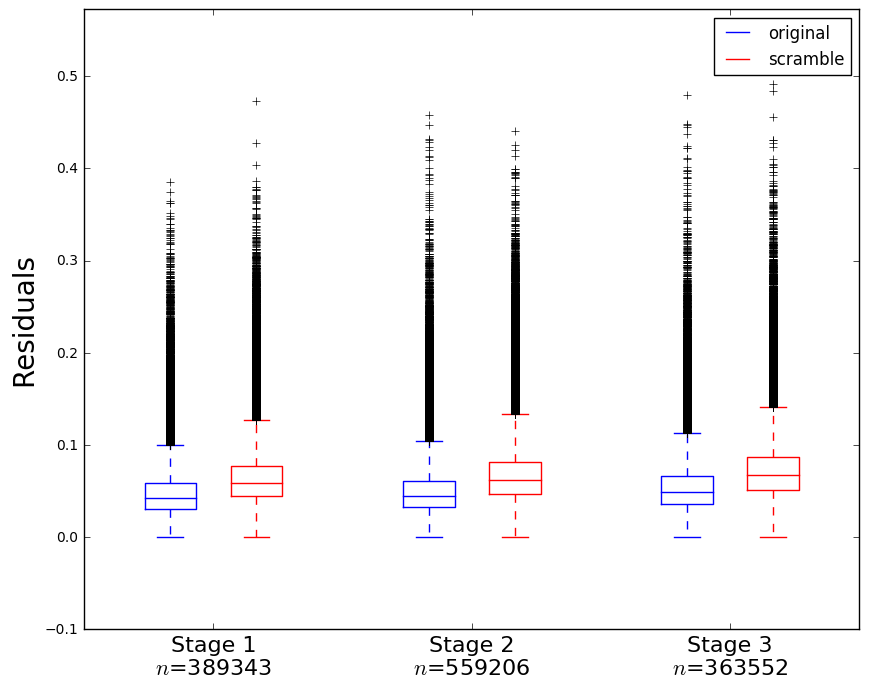

1.36753694046 1.42969589768
1.35949798727 1.4320846631
1.34923411024 1.44040742996


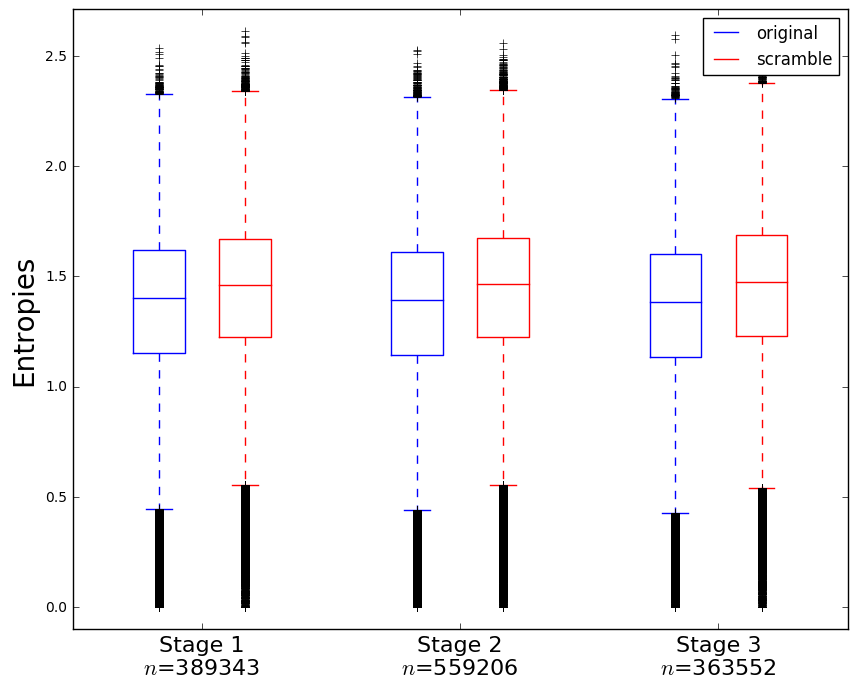

0.930979911938 0.955370161374
0.929772626256 0.957277284301
0.927505495733 0.957993241992


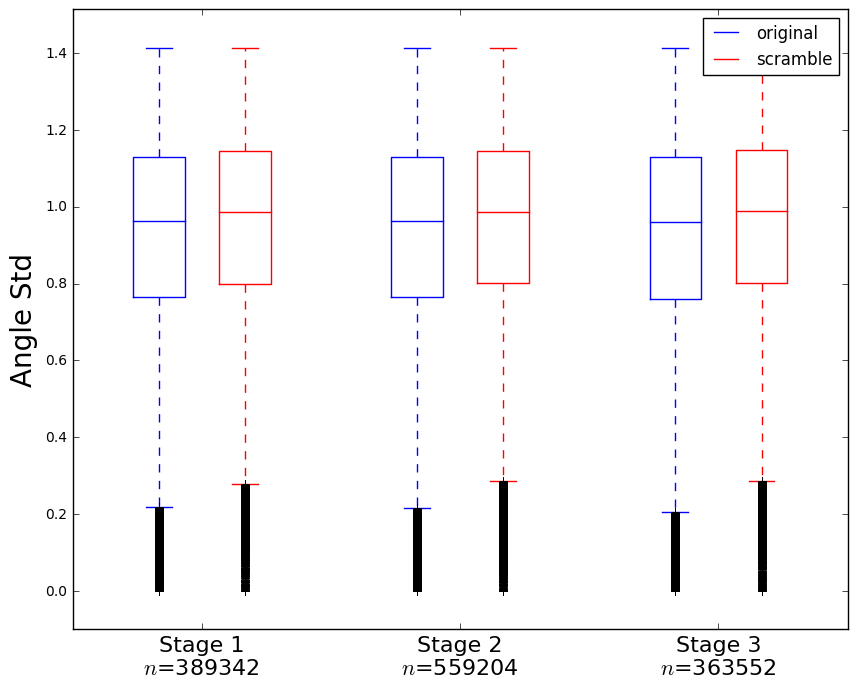

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 558346)  after:  558345
seed  50  length scramble entropy after:  558346
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.0477287924731 0.0644937418246
0.0499965088949 0.0675586924675
0.0545841774981 0.0729220624364


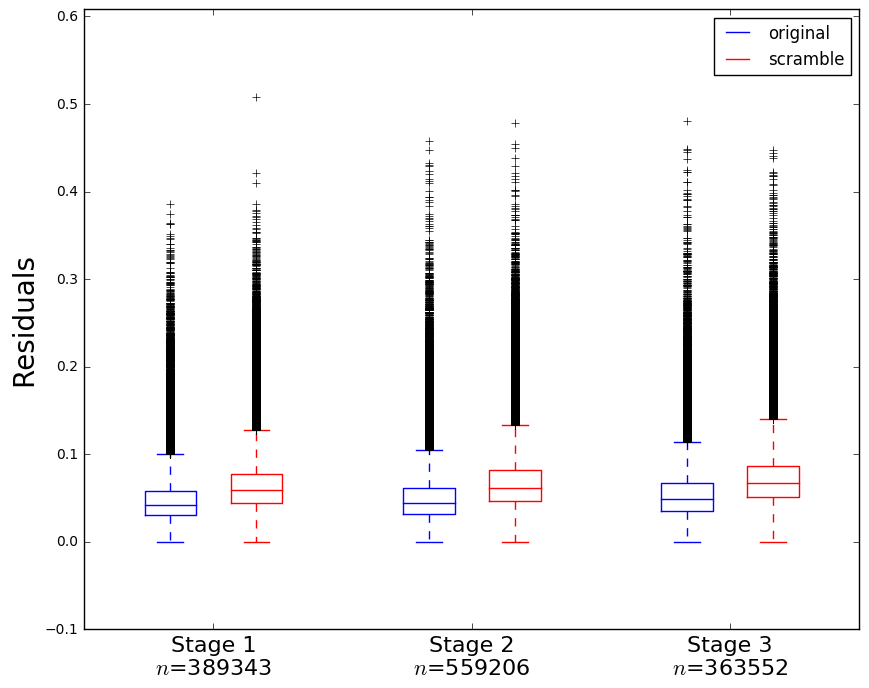

1.36753694046 1.43043588564
1.35949798727 1.43205305083
1.34923411024 1.44122475982


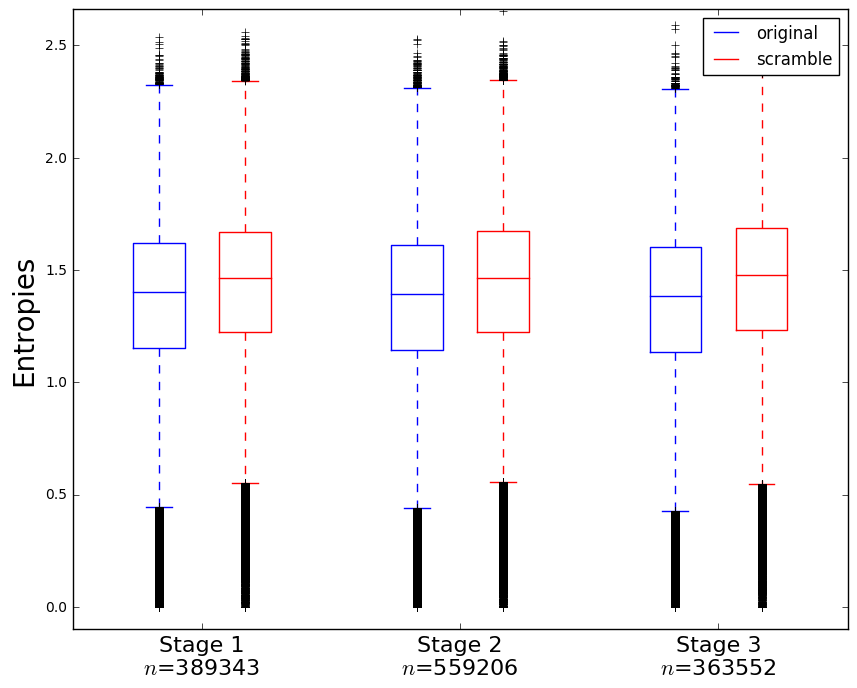

0.930979911938 0.955458104888
0.929772626256 0.956941842227
0.927505495733 0.957595527347


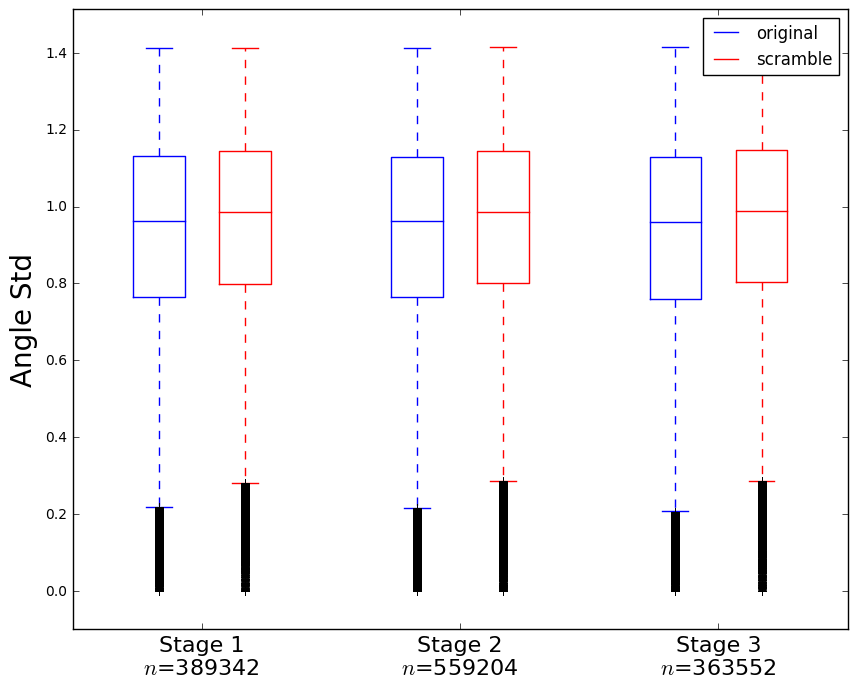

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 556660)  after:  556659
seed  200  length scramble entropy after:  556660
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.0477287924731 0.0645111051946
0.0499965088949 0.0675593040577
0.0545841774981 0.0729311644797


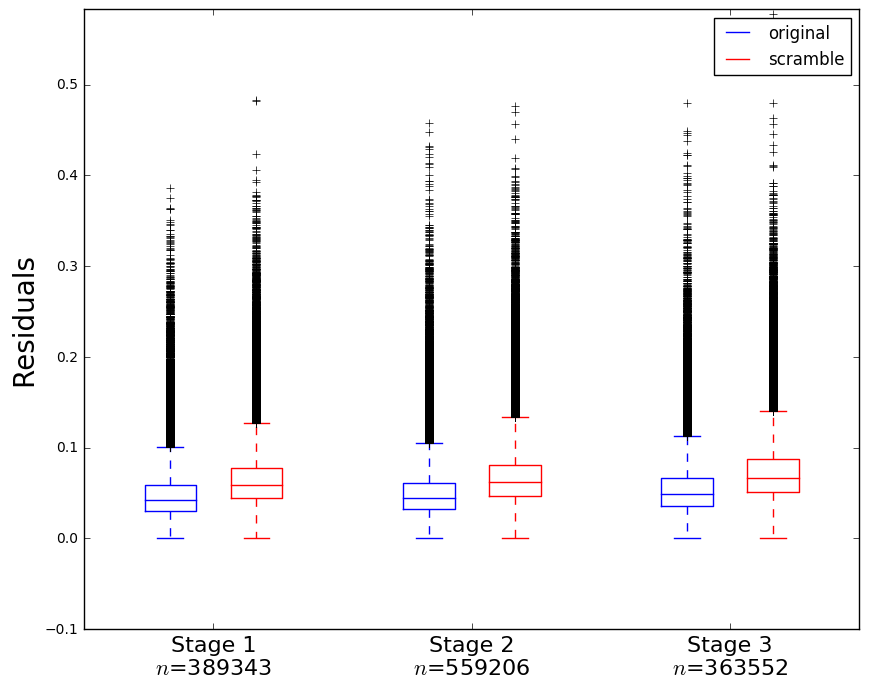

1.36753694046 1.43033975583
1.35949798727 1.4326064072
1.34923411024 1.44205570552


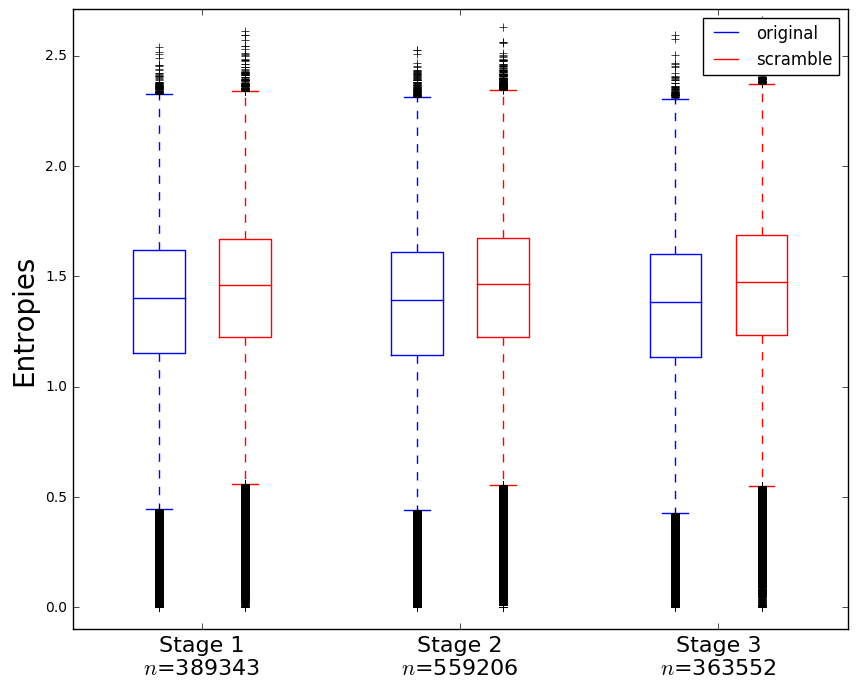

0.930979911938 0.955395794024
0.929772626256 0.957552723687
0.927505495733 0.958371319355


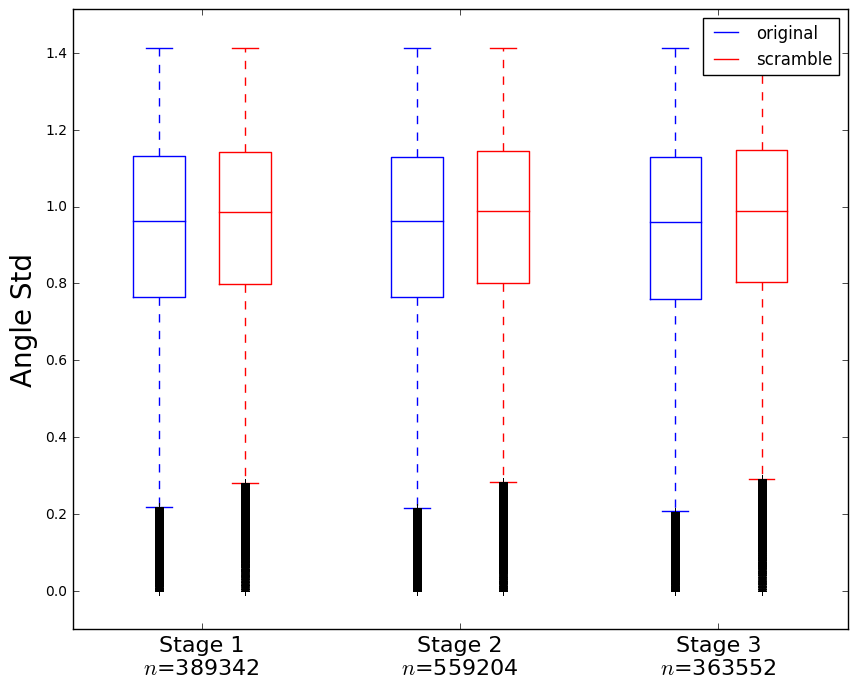

/home/lun5/Documents/multiplex/output/Entropy_radius_50_alpha_1_L1ratio_0
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559234)  after:  559233
length entropy after:  559234
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 558107)  after:  558106
seed  1  length scramble entropy after:  558107
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.0722038999152 0.10357612186
0.0751397494296 0.108872560086
0.081798509165 0.118629776639


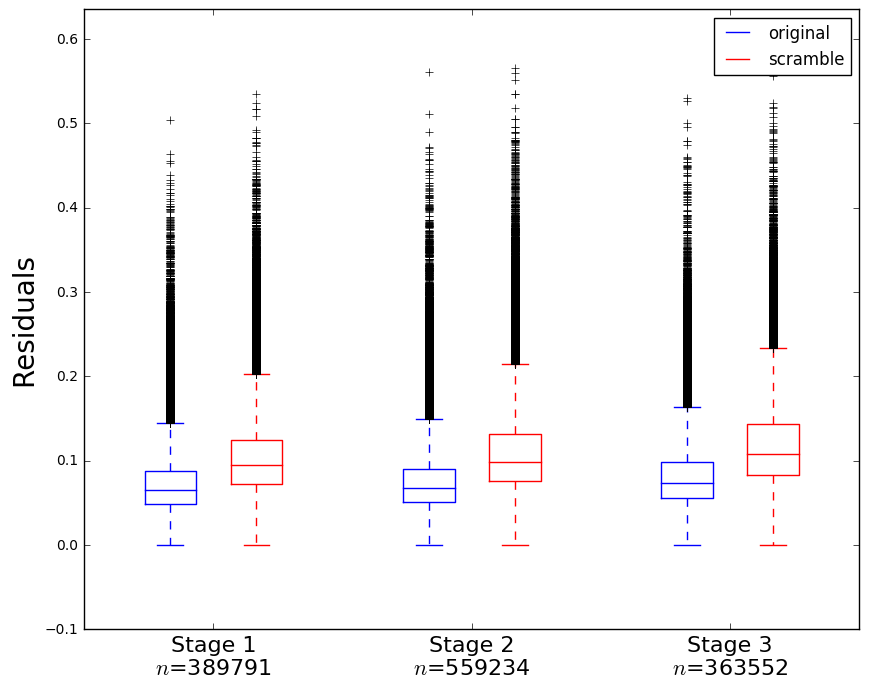

1.81819263652 1.72431940566
1.75397121642 1.65822695639
1.66665879123 1.57267964419


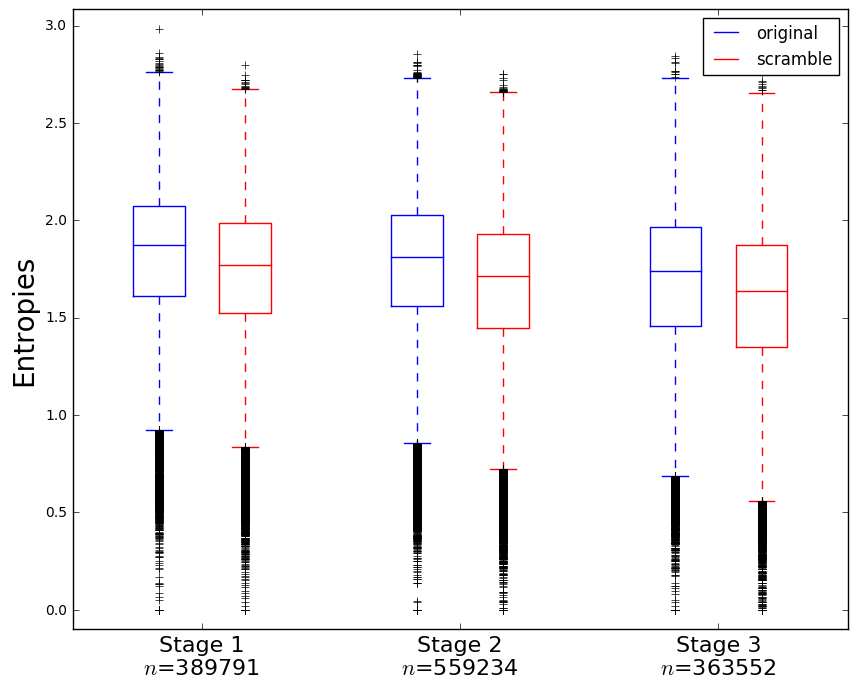

1.14445644861 1.11111249677
1.12909090333 1.0929315733
1.10225992981 1.06459580382


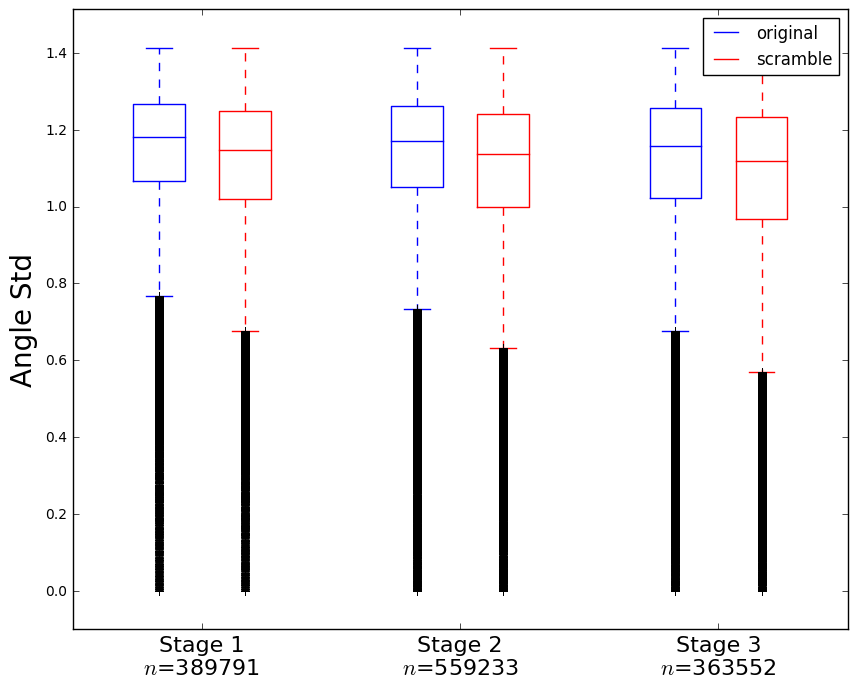

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 558346)  after:  558345
seed  50  length scramble entropy after:  558346
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.0722038999152 0.103624462766
0.0751397494296 0.108868730923
0.081798509165 0.118617362166


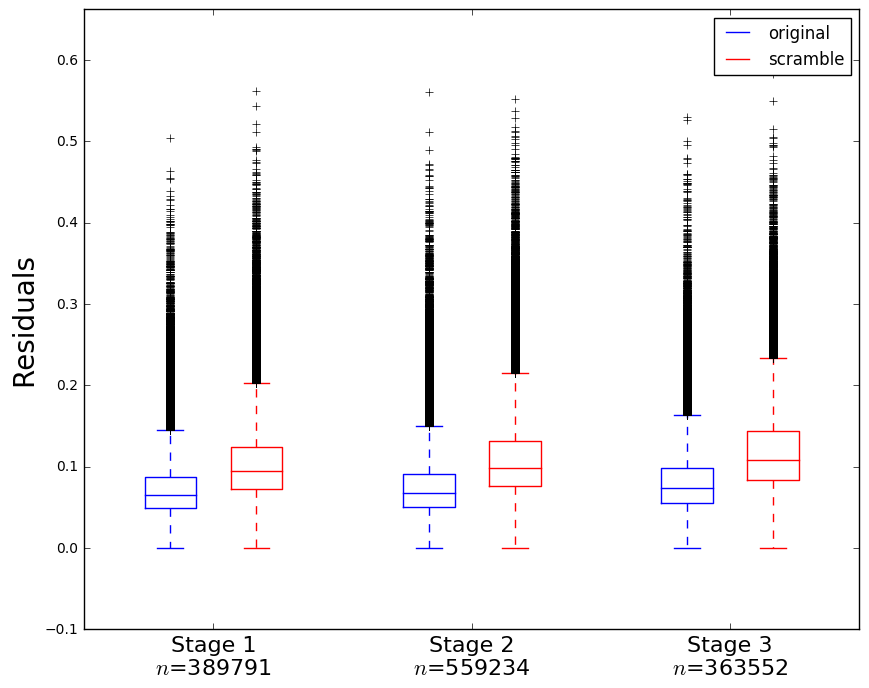

1.81819263652 1.72486591056
1.75397121642 1.65883071491
1.66665879123 1.57264581691


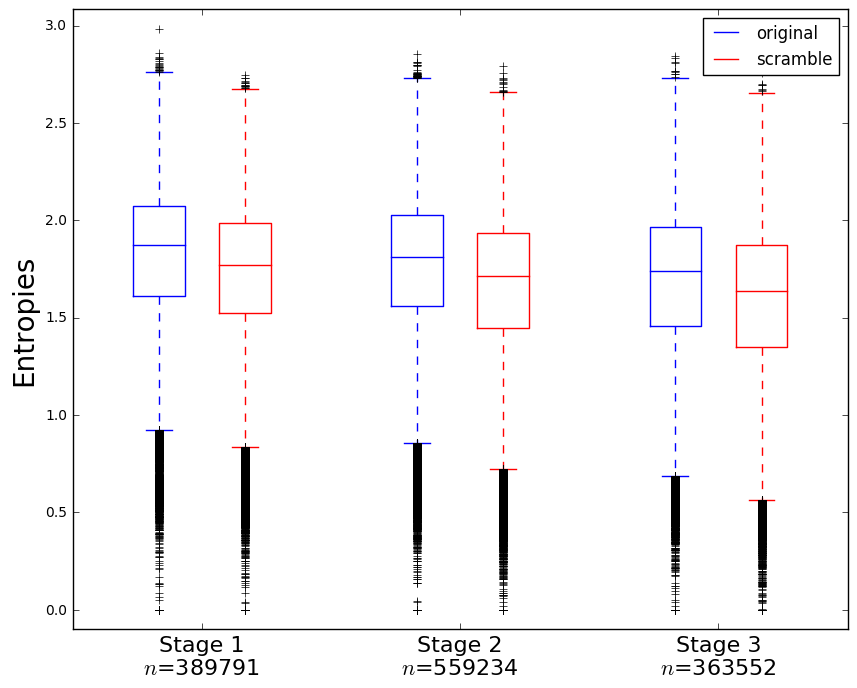

1.14445644861 1.1110520433
1.12909090333 1.09341786623
1.10225992981 1.06524573666


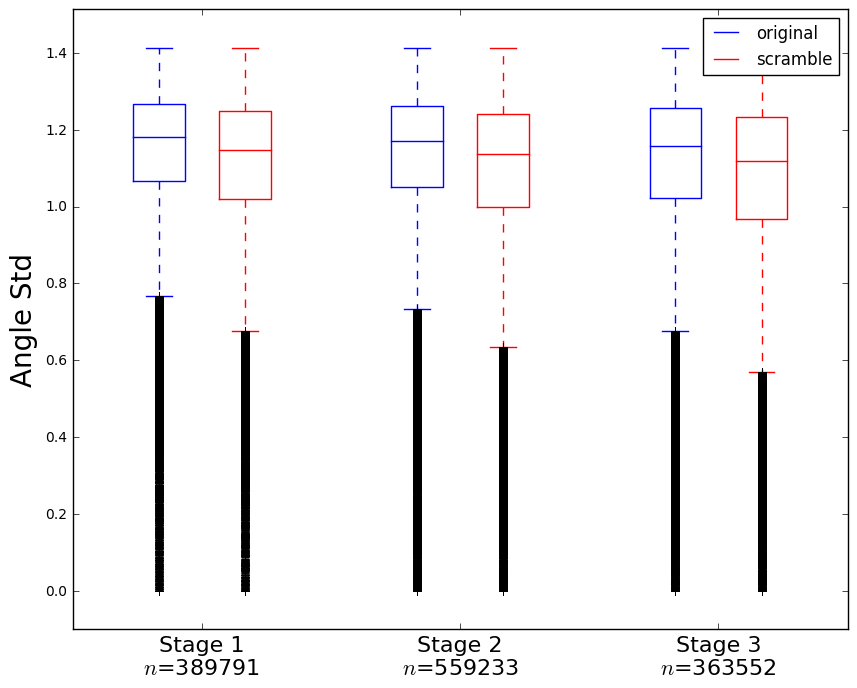

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 556660)  after:  556659
seed  200  length scramble entropy after:  556660
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.0722038999152 0.103643077528
0.0751397494296 0.108818243473
0.081798509165 0.118629156936


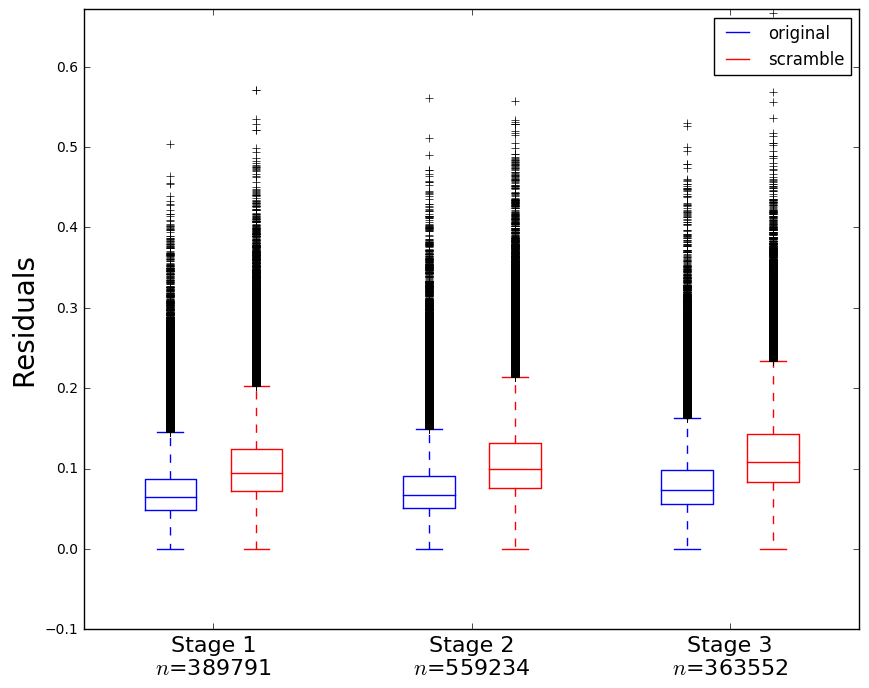

1.81819263652 1.7245500989
1.75397121642 1.6584793901
1.66665879123 1.57283015509


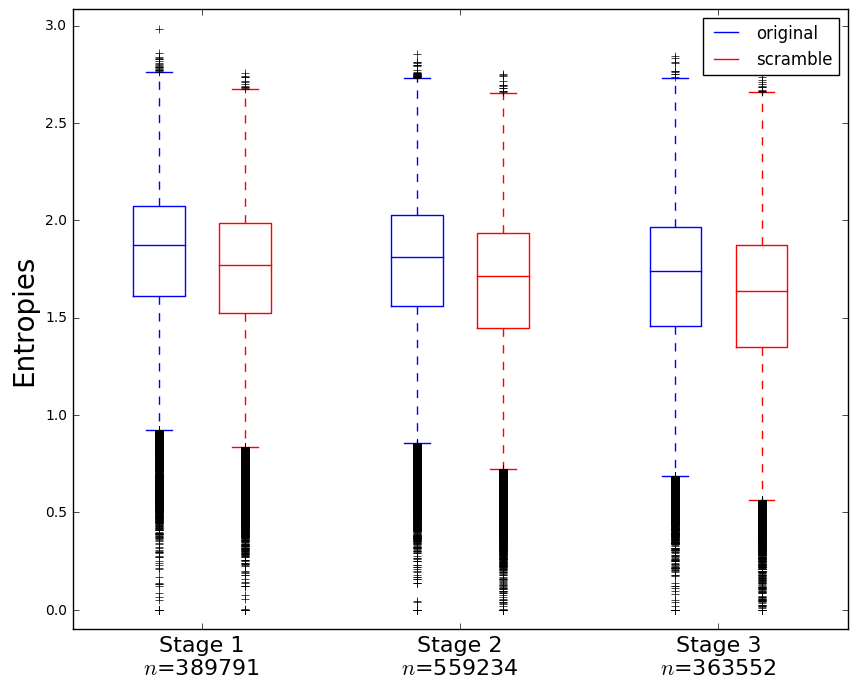

1.14445644861 1.11133582842
1.12909090333 1.09327417743
1.10225992981 1.06490712926


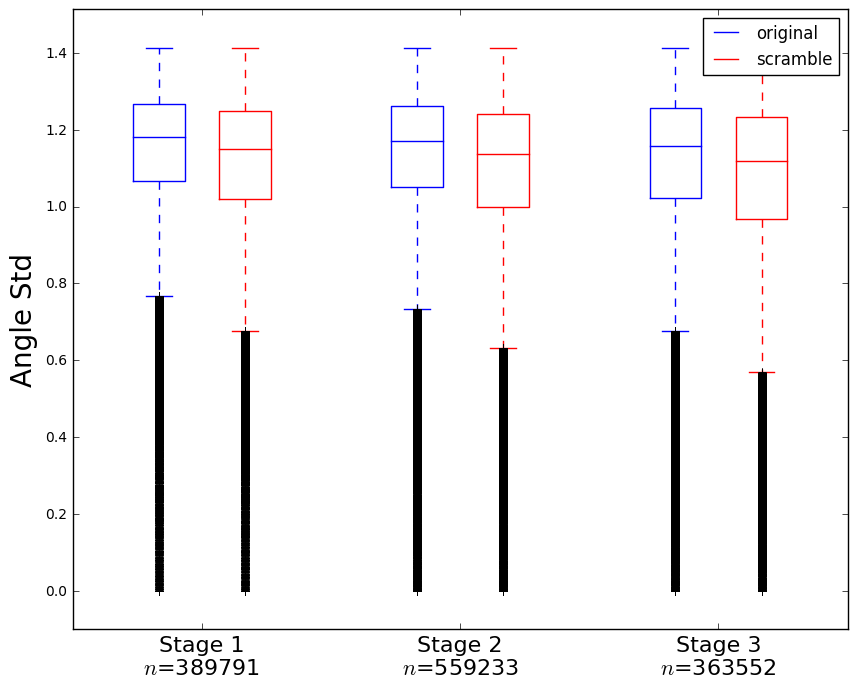

/home/lun5/Documents/multiplex/output/Entropy_radius_50_alpha_1_L1ratio_0.5
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559128)  after:  559125
length entropy after:  559128
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 551681)  after:  551674
seed  1  length scramble entropy after:  551681
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.0825094701615 0.111613171737
0.0844098057994 0.116262442413
0.0894242039435 0.124987609788


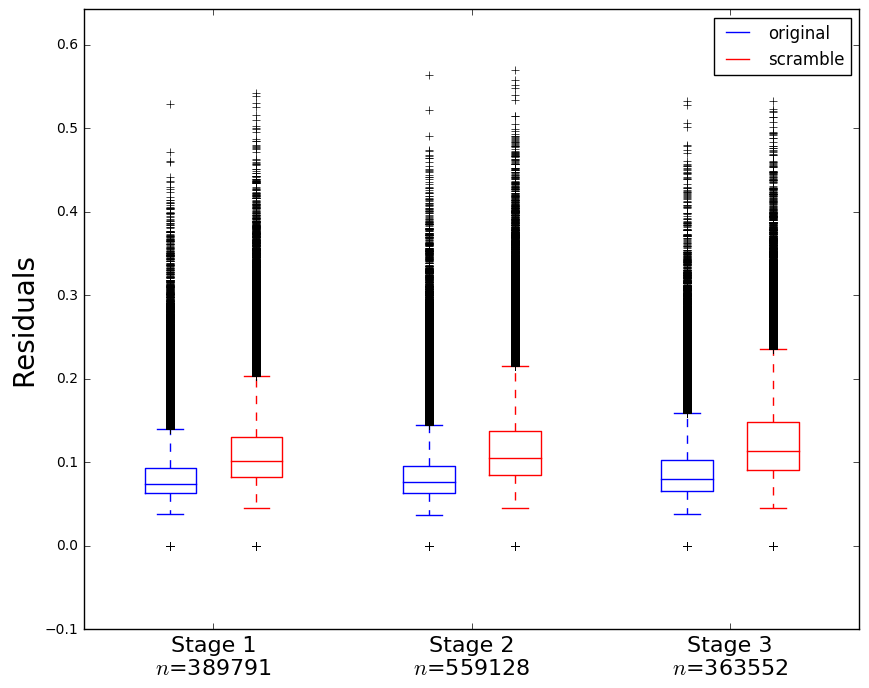

1.59152204616 1.38189033379
1.53435980284 1.32107433191
1.45229590974 1.24297948719


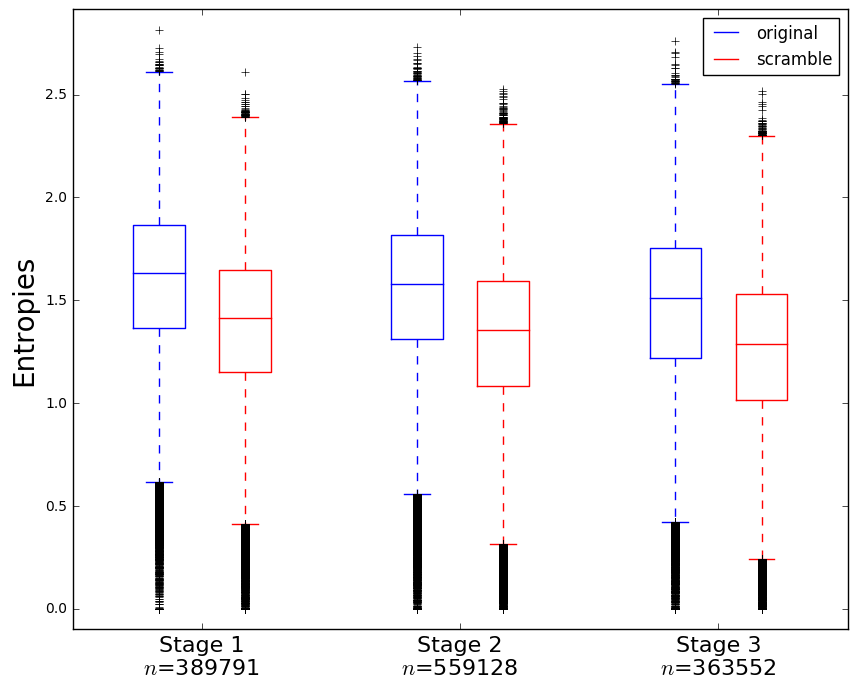

1.07811567992 1.00948628709
1.06198028324 0.9879073899
1.03339312089 0.95692629266


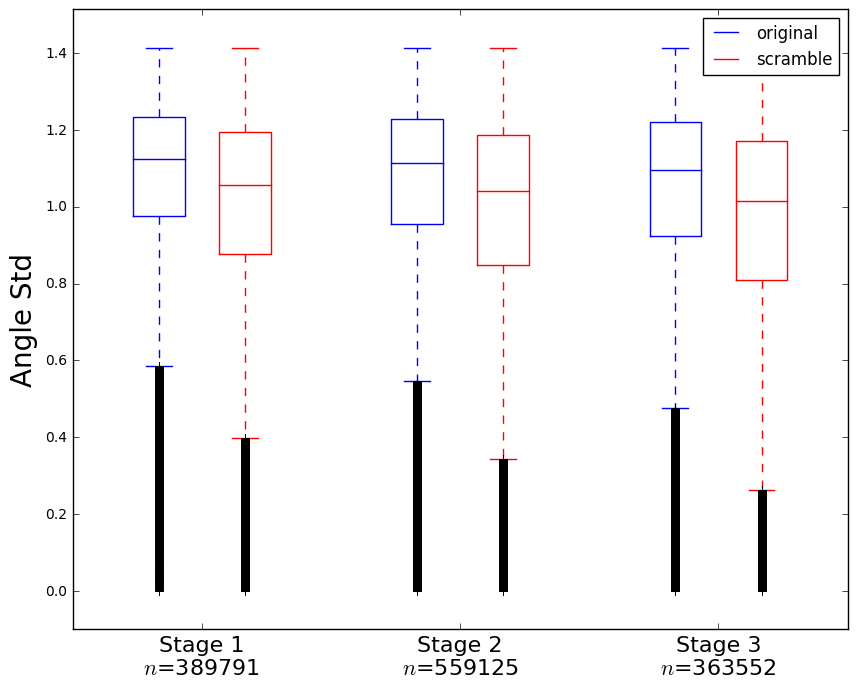

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 555426)  after:  555420
seed  50  length scramble entropy after:  555426
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.0825094701615 0.111659137739
0.0844098057994 0.11620137847
0.0894242039435 0.124968685946


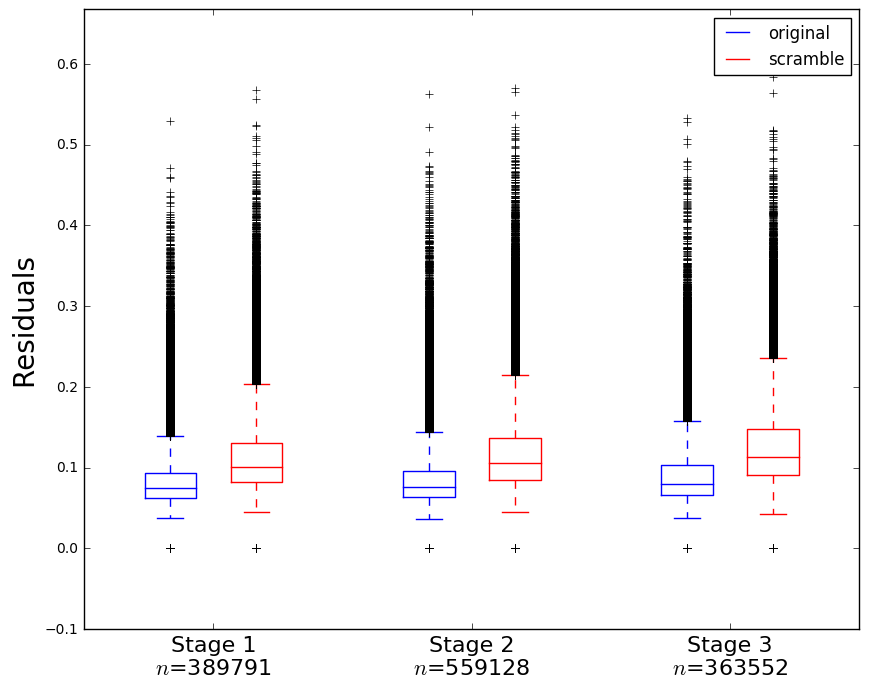

1.59152204616 1.38215523508
1.53435980284 1.32249638881
1.45229590974 1.24337082385


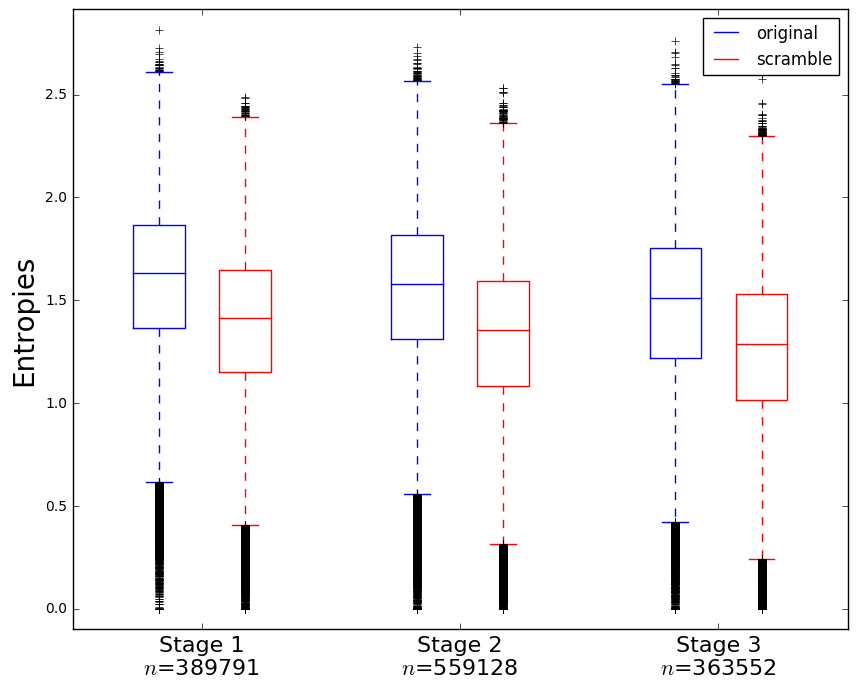

1.07811567992 1.00931290446
1.06198028324 0.988916345378
1.03339312089 0.957599572319


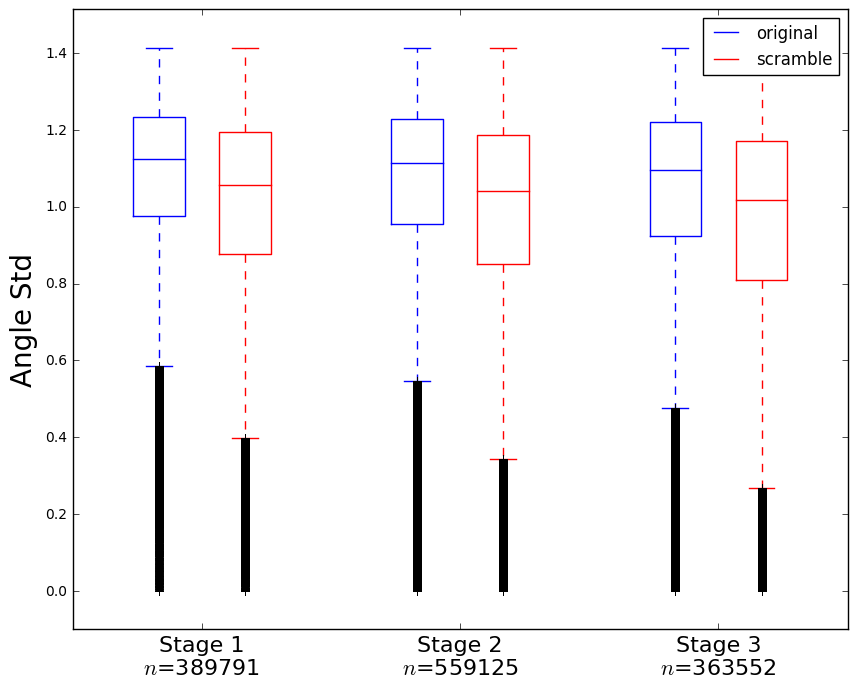

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 554965)  after:  554962
seed  200  length scramble entropy after:  554965
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.0825094701615 0.111681056257
0.0844098057994 0.116095106012
0.0894242039435 0.124988072636


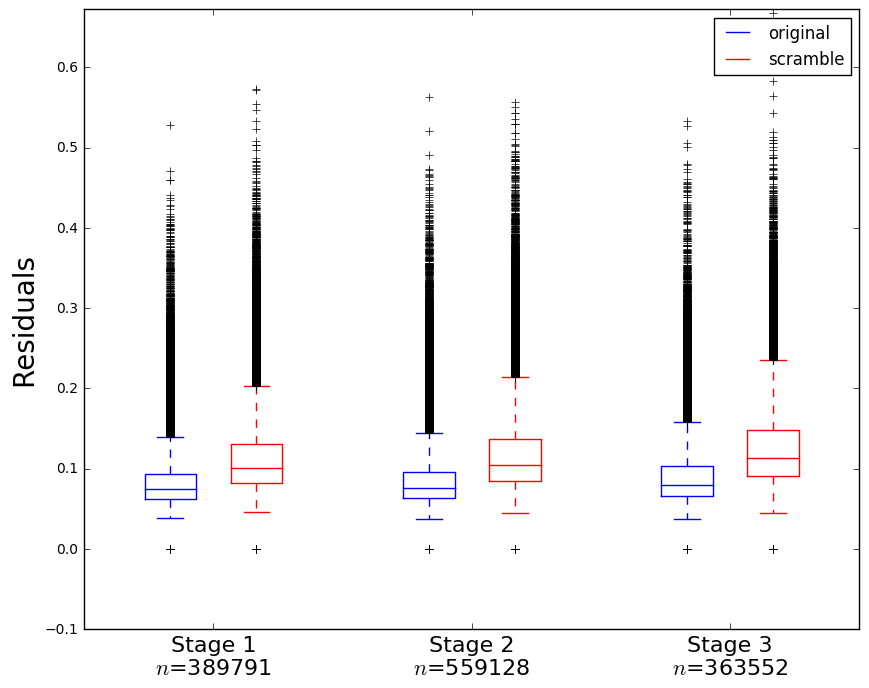

1.59152204616 1.38199059229
1.53435980284 1.32202284521
1.45229590974 1.24323722592


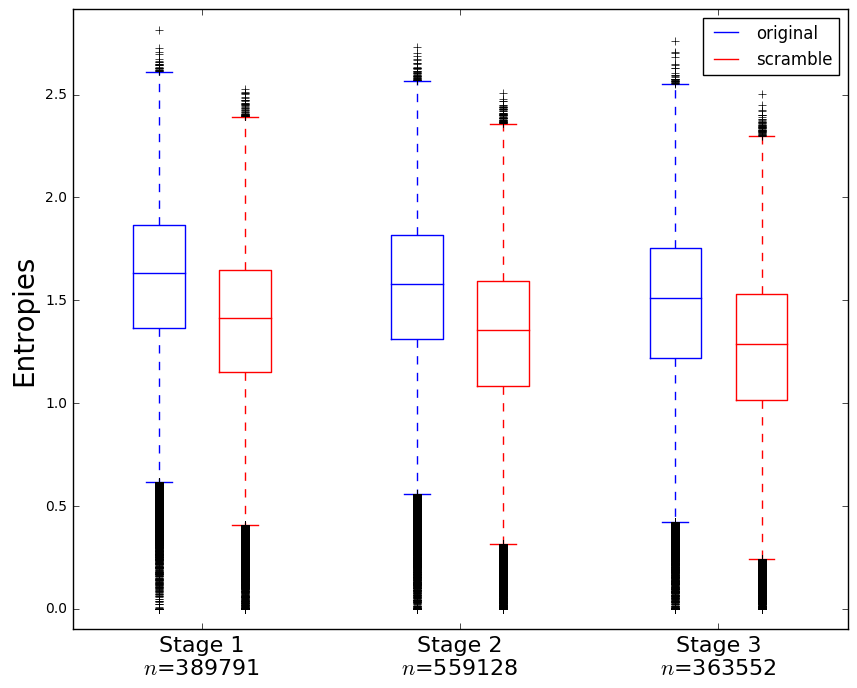

1.07811567992 1.00991129661
1.06198028324 0.988762331344
1.03339312089 0.957151719116


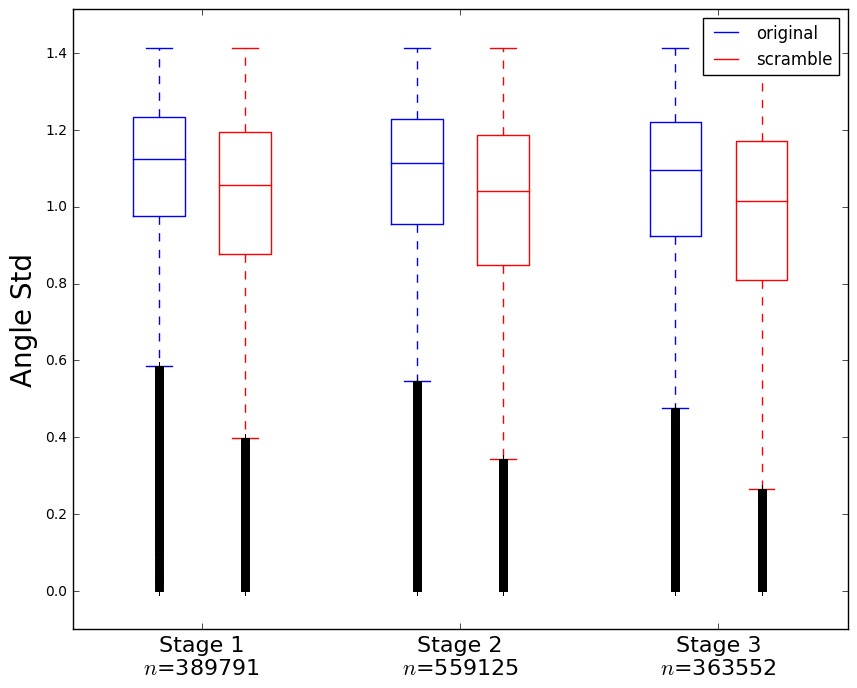

/home/lun5/Documents/multiplex/output/Entropy_radius_50_alpha_1_L1ratio_1
length angle std before:  (1, 389213)  after:  389212
length entropy after:  389213
length angle std before:  (1, 558222)  after:  558215
length entropy after:  558222
length angle std before:  (1, 360648)  after:  360645
length entropy after:  360648
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 547643)  after:  547634
seed  1  length scramble entropy after:  547643
seed  1  length scramble angle std. Before:  (1, 362509)  after:  362508
seed  1  length scramble entropy after:  362509
0.102547586931 0.127348636431
0.102940909932 0.130538801241
0.105275918591 0.136987781158


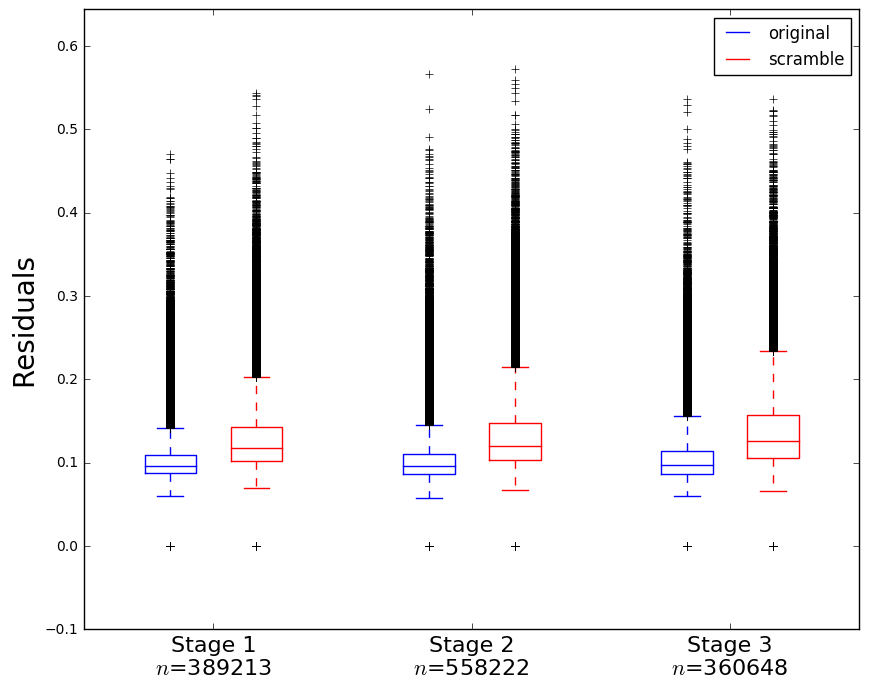

0.732078567714 0.747229130199
0.717558509452 0.724840489512
0.720569879145 0.721809584795


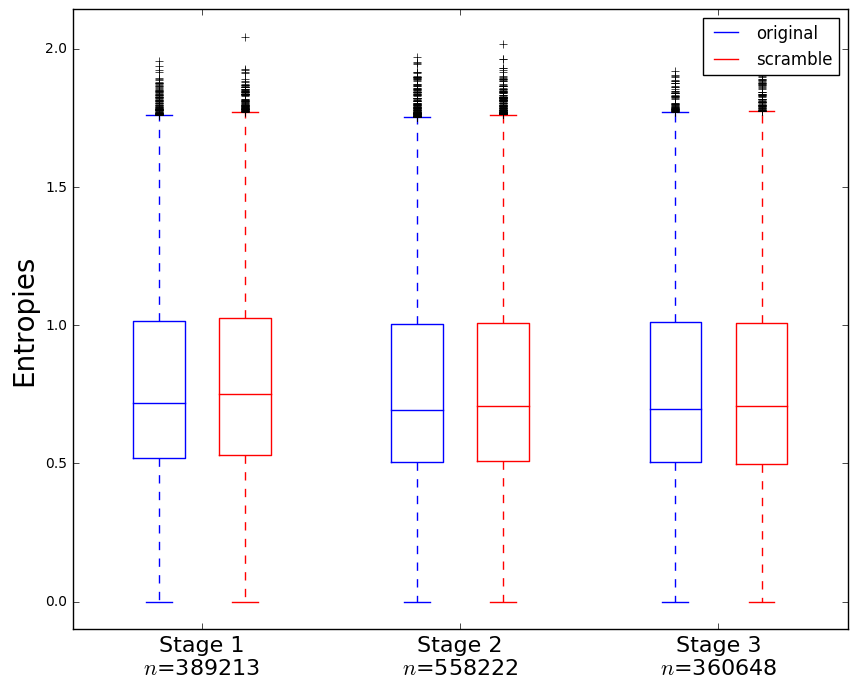

0.690094589802 0.701238369355
0.682289604562 0.687023169453
0.683927897737 0.686228123829


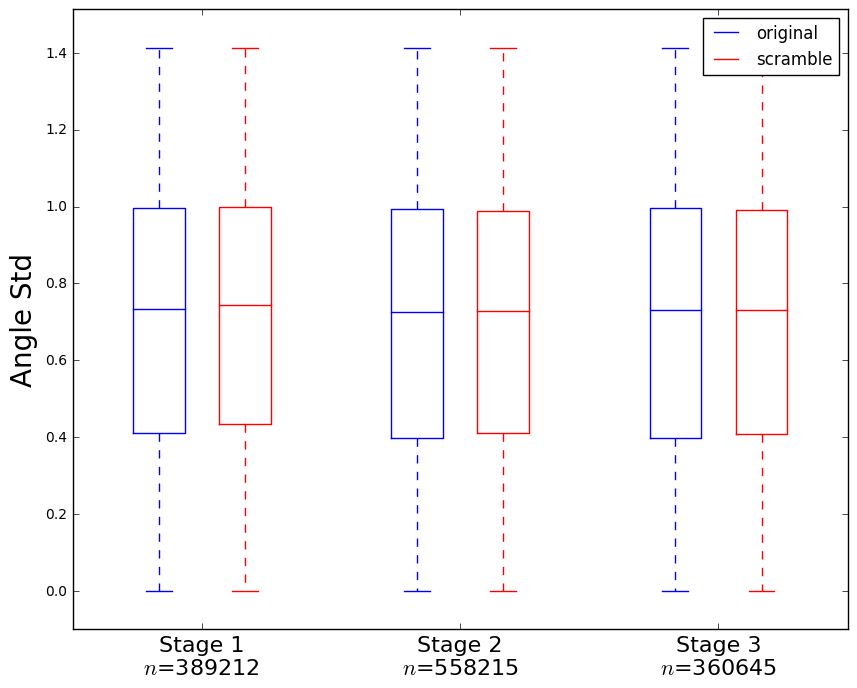

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 552154)  after:  552146
seed  50  length scramble entropy after:  552154
seed  50  length scramble angle std. Before:  (1, 360907)  after:  360905
seed  50  length scramble entropy after:  360907
0.102547586931 0.127387081902
0.102940909932 0.130496518721
0.105275918591 0.1369749291


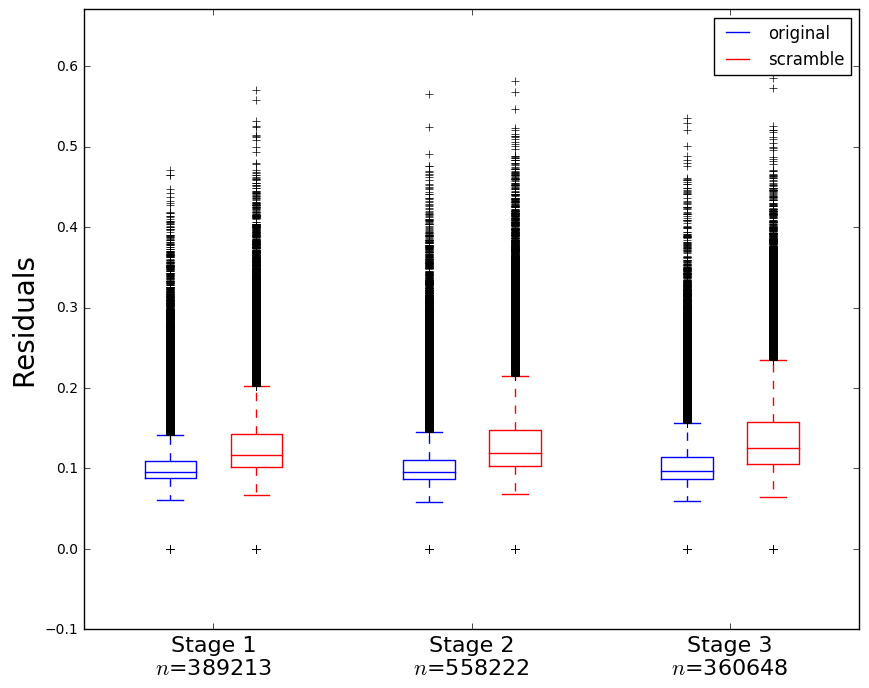

0.732078567714 0.747213340011
0.717558509452 0.725033677743
0.720569879145 0.723050355329


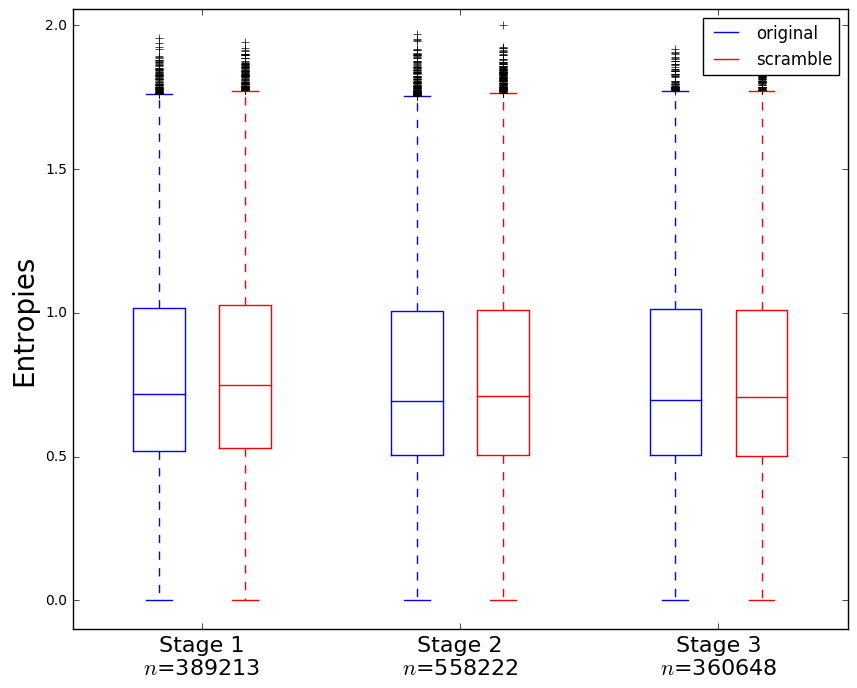

0.690094589802 0.700089301626
0.682289604562 0.687921962368
0.683927897737 0.686511190791


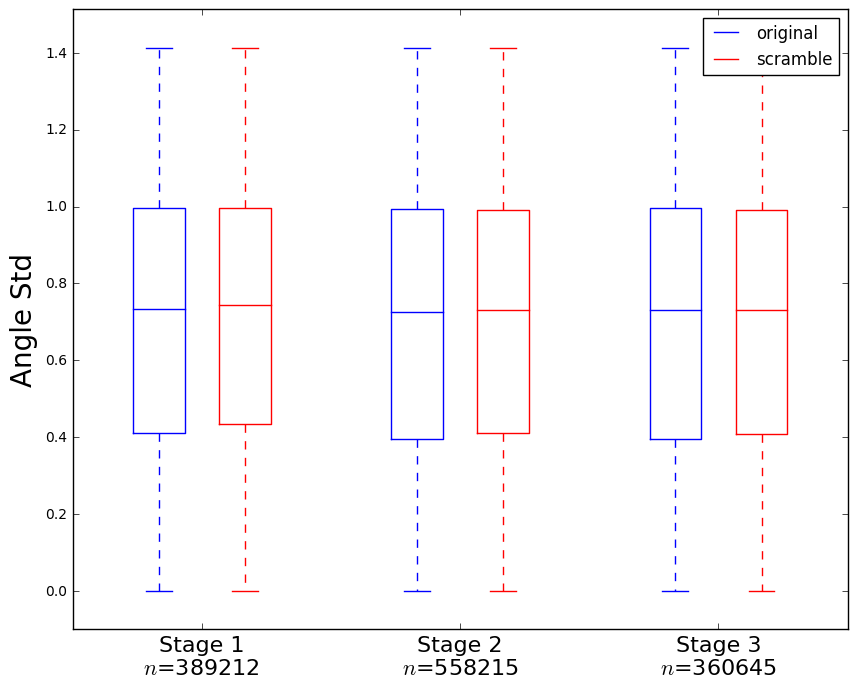

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 549551)  after:  549543
seed  200  length scramble entropy after:  549551
seed  200  length scramble angle std. Before:  (1, 361338)  after:  361336
seed  200  length scramble entropy after:  361338
0.102547586931 0.127407091371
0.102940909932 0.13042205996
0.105275918591 0.136991932538


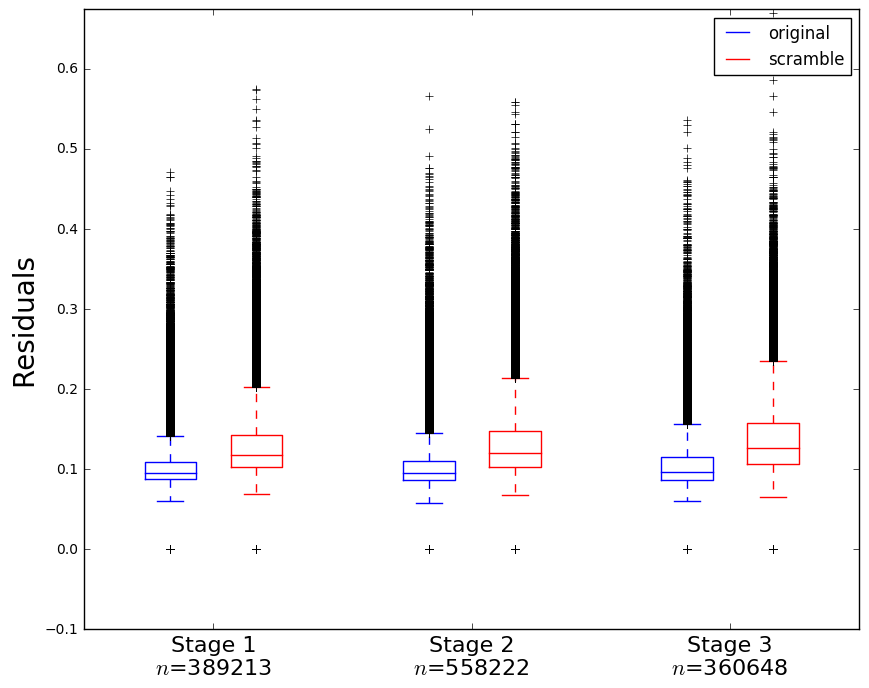

0.732078567714 0.747921445199
0.717558509452 0.724121254128
0.720569879145 0.722034184736


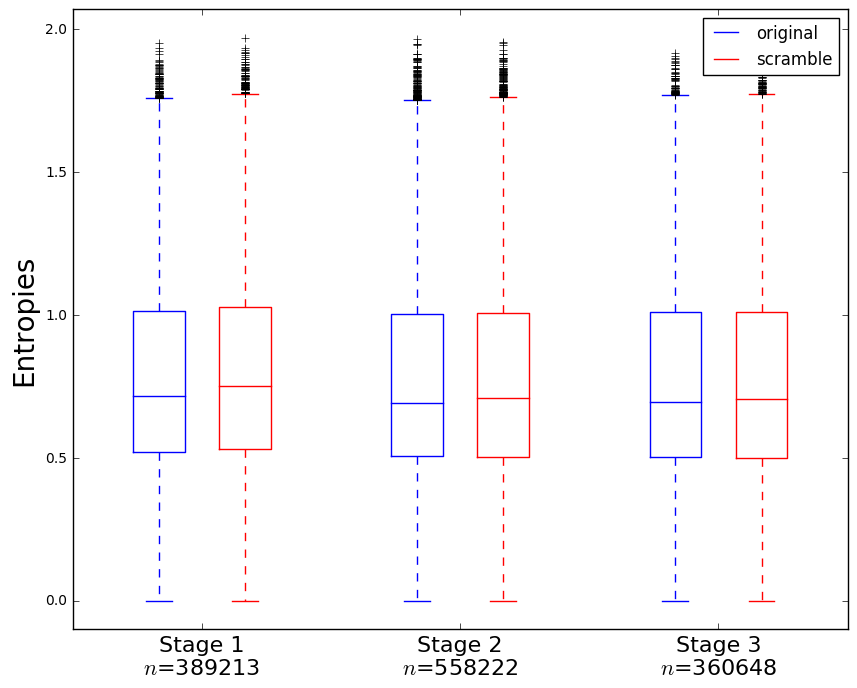

0.690094589802 0.701543126496
0.682289604562 0.687031823565
0.683927897737 0.685837912244


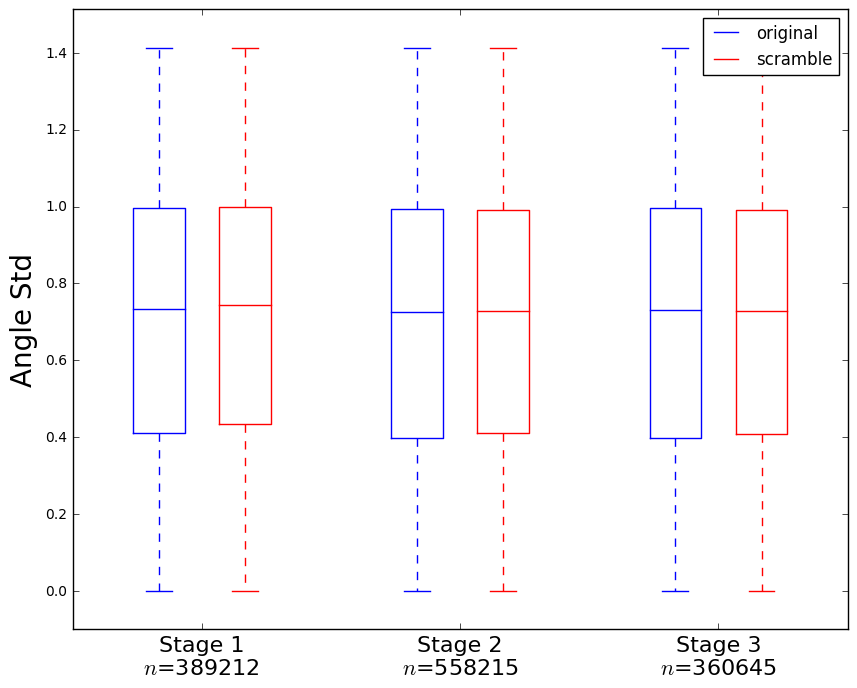

/home/lun5/Documents/multiplex/output/Entropy_radius_100_alpha_1_L1ratio_0
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559234)  after:  559233
length entropy after:  559234
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 558107)  after:  558106
seed  1  length scramble entropy after:  558107
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.0542534920145 0.0687471376939
0.0566704529211 0.071980866855
0.061331962296 0.0776408458846


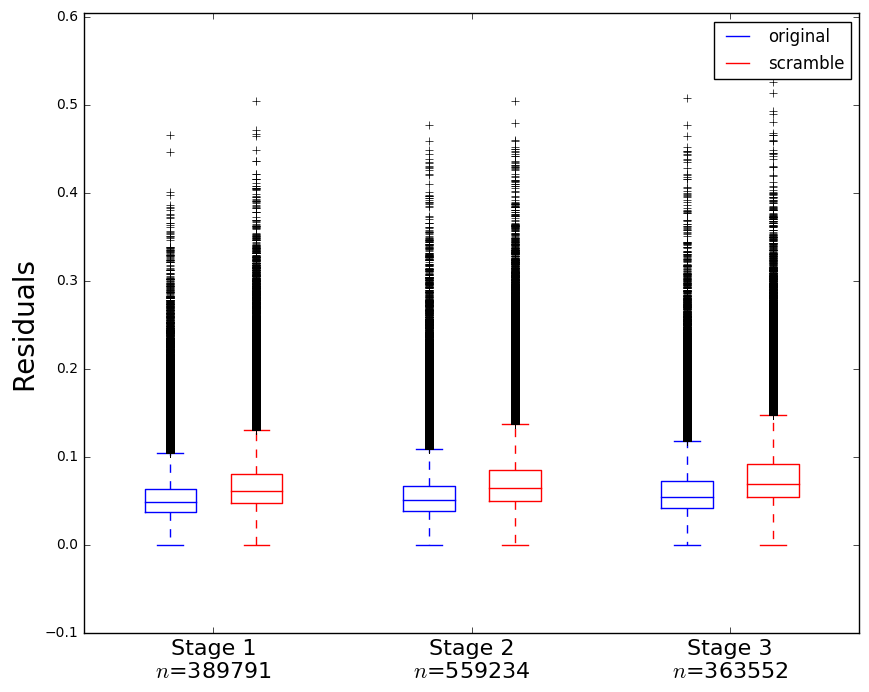

2.70842108725 2.68695196719
2.66686048567 2.64448330922
2.5984249156 2.57719268462


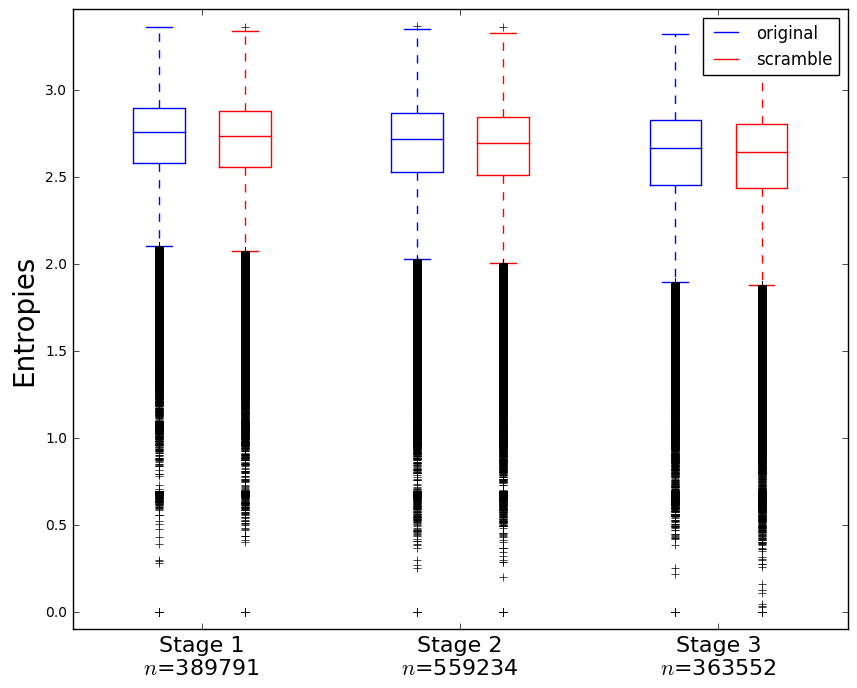

1.1978282497 1.20270049427
1.1947959633 1.19868573305
1.18649506096 1.18856654989


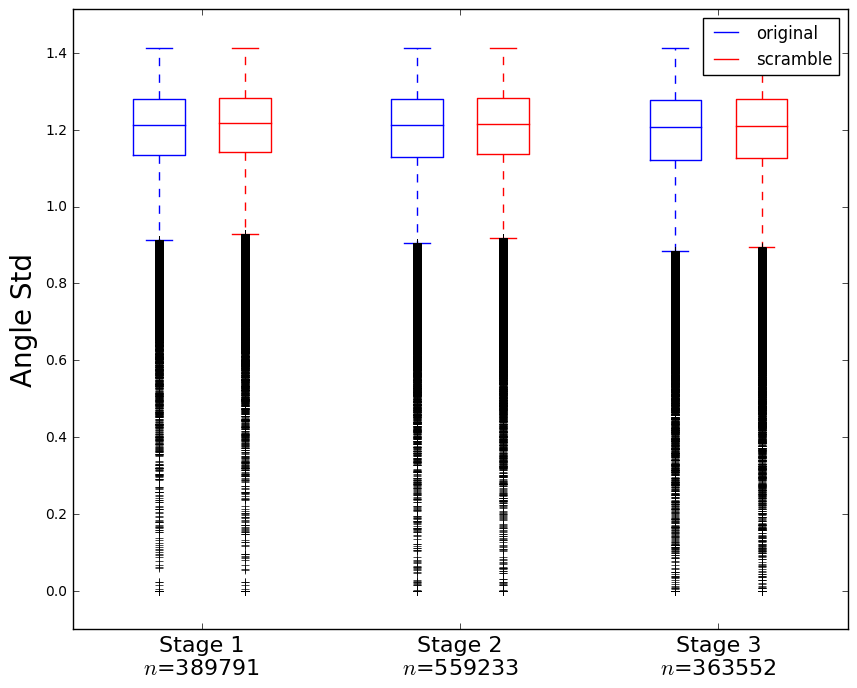

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 558346)  after:  558345
seed  50  length scramble entropy after:  558346
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.0542534920145 0.0687314997885
0.0566704529211 0.0719521854162
0.061331962296 0.0776390211225


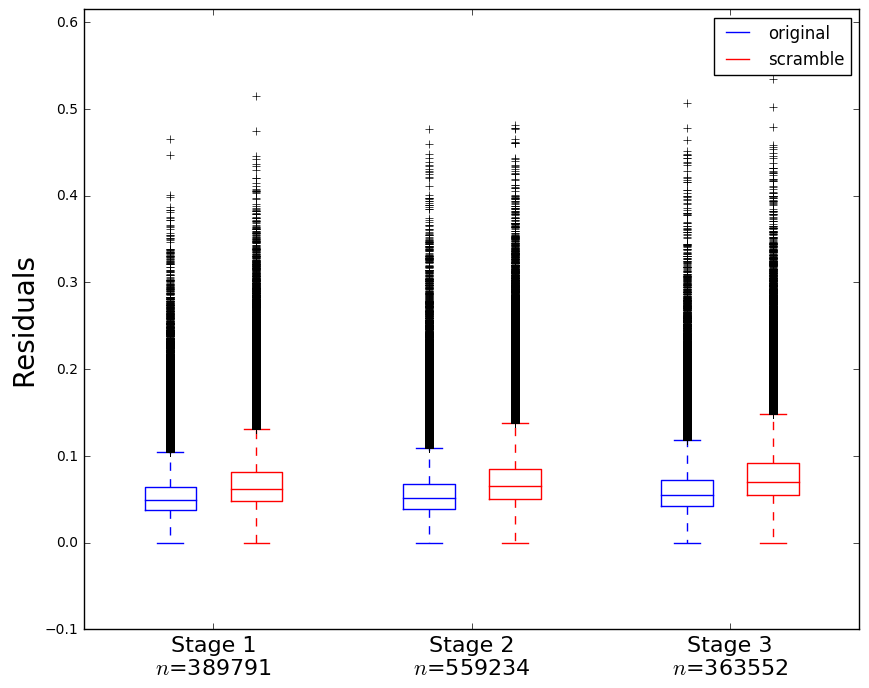

2.70842108725 2.68707234909
2.66686048567 2.64465429594
2.5984249156 2.57719464033


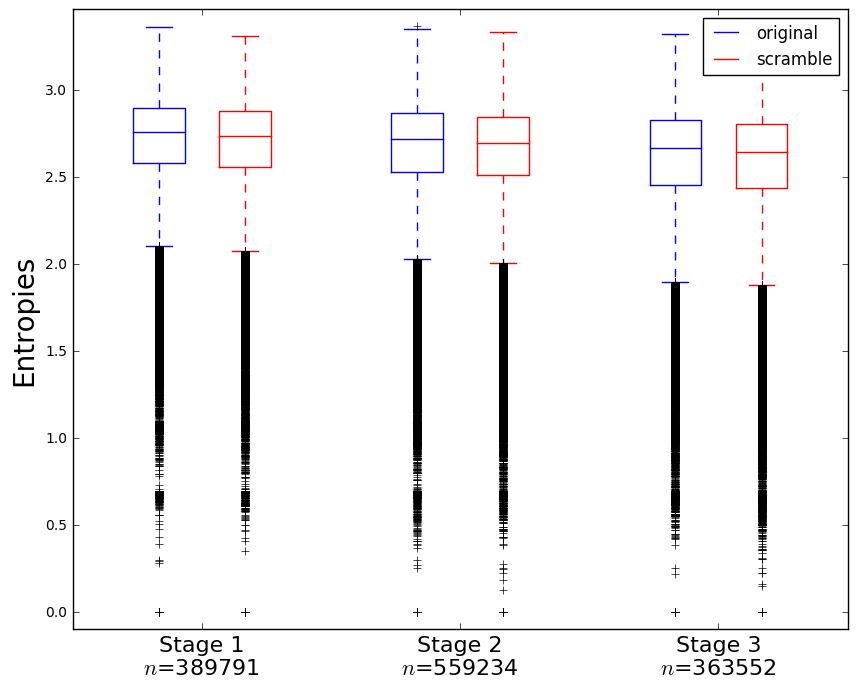

1.1978282497 1.20238695716
1.1947959633 1.19877300459
1.18649506096 1.18874618965


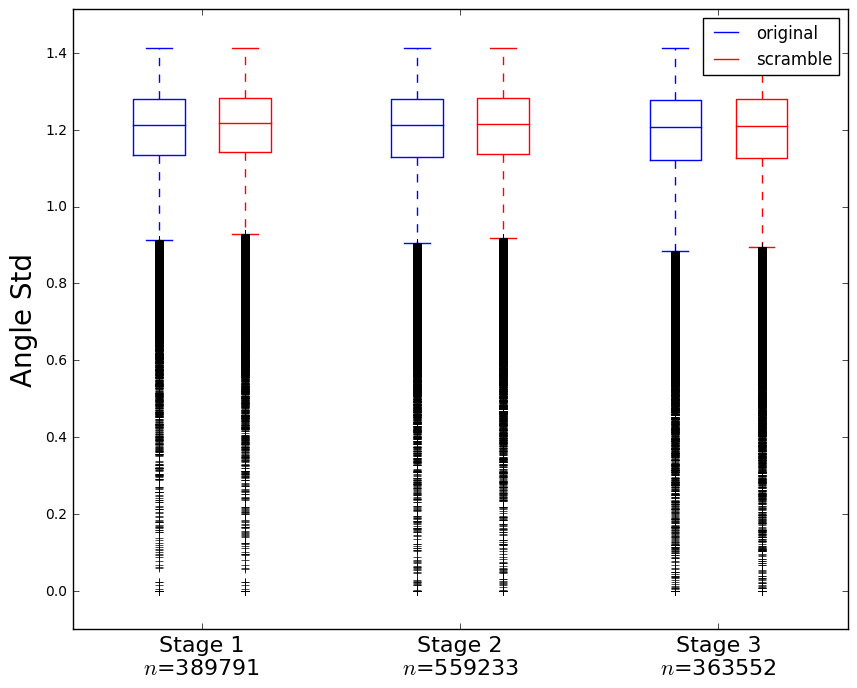

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 556660)  after:  556659
seed  200  length scramble entropy after:  556660
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.0542534920145 0.0687621714325
0.0566704529211 0.0719464982244
0.061331962296 0.0776341055582


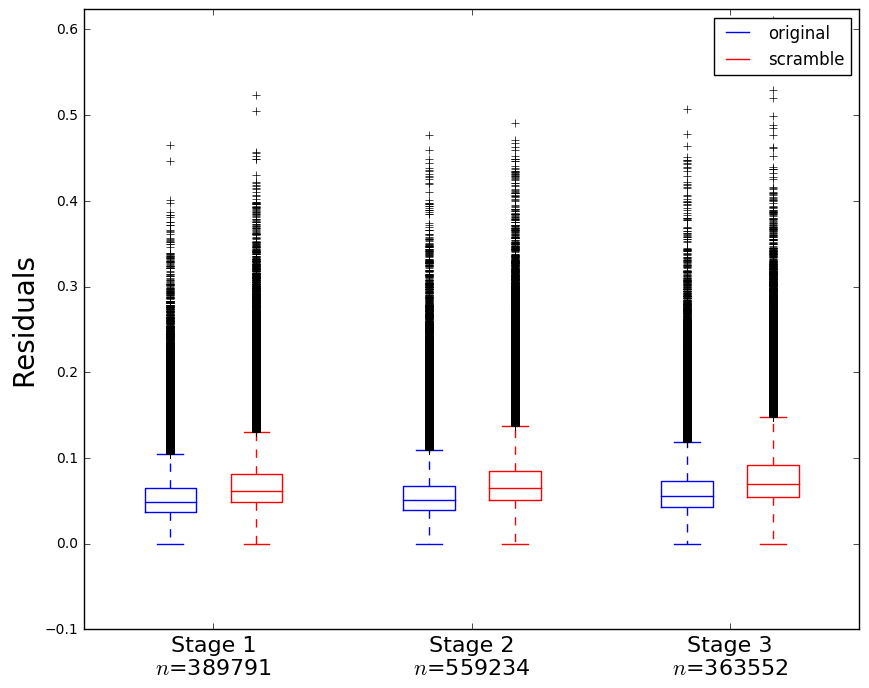

2.70842108725 2.68707280084
2.66686048567 2.64472089761
2.5984249156 2.57740001948


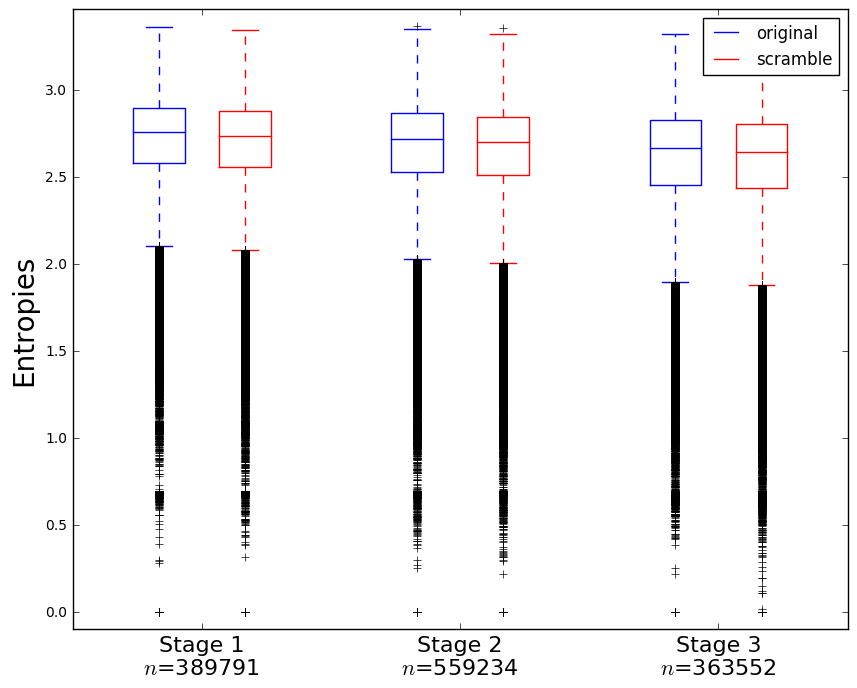

1.1978282497 1.20254019852
1.1947959633 1.19869114175
1.18649506096 1.18886785862


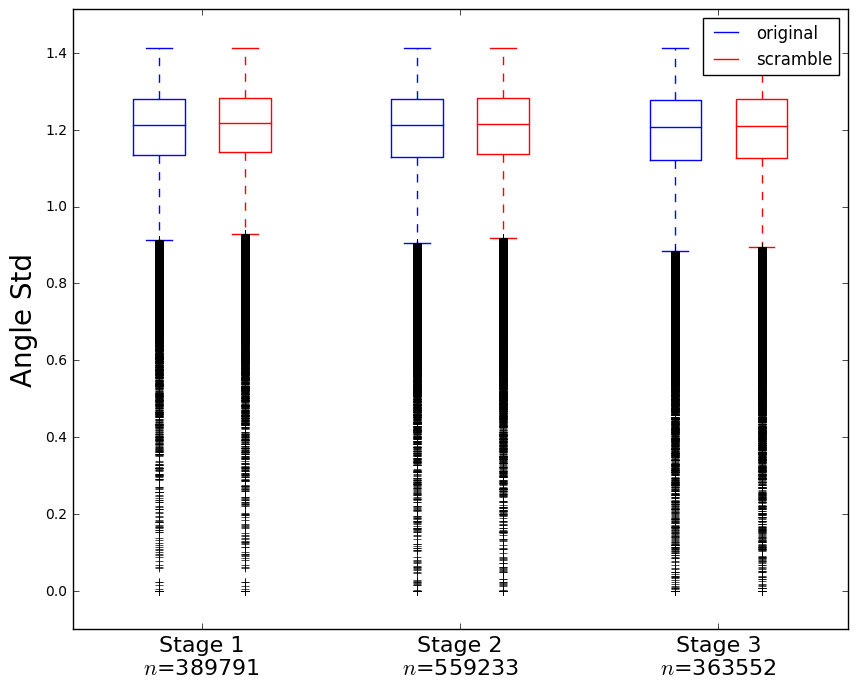

/home/lun5/Documents/multiplex/output/Entropy_radius_100_alpha_1_L1ratio_0.5
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559128)  after:  559125
length entropy after:  559128
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 556307)  after:  556303
seed  1  length scramble entropy after:  556307
seed  1  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  1  length scramble entropy after:  363552
0.0711771791339 0.0874831108095
0.0725882984887 0.0902353770752
0.0759742178315 0.0956660619196


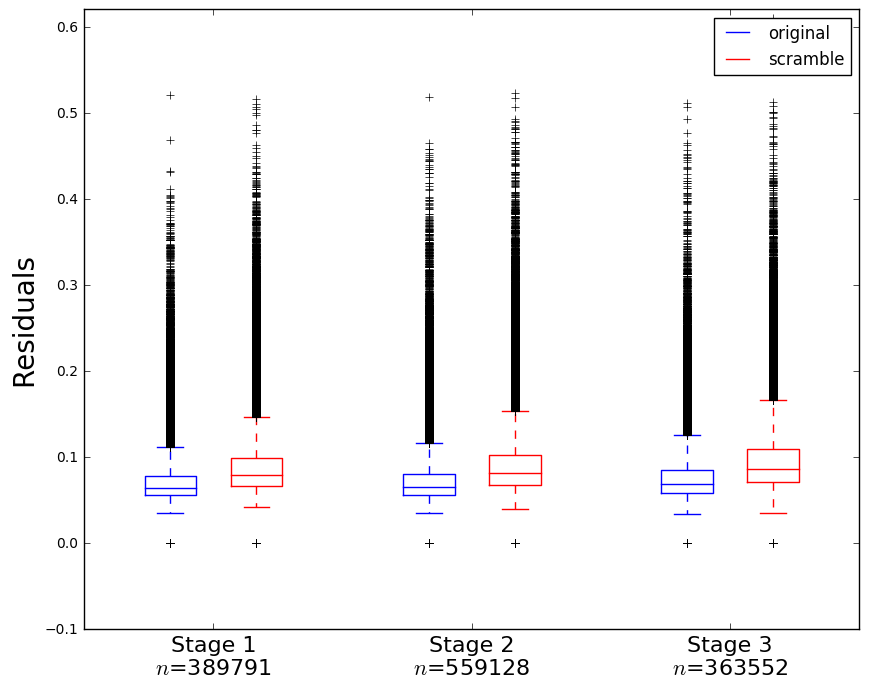

2.12072612384 1.94212055284
2.08370827722 1.8991351055
2.01538171387 1.8255921094


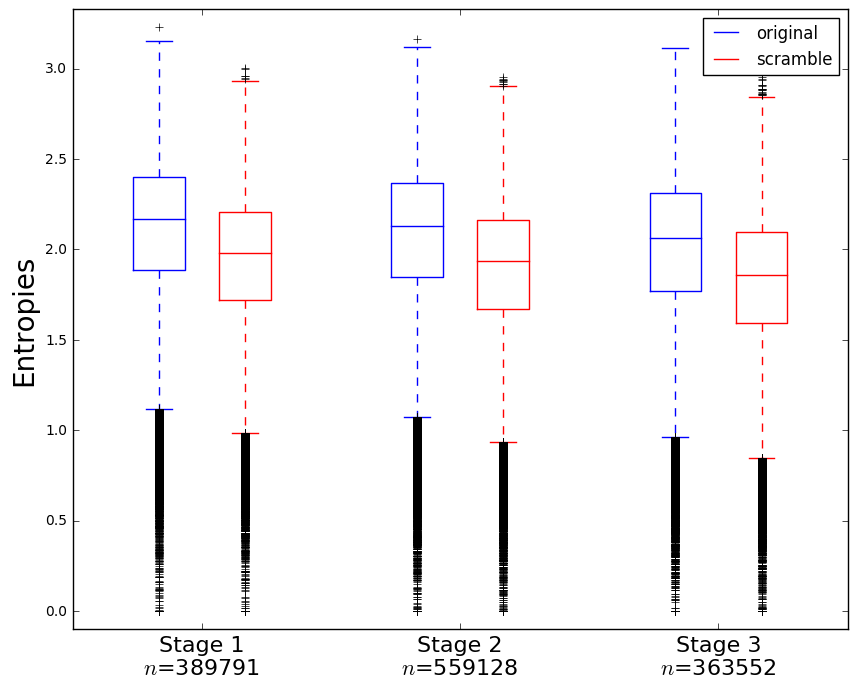

1.10263007451 1.09164638353
1.0981226738 1.08390726071
1.0869574093 1.06707407015


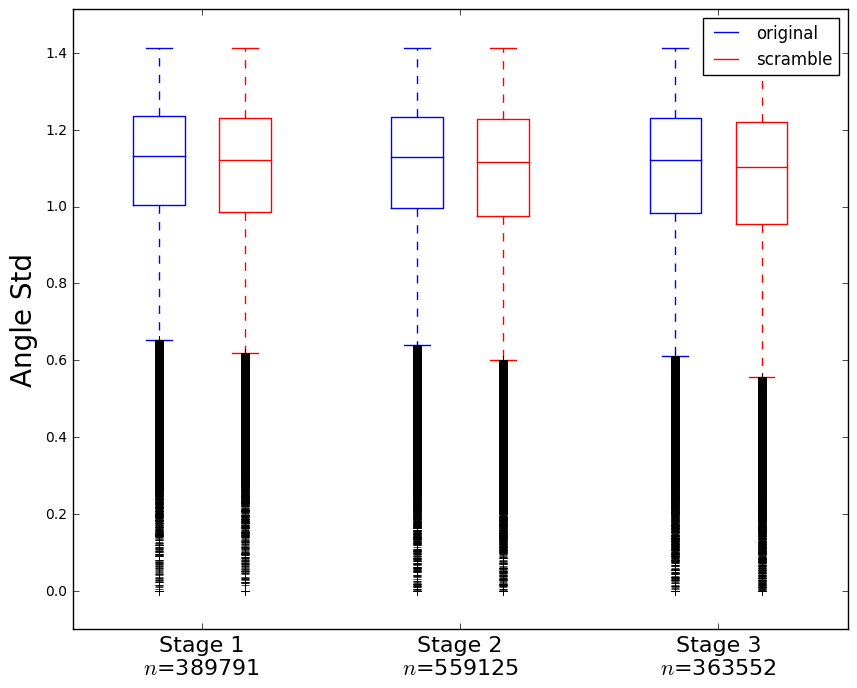

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 557798)  after:  557796
seed  50  length scramble entropy after:  557798
seed  50  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  50  length scramble entropy after:  363552
0.0711771791339 0.0874582358293
0.0725882984887 0.0902020064736
0.0759742178315 0.0956712569301


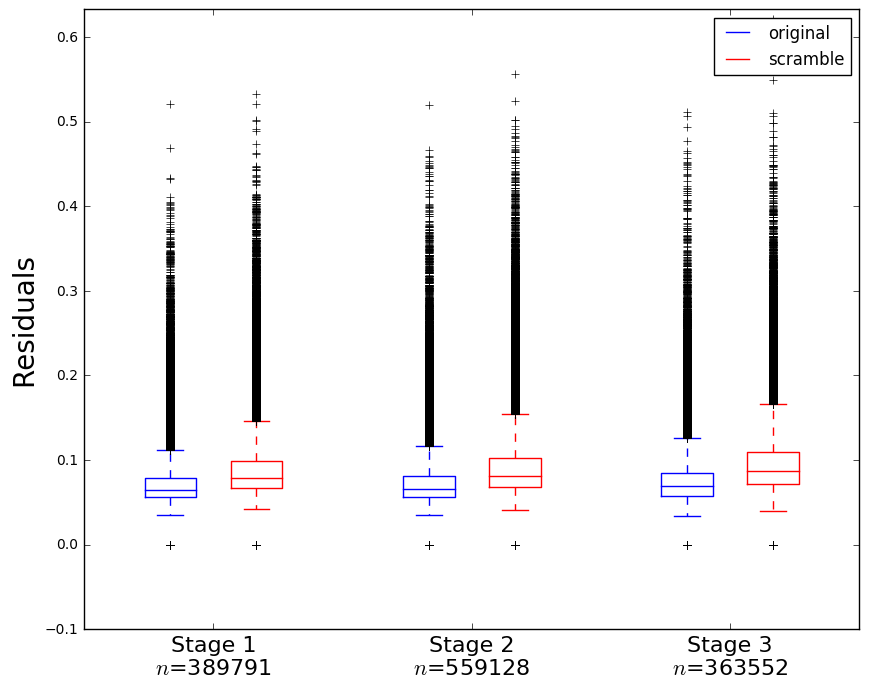

2.12072612384 1.94309030379
2.08370827722 1.89947861715
2.01538171387 1.82575660214


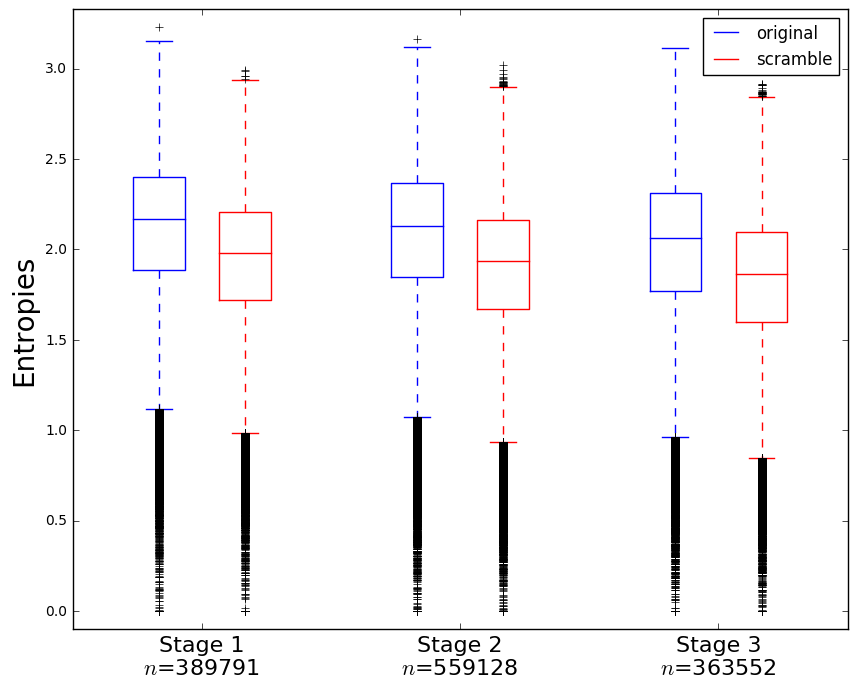

1.10263007451 1.09127617688
1.0981226738 1.08391758016
1.0869574093 1.06697795367


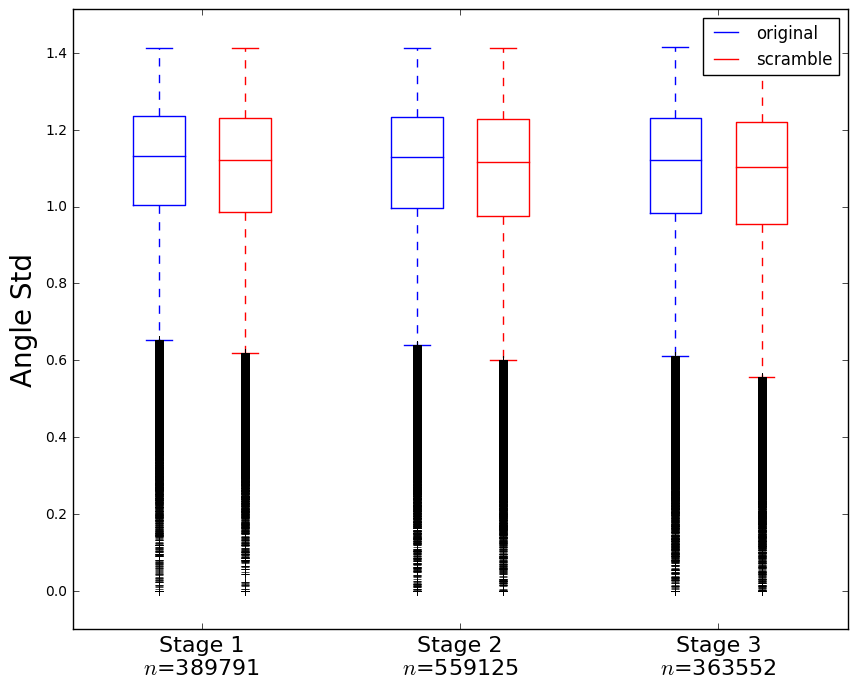

seed  200  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  200  length scramble entropy after:  389791
seed  200  length scramble angle std. Before:  (1, 554965)  after:  554962
seed  200  length scramble entropy after:  554965
seed  200  length scramble angle std. Before:  (1, 363552)  after:  363552
seed  200  length scramble entropy after:  363552
0.0711771791339 0.0875003992975
0.0725882984887 0.0901907278949
0.0759742178315 0.0956786937703


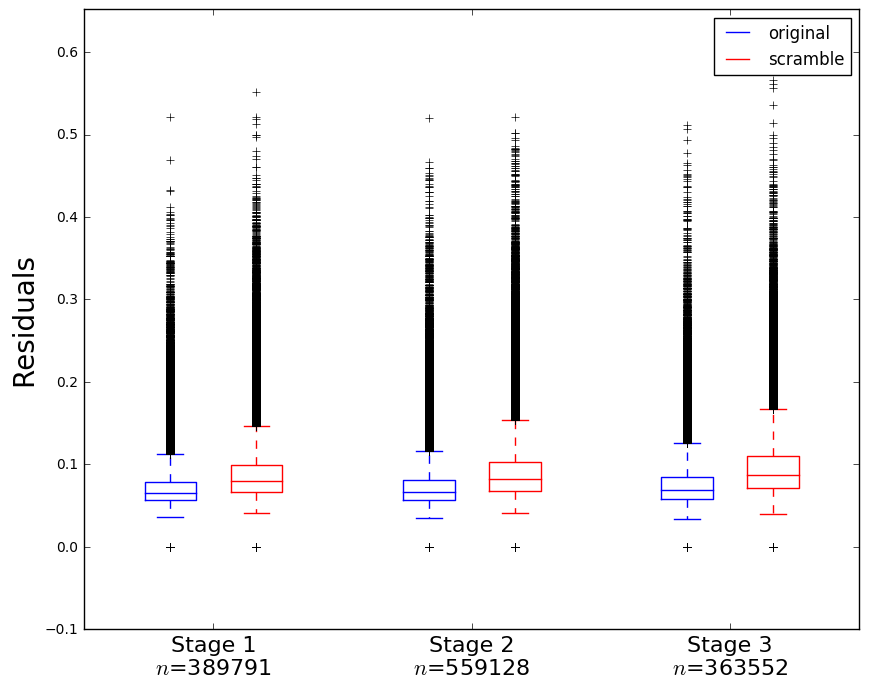

2.12072612384 1.94265055313
2.08370827722 1.89993772483
2.01538171387 1.82634247744


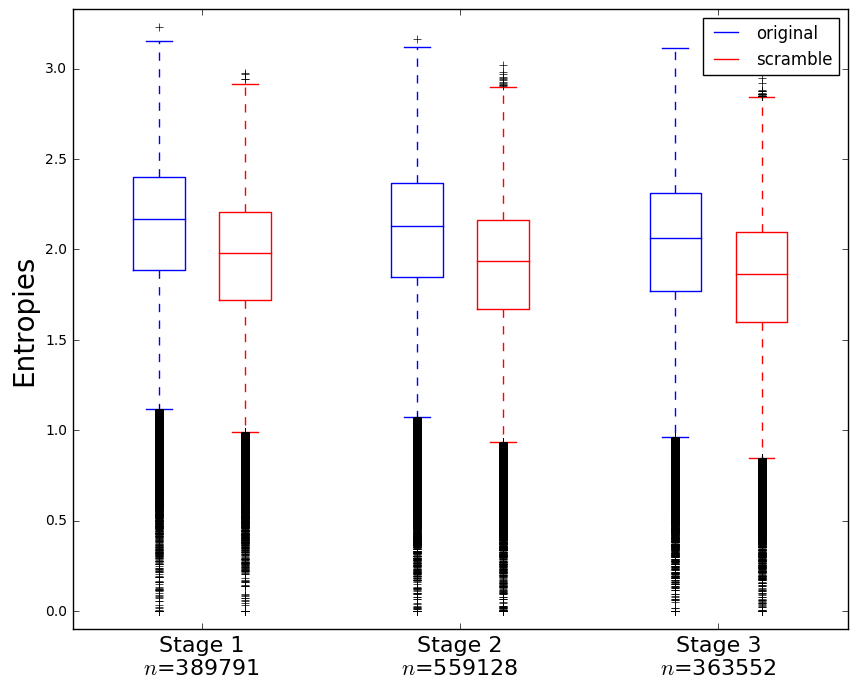

1.10263007451 1.09137712449
1.0981226738 1.08409342685
1.0869574093 1.0677259277


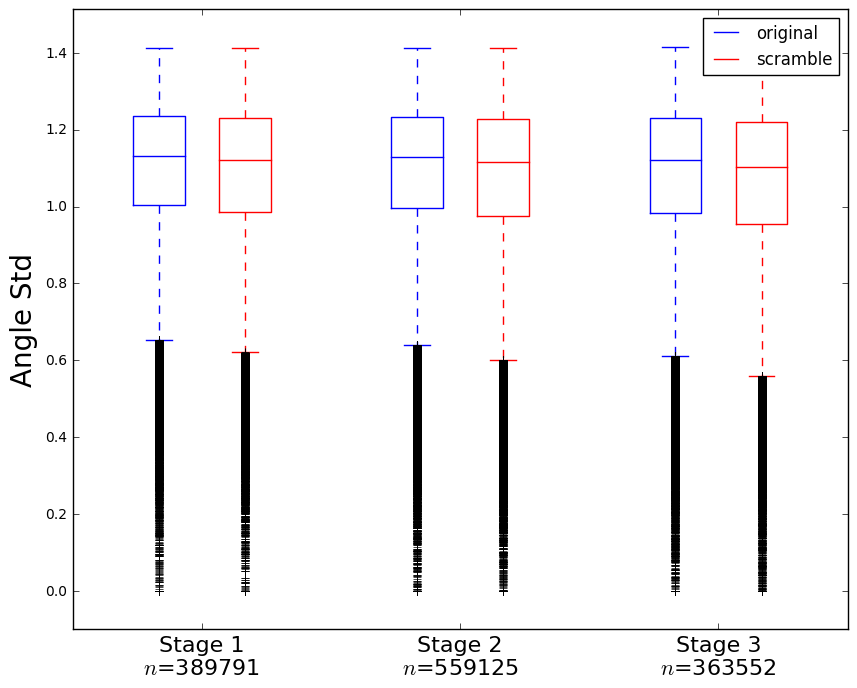

/home/lun5/Documents/multiplex/output/Entropy_radius_100_alpha_1_L1ratio_1
length angle std before:  (1, 389791)  after:  389791
length entropy after:  389791
length angle std before:  (1, 559104)  after:  559099
length entropy after:  559104
length angle std before:  (1, 363552)  after:  363552
length entropy after:  363552
seed  1  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  1  length scramble entropy after:  389791
seed  1  length scramble angle std. Before:  (1, 550633)  after:  550625
seed  1  length scramble entropy after:  550633
seed  1  length scramble angle std. Before:  (1, 362509)  after:  362508
seed  1  length scramble entropy after:  362509
0.0958590817707 0.109055961577
0.0958613811703 0.110474574941
0.0966652584735 0.113337483693


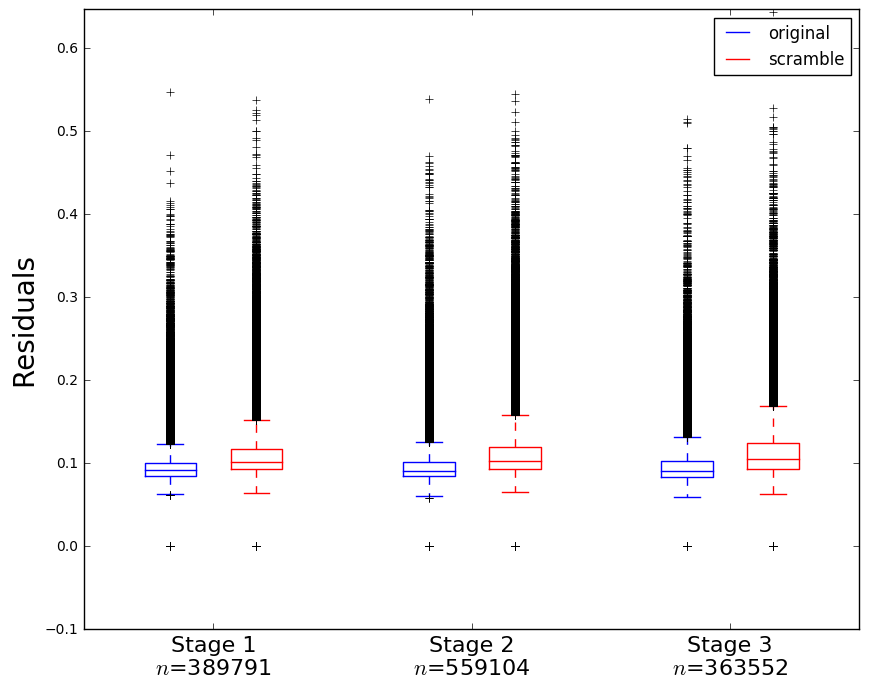

0.998324978591 1.03939631718
0.990441035949 1.02801981654
1.01057291118 1.04179479488


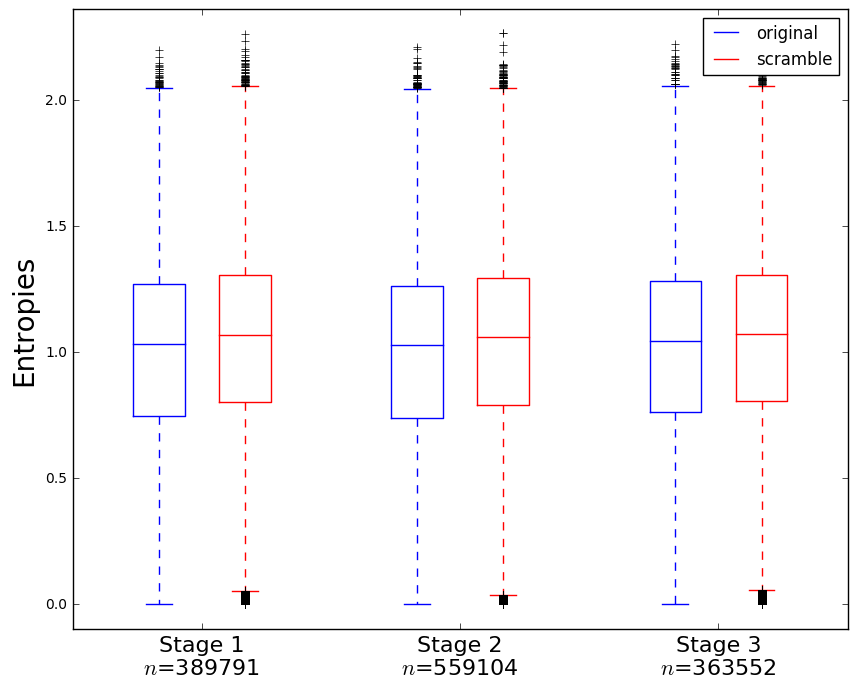

0.791795657472 0.817934065421
0.789321379077 0.814407693567
0.799556508921 0.820317489587


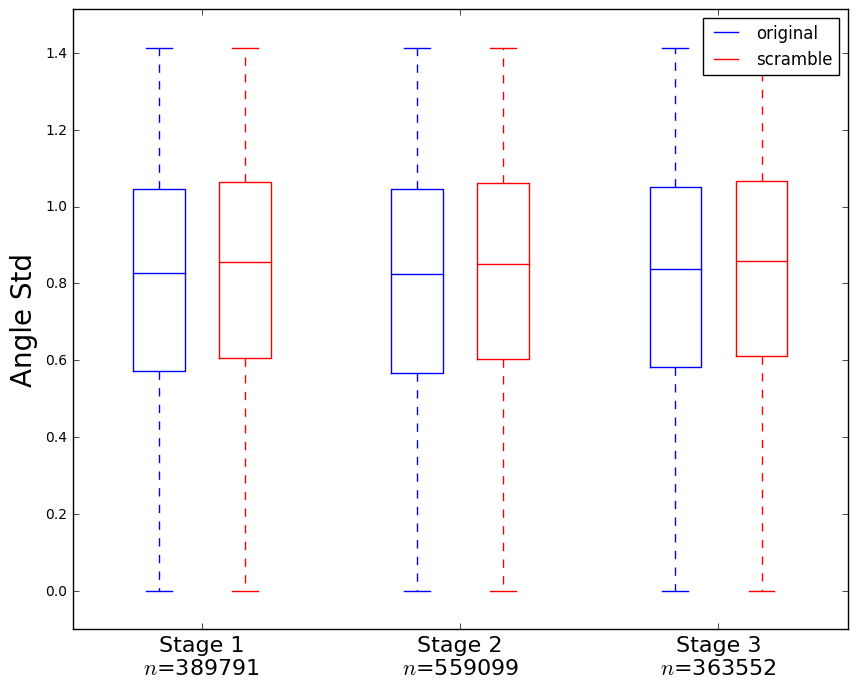

seed  50  length scramble angle std. Before:  (1, 389791)  after:  389791
seed  50  length scramble entropy after:  389791
seed  50  length scramble angle std. Before:  (1, 551109)  after:  551101
seed  50  length scramble entropy after:  551109
seed  50  length scramble angle std. Before:  (1, 361124)  after:  361122
seed  50  length scramble entropy after:  361124
0.0958590817707 0.109037570291
0.0958613811703 0.110416631061
0.0966652584735 0.113350040293


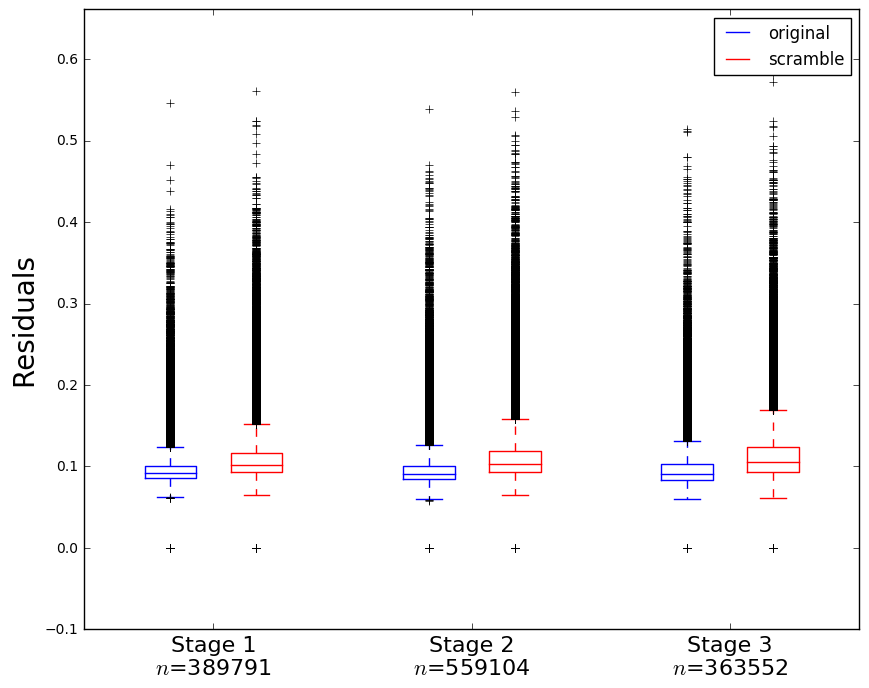

0.998324978591 1.03960637613
0.990441035949 1.02806137454
1.01057291118 1.04248056345


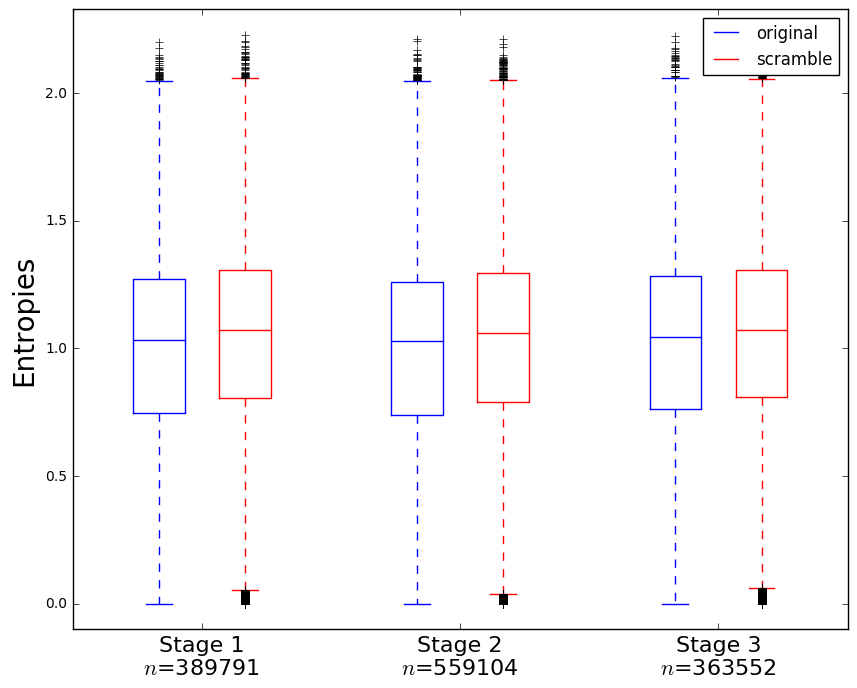

0.791795657472 0.817324361891
0.789321379077 0.814862476811
0.799556508921 0.820152858784


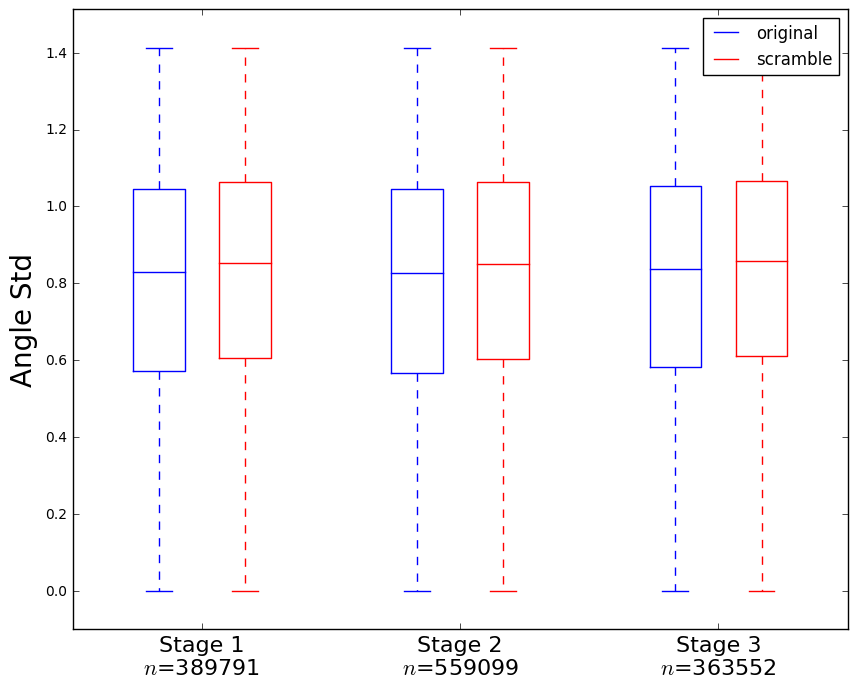

seed  200  length scramble angle std. Before:  (1, 388609)  after:  388608
seed  200  length scramble entropy after:  388609
seed  200  length scramble angle std. Before:  (1, 552168)  after:  552161
seed  200  length scramble entropy after:  552168
seed  200  length scramble angle std. Before:  (1, 361735)  after:  361734
seed  200  length scramble entropy after:  361735
0.0958590817707 0.109065450406
0.0958613811703 0.110398834119
0.0966652584735 0.113359365063


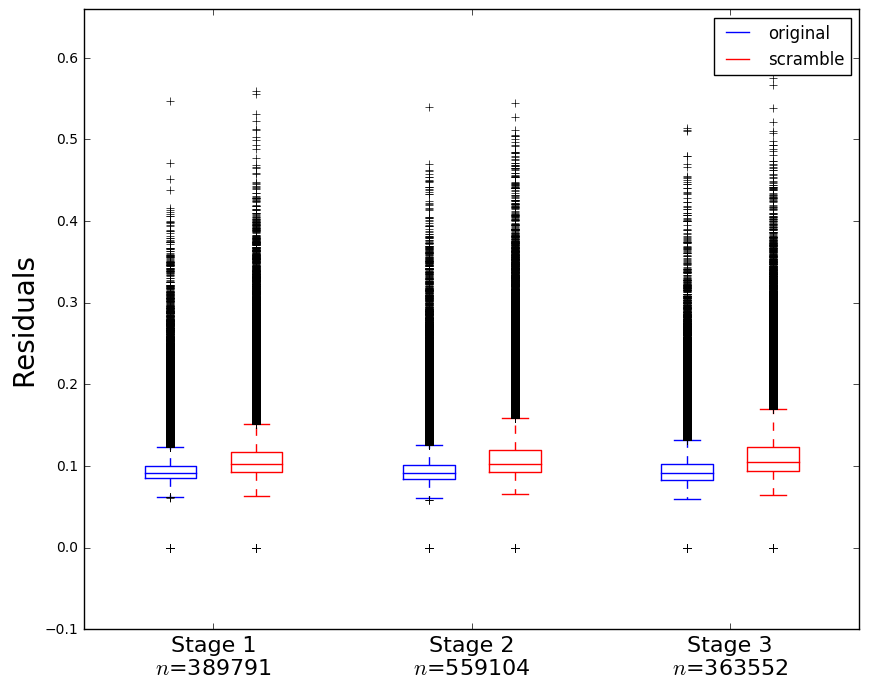

0.998324978591 1.04029610102
0.990441035949 1.02821370476
1.01057291118 1.04266057864


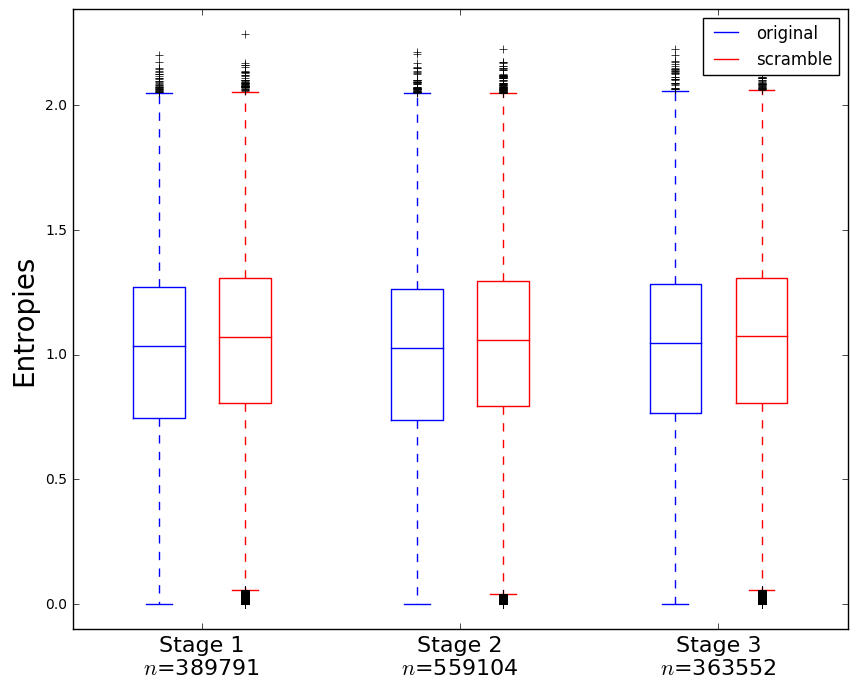

0.791795657472 0.81769504426
0.789321379077 0.815342924986
0.799556508921 0.820460943127


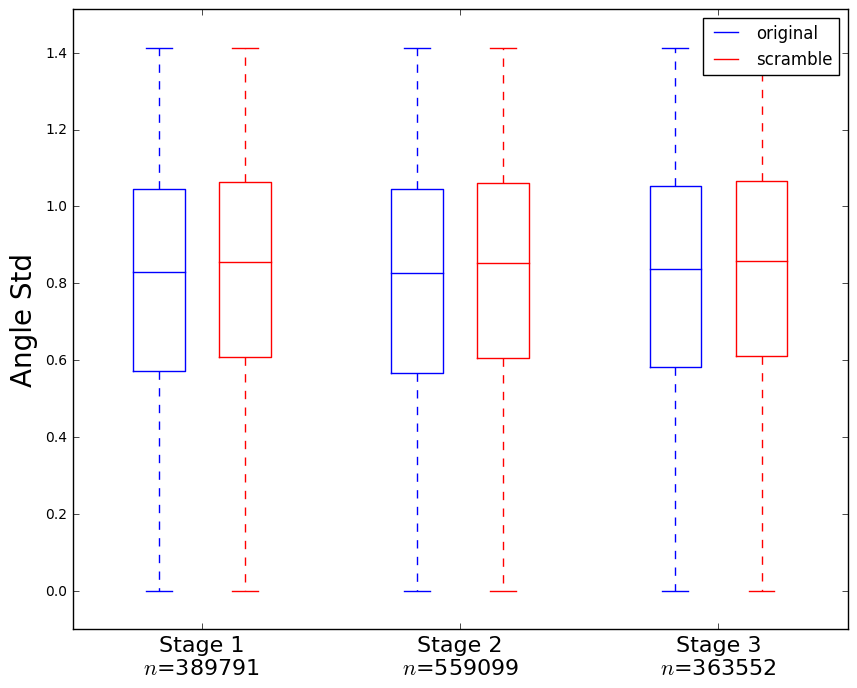

In [19]:
from sklearn.neighbors import NearestNeighbors, KDTree
from sklearn import linear_model
import scipy.io
from itertools import product
output_path = '/home/lun5/Documents/multiplex/output'
if not os.path.isdir(output_path):
    os.makedirs(output_path)

# Question is how do you choose alpha here, we can test
alphas = [.1, 1]
radii = [50,100] # Values: 50, 100
l1_ratios = [0, 0.5, 1] # need to add 0 in there

for alpha, radius, l1_ratio in product(alphas, radii,l1_ratios):
    NN_OUTPUT = os.path.join(output_path, ('Entropy_radius_' + str(radius)) + '_alpha_' +str(alpha) 
                          + '_L1ratio_' + str(l1_ratio))
    print NN_OUTPUT
    
    stage_entropies = {}
    stage_residuals = {}
    stage_angle_std = {}

    for i in range(1,4):
        stage_entropies[i] = []
        stage_residuals[i] = []
        stage_angle_std[i] = []

    for i in xrange(len(spot_ids)):
        spot_name = spot_names[i]
        mat_file = os.path.join(NN_OUTPUT,spot_name + '.mat')
        if os.path.isfile(mat_file):
            mat_dict = scipy.io.loadmat(mat_file)
            stage_entropies[spot_stages[i]].append(mat_dict['entropies'])
            stage_residuals[spot_stages[i]].append(mat_dict['residuals'])
            stage_angle_std[spot_stages[i]].append(mat_dict['angle_std'])
            if np.sum(np.isinf(mat_dict['entropies'])):
                print('%s has inf entropy' %(spot_name))
                break
        else:
            print('There is no %s' %(mat_file))

    #print stage_entropies[1]
    for i in range(1,4):
        stage_entropies[i] = np.hstack(stage_entropies[i])
        stage_residuals[i] = np.hstack(stage_residuals[i])
        stage_angle_std[i] = np.hstack(stage_angle_std[i])
        stage_angle_std[i] = stage_angle_std[i][~ np.isnan(stage_angle_std[i])]
        stage_entropies[i] = stage_entropies[i][~ np.isinf(stage_entropies[i])]
        print 'length angle std before: ', stage_residuals[i].shape, ' after: ', len(stage_angle_std[i])
        print 'length entropy after: ', len(stage_entropies[i])
    
    # scramble
        
    for seed in [1,50,200]:
        stage_scbl_entropies = {}
        stage_scbl_residuals = {}
        stage_scbl_angle_std = {}

        for i in range(1,4):
            stage_scbl_entropies[i] = []
            stage_scbl_residuals[i] = []
            stage_scbl_angle_std[i] = []

        NN_OUTPUT = os.path.join(output_path, ('Entropy_radius_' + str(radius)) + '_alpha_' +str(alpha) 
                                  + '_L1ratio_' + str(l1_ratio))

        for i in xrange(len(spot_ids)):
            spot_name = spot_names[i]
            #mat_file = os.path.join(NN_OUTPUT,spot_name + '_scramble.mat')
            mat_file = os.path.join(NN_OUTPUT,spot_name +  '_seed_' + str(seed) + '.mat')
            if os.path.isfile(mat_file):                        
                mat_dict = scipy.io.loadmat(mat_file)
                stage_scbl_entropies[spot_stages[i]].append(mat_dict['entropies'])
                stage_scbl_residuals[spot_stages[i]].append(mat_dict['residuals'])
                stage_scbl_angle_std[spot_stages[i]].append(mat_dict['angle_std'])  
            else:
                print('There is no %s' %(mat_file))

        #print stage_entropies[1]
        for i in range(1,4):
            stage_scbl_entropies[i] = np.hstack(stage_scbl_entropies[i])
            stage_scbl_residuals[i] = np.hstack(stage_scbl_residuals[i])
            stage_scbl_angle_std[i] = np.hstack(stage_scbl_angle_std[i])
            stage_scbl_angle_std[i] = stage_scbl_angle_std[i][~ np.isnan(stage_scbl_angle_std[i])]
            stage_scbl_entropies[i] = stage_scbl_entropies[i][~ np.isinf(stage_scbl_entropies[i])]
            print 'seed ', seed, ' length scramble angle std. Before: ', stage_scbl_residuals[i].shape,' after: ', len(stage_scbl_angle_std[i])
            print 'seed ', seed, ' length scramble entropy after: ', len(stage_scbl_entropies[i])

        name = os.path.join(NN_OUTPUT, (str(seed) + '_residuals.png'))
        group_boxplot(stage_residuals, stage_scbl_residuals,name,'Residuals')
        name = os.path.join(NN_OUTPUT,(str(seed) + '_entropies.png'))
        group_boxplot(stage_entropies, stage_scbl_entropies,name,'Entropies')
        name = os.path.join(NN_OUTPUT,(str(seed) + '_angle_std.png'))
        group_boxplot(stage_angle_std, stage_scbl_angle_std,name,'Angle Std')

In [151]:
new_output_path = '/mnt/lun5/ColonCancerStudy/Entropy_data/'
output_path = '/home/lun5/Documents/multiplex/Entropy_data'
print('sudo mkdir %s' %(new_output_path))

for alpha, radius, l1_ratio in product(alphas, radii,l1_ratios):
    NN_OUTPUT = os.path.join(output_path, ('Entropy_radius_' + str(radius)) + '_alpha_' +str(alpha) 
                          + '_L1ratio_' + str(l1_ratio))
    new_NN_OUTPUT = os.path.join(new_output_path, ('Entropy_radius_' + str(radius)) + '_alpha_' +str(alpha) 
                          + '_L1ratio_' + str(l1_ratio))
    print('sudo mkdir %s' %(new_NN_OUTPUT))
    print('sudo cp %s/*.png %s' %(NN_OUTPUT, new_NN_OUTPUT))

sudo mkdir /mnt/lun5/ColonCancerStudy/Entropy_data/
sudo mkdir /mnt/lun5/ColonCancerStudy/Entropy_data/Entropy_radius_50_alpha_0.1_L1ratio_0
sudo cp /home/lun5/Documents/multiplex/Entropy_data/Entropy_radius_50_alpha_0.1_L1ratio_0/*.png /mnt/lun5/ColonCancerStudy/Entropy_data/Entropy_radius_50_alpha_0.1_L1ratio_0
sudo mkdir /mnt/lun5/ColonCancerStudy/Entropy_data/Entropy_radius_50_alpha_0.1_L1ratio_0.5
sudo cp /home/lun5/Documents/multiplex/Entropy_data/Entropy_radius_50_alpha_0.1_L1ratio_0.5/*.png /mnt/lun5/ColonCancerStudy/Entropy_data/Entropy_radius_50_alpha_0.1_L1ratio_0.5
sudo mkdir /mnt/lun5/ColonCancerStudy/Entropy_data/Entropy_radius_50_alpha_0.1_L1ratio_1
sudo cp /home/lun5/Documents/multiplex/Entropy_data/Entropy_radius_50_alpha_0.1_L1ratio_1/*.png /mnt/lun5/ColonCancerStudy/Entropy_data/Entropy_radius_50_alpha_0.1_L1ratio_1
sudo mkdir /mnt/lun5/ColonCancerStudy/Entropy_data/Entropy_radius_100_alpha_0.1_L1ratio_0
sudo cp /home/lun5/Documents/multiplex/Entropy_data/Entropy_rad

In [18]:
from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes
    
def group_boxplot(original,scramble,name,axis_name):
    fig = plt.figure()
    ax = plt.axes()
    hold(True)

    plot_data = {}
    for i in range(1,4):
        plot_data[i]= [original[i], scramble[i]]
        print np.mean(original[i]), np.mean(scramble[i])

    # first boxplot pair
    bp = plt.boxplot(plot_data[1], positions = [1, 2], widths = 0.6)
    setBoxColors(bp)

    # second boxplot pair
    bp = boxplot(plot_data[2], positions = [4, 5], widths = 0.6)
    setBoxColors(bp)

    # thrid boxplot pair
    bp = boxplot(plot_data[3], positions = [7, 8], widths = 0.6)
    setBoxColors(bp)

    # set axes limits and labels
    xlim(0,9)
    y_min = np.min([np.min(original[1].flatten()), np.min(scramble[1].flatten())])-0.1
    y_max = np.max([np.max(original[1].flatten()), np.max(scramble[1].flatten())])+0.1
    ylim(y_min,y_max)
    #ax.set_xticklabels(['Stage 1', 'Stage 2', 'Stage 3'],fontsize=16)
    
    ax.set_xticklabels(['Stage %d\n$n$=%d' %(k,len(original[k].flatten())) 
                        for k in range(1,4)],fontsize=16)
    
    ax.set_xticks([1.5, 4.5, 7.5])
    ax.set_ylabel(axis_name,fontsize=20)

    # draw temporary red and blue lines and use them to create a legend
    hB, = plot([1,1],'b-')
    hR, = plot([1,1],'r-')
    legend((hB, hR),('original', 'scramble'))
    hB.set_visible(False)
    hR.set_visible(False)

    savefig(name)
    show()

In [124]:
alpha = 1
radius = 100
l1_ratio = 0.5

stage_entropies = {}
stage_residuals = {}
stage_angle_std = {}

for i in range(1,4):
    stage_entropies[i] = []
    stage_residuals[i] = []
    stage_angle_std[i] = []

NN_OUTPUT = os.path.join(output_path, ('Entropy_radius_' + str(radius)) + '_alpha_' +str(alpha) 
                          + '_L1ratio_' + str(l1_ratio))

for i in xrange(len(spot_ids)):
    spot_name = spot_names[i]
    mat_dict = scipy.io.loadmat(os.path.join(NN_OUTPUT,spot_name + '.mat'))
    stage_entropies[spot_stages[i]].append(mat_dict['entropies'])
    stage_residuals[spot_stages[i]].append(mat_dict['residuals'])
    stage_angle_std[spot_stages[i]].append(mat_dict['angle_std'])   
 
#print stage_entropies[1]
for i in range(1,4):
    stage_entropies[i] = np.hstack(stage_entropies[i])
    stage_residuals[i] = np.hstack(stage_residuals[i])
    stage_angle_std[i] = np.hstack(stage_angle_std[i])
    stage_angle_std[i] = stage_angle_std[i][~ np.isnan(stage_angle_std[i])]
    stage_entropies[i] = stage_entropies[i][~ np.isinf(stage_entropies[i])]

In [125]:
stage_scbl_entropies = {}
stage_scbl_residuals = {}
stage_scbl_angle_std = {}

for i in range(1,4):
    stage_scbl_entropies[i] = []
    stage_scbl_residuals[i] = []
    stage_scbl_angle_std[i] = []

NN_OUTPUT = os.path.join(output_path, ('Entropy_radius_' + str(radius)) + '_alpha_' +str(alpha) 
                          + '_L1ratio_' + str(l1_ratio))

for i in xrange(len(spot_ids)):
    spot_name = spot_names[i]
    mat_dict = scipy.io.loadmat(os.path.join(NN_OUTPUT,spot_name + '_scramble.mat'))
    stage_scbl_entropies[spot_stages[i]].append(mat_dict['entropies'])
    stage_scbl_residuals[spot_stages[i]].append(mat_dict['residuals'])
    stage_scbl_angle_std[spot_stages[i]].append(mat_dict['angle_std'])   
 
#print stage_entropies[1]
for i in range(1,4):
    stage_scbl_entropies[i] = np.hstack(stage_scbl_entropies[i])
    stage_scbl_residuals[i] = np.hstack(stage_scbl_residuals[i])
    stage_scbl_angle_std[i] = np.hstack(stage_scbl_angle_std[i])
    stage_scbl_angle_std[i] = stage_scbl_angle_std[i][~ np.isnan(stage_scbl_angle_std[i])]
    stage_scbl_entropies[i] = stage_scbl_entropies[i][~ np.isinf(stage_scbl_entropies[i])]

In [17]:
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['fliers'][0], color='blue')
    setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
    #setp(bp['fliers'][2], color='red')
    #setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

0.0711771791339 0.087506394189
0.0725959065786 0.0901939727179
0.0759742178315 0.0956283736477


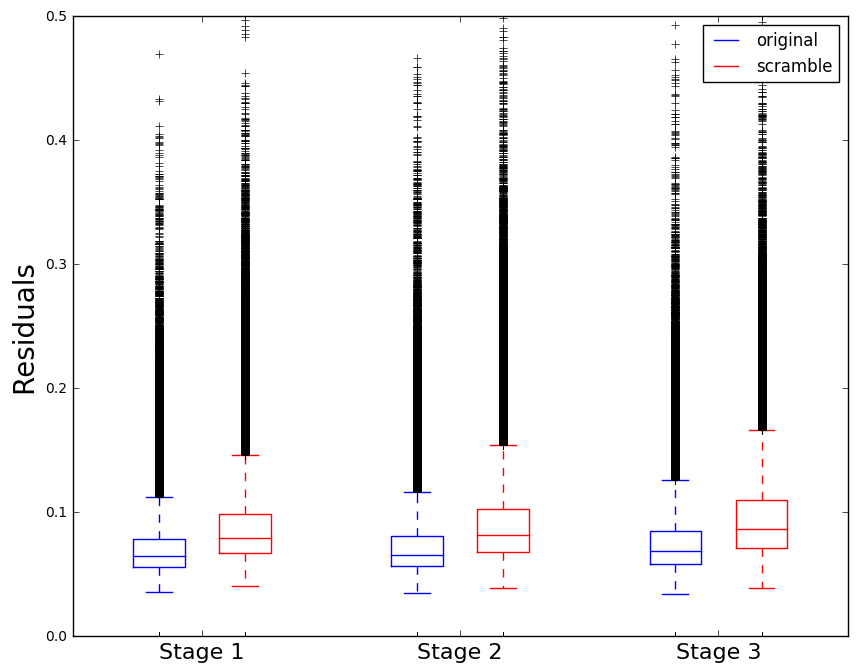

In [126]:
fig = figure()
ax = axes()
hold(True)

plot_data = {}
for i in range(1,4):
    plot_data[i]= [stage_residuals[i], stage_scbl_residuals[i]]
    print np.mean(stage_residuals[i]), np.mean(stage_scbl_residuals[i])

# first boxplot pair
bp = boxplot(plot_data[1], positions = [1, 2], widths = 0.6)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(plot_data[2], positions = [4, 5], widths = 0.6)
setBoxColors(bp)

# thrid boxplot pair
bp = boxplot(plot_data[3], positions = [7, 8], widths = 0.6)
setBoxColors(bp)

# set axes limits and labels
xlim(0,9)
ylim(0,.5)
ax.set_xticklabels(['Stage 1', 'Stage 2', 'Stage 3'],fontsize=16)
ax.set_xticks([1.5, 4.5, 7.5])
ax.set_ylabel('Residuals',fontsize=20)

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('original', 'scramble'))
hB.set_visible(False)
hR.set_visible(False)

savefig(os.path.join(NN_OUTPUT,'residuals.png'))
show()

0.771768798769 0.767071879004
389782 (1, 389791)
389777 (1, 389791)
0.769941096926 0.764387398395
559273 (1, 559298)
559248 (1, 559298)
0.762684011189 0.754593449797
363536 (1, 363552)
363511 (1, 363552)


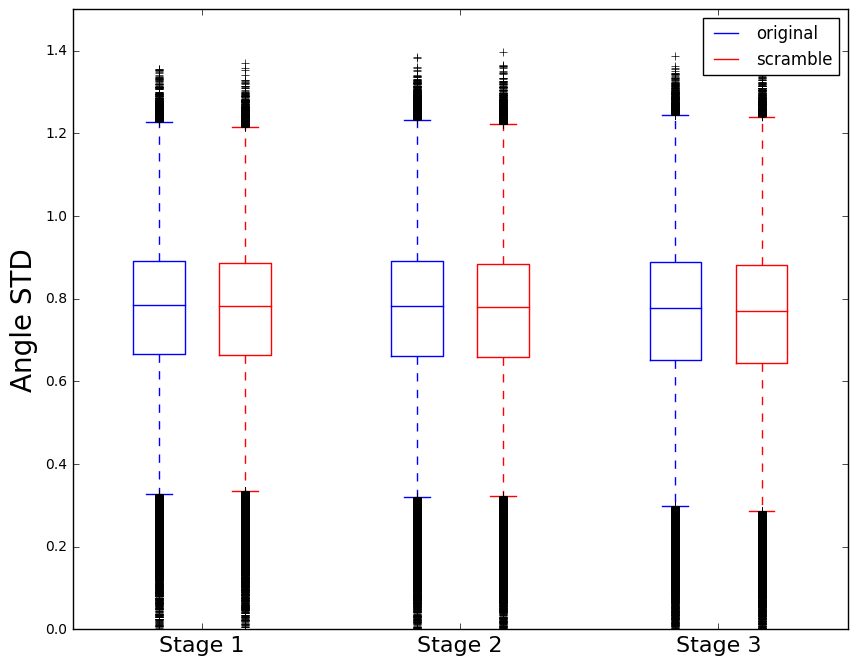

In [127]:
fig = figure()
ax = axes()
hold(True)

plot_data = {}
for i in range(1,4):
    plot_data[i]= [stage_angle_std[i], stage_scbl_angle_std[i]]
    print np.mean(stage_angle_std[i]), np.mean(stage_scbl_angle_std[i])
    print len(stage_angle_std[i]), stage_residuals[i].shape
    print len(stage_scbl_angle_std[i]), stage_scbl_residuals[i].shape

# first boxplot pair
bp = boxplot(plot_data[1], positions = [1, 2], widths = 0.6)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(plot_data[2], positions = [4, 5], widths = 0.6)
setBoxColors(bp)

# thrid boxplot pair
bp = boxplot(plot_data[3], positions = [7, 8], widths = 0.6)
setBoxColors(bp)

# set axes limits and labels
xlim(0,9)
ylim(0,1.5)
ax.set_xticklabels(['Stage 1', 'Stage 2', 'Stage 3'],fontsize=16)
ax.set_xticks([1.5, 4.5, 7.5])
ax.set_ylabel('Angle STD',fontsize=20)

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('original', 'scramble'))
hB.set_visible(False)
hR.set_visible(False)

savefig(os.path.join(NN_OUTPUT,'angle_std.png'))
show()

2.12938996275 1.95747109849
389723 (1, 389791)
389496 (1, 389791)
2.09194868624 1.91365038353
559166 (1, 559298)
558737 (1, 559298)
2.02267735266 1.83856192791
363433 (1, 363552)
362800 (1, 363552)


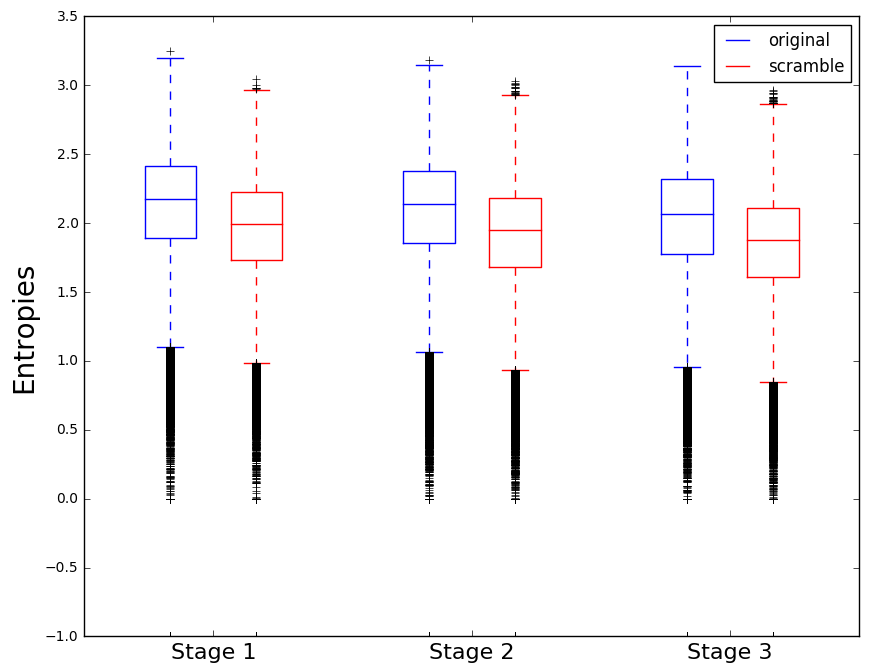

In [128]:
fig = figure()
ax = axes()
hold(True)

plot_data = {}
for i in range(1,4):
    plot_data[i]= [stage_entropies[i], stage_scbl_entropies[i]]
    print np.mean(stage_entropies[i]), np.mean(stage_scbl_entropies[i])
    print len(stage_entropies[i]), stage_residuals[i].shape
    print len(stage_scbl_entropies[i]), stage_scbl_residuals[i].shape
# first boxplot pair
bp = boxplot(plot_data[1], positions = [1, 2], widths = 0.6)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(plot_data[2], positions = [4, 5], widths = 0.6)
setBoxColors(bp)

# thrid boxplot pair
bp = boxplot(plot_data[3], positions = [7, 8], widths = 0.6)
setBoxColors(bp)

# set axes limits and labels
xlim(0,9)
ylim(-1,3.5)
ax.set_xticklabels(['Stage 1', 'Stage 2', 'Stage 3'],fontsize=16)
ax.set_xticks([1.5, 4.5, 7.5])
ax.set_ylabel('Entropies', fontsize=20)
# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('original', 'scramble'))
hB.set_visible(False)
hR.set_visible(False)

savefig(os.path.join(NN_OUTPUT,'entropies.png'))
show()

In [66]:
for i in range(1,4):
    print np.sum(np.isinf(stage_entropies[i]))/stage_entropies[i].shape[1]
    print stage_entropies[i].shape,np.max(stage_entropies[i]),np.min(stage_entropies[i])
    stage_entropies[i][np.isinf(stage_entropies[i])] = -1
    print stage_entropies[i].shape,np.max(stage_entropies[i]),np.min(stage_entropies[i])

0.415779225277
(1, 389791) 2.98261283219 -inf
(1, 389791) 2.98261283219 -1.0
0.44330929129
(1, 559298) 2.9282682418 -inf
(1, 559298) 2.9282682418 -1.0
0.515703393187
(1, 363552) 2.95411505546 -inf
(1, 363552) 2.95411505546 -1.0


In [14]:
from sklearn.neighbors import NearestNeighbors, KDTree
from sklearn import linear_model
import scipy.io
from itertools import product

#output_path = '/media/ColonCancerStudy/NN_data'
output_path = '/mnt/lun5/ColonCancerStudy/NN_data/'
# Question is how do you choose alpha here, we can test
alphas = [.1,1]
radii = [25, 50,75,100] # Values: 50, 100

num_nuclei = biomarkers[:,7]
areas = biomarkers[:,8]
xy_coords = biomarkers[:,:2]
epi_stroma = biomarkers[:,2]

np.random.seed(0)

# l1_ratio = 0.5
l1_ratios = [0.3, 0.5, 0.7, 1] # need to add 0 in there
#print all_spot_names[np.nonzero(all_spot_id == 30)[0][0]]

for alpha, radius, l1_ratio in product(alphas, radii,l1_ratios):
    NN_OUTPUT = os.path.join(output_path, ('Elastic_NN_radius_' + str(radius)) + '_alpha_' +str(alpha) 
                          + '_L1ratio_' + str(l1_ratio))
    if os.path.isdir(NN_OUTPUT):
        print(('Elastic: Already started calculation for alpha = %0.2f radius = %d, l1_ratio = %0.2f') %(
            alpha, radius, l1_ratio))
    
    if os.path.isfile(os.path.join(NN_OUTPUT,'all_spots.mat')):
        continue
    #continue
    if not os.path.isdir(NN_OUTPUT):
        print(('Elastic: Have not calculated for alpha = %0.2f radius = %d, l1_ratio = %0.2f') %(
            alpha, radius, l1_ratio))
        os.makedirs(NN_OUTPUT)
    nn_all_spots = []
    nn_all_residuals = []
    nn_all_spots_after_del = []
    nn_all_residuals_after_del = []
    start_time = time.time()
    for i in xrange(len(spot_id)):
        spot_name = all_spot_names[np.nonzero(all_spot_id ==spot_id[i])[0][0]]
        if os.path.isfile(os.path.join(NN_OUTPUT,spot_name + '.mat')):
            mat_dict = scipy.io.loadmat(os.path.join(NN_OUTPUT,spot_name + '.mat'))
            nn_all_spots.append(mat_dict['num_nn'])
            nn_all_residuals.append(mat_dict['residuals'])
            if 'nnz_after_del' in mat_dict.keys():
                nn_all_spots_after_del.append(mat_dict['nnz_after_del'])
                nn_all_residuals_after_del.append(mat_dict['residuals_after_del'])
        else:    
            #clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            #clf = linear_model.Lasso(alpha=alpha)
            #clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=0.5)
            num_non_zeros_nn = [] # number of contributing neighbors
            residuals = [] # residuals for each cell
            predictive_bm = [] # biomarker that is the most predictive
            residuals_bm = [] # residuals of all 35 biomarker
            dist_to_neighbors = [] # distance to neighbors
            coeff_neighbors = [] # contribution of neighbors
            conn_types = [] # connection types to its neighbors 1: same type, 0: different type(stroma vs epi)
            neighbor_id = [] # id of neighbor
    
            # save variable after deleting the most predictive biomarker
            neighbor_id_after_del = []
            coeff_neighbors_after_del = []
            residuals_bm_after_del = []
            residuals_after_del = []
            nnz_after_del = [] # number of predictive biomarkers after deletion
            deleted_neighbor_id = [] # the id of deleted neighbor
            cell_id = all_cell_id[all_spot_id == spot_id[i]]
    
            #print spot_name
            spot_bm = bm_data[cell_id - 1, :] # biomarker values of the spot
            spot_xy = xy_coords[cell_id -1, :] # x,y coordinates of each cell
            spot_cell_num_nuclei = num_nuclei[cell_id -1] # number of nuclei of each cell
            spot_cell_areas = areas[cell_id-1] # area of each cell
            spot_epi_stroma = epi_stroma[cell_id -1] # whether each cell is epithelial/stroma 
    
            # get nearest neighbors
            tree = KDTree(spot_xy)
            ind, dist = tree.query_radius(spot_xy, r = radius, return_distance = True)
            for j in xrange(len(cell_id)):
                clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
                #cell_bm = bm_data[cell_id[j]-1,:].reshape(1,-1)
                #nb_bm = bm_data[cell_id[ind[j][ind[j]!= j]]-1,:] # nearest neighbors within 
                #print cell_bm.shape, nb_bm.shape
                cell_bm = spot_bm[j,:].reshape(1,-1) # cell of question
                #nb_bm = spot_bm[ind[j][ind[j]!=j], :]
                nb_bm = spot_bm[ind[j][dist[j]!=0], :] # eliminate itself
                dist_to_neighbors.append(dist[j][dist[j]!=0])
                conn = spot_epi_stroma[j] == spot_epi_stroma[ind[j][dist[j]!=0]]
                conn_types.append(np.asarray([int(conn[k]) for k in xrange(len(conn))]))
                curr_neigh_ind = ind[j][dist[j]!=0]
                neighbor_id.append(ind[j][dist[j]!=0])
                break
                if np.min(nb_bm.shape) > 0:
                    clf.fit(nb_bm.T,cell_bm.T)
                    num_non_zeros_nn.append(np.sum(clf.coef_ !=0))
                    coeff_neighbors.append(clf.coef_)
                    pred = clf.predict(nb_bm.T).reshape(1,-1)
                    resid_biomarkers = np.square(cell_bm - pred)
                    residuals.append(np.sqrt(resid_biomarkers.sum())/cell_bm.shape[1])
                    predictive_bm.append(good_nuc_biomarkers[np.argmin(resid_biomarkers)])
                    residuals_bm.append(resid_biomarkers)
            
                    # delete the most predictive biomarker
                    most_predictive_neighbor = np.argmax(clf.coef_)
                    nb_bm_after_del = np.delete(nb_bm,most_predictive_neighbor,0)
                    if np.min(nb_bm_after_del.shape) > 0:
                        clf.fit(nb_bm_after_del.T, cell_bm.T)
                        coeff_neighbors_after_del.append(clf.coef_)
                        pred = clf.predict(nb_bm_after_del.T).reshape(1,-1)
                        resid_biomarkers = np.square(cell_bm - pred)
                        residuals_after_del.append(np.sqrt(resid_biomarkers.sum())/cell_bm.shape[1])
                        residuals_bm_after_del.append(resid_biomarkers)
                        nnz_after_del.append(np.sum(clf.coef_ != 0))
                        deleted_neighbor_id.append(curr_neigh_ind[most_predictive_neighbor])
                        neighbor_id_after_del.append(np.delete(curr_neigh_ind,most_predictive_neighbor))
                    else:
                        coeff_neighbors_after_del.append([])
                        residuals_after_del.append(0)
                        residuals_bm_after_del.append(cell_bm)
                        nnz_after_del.append(0)
                        deleted_neighbor_id.append(0)
                        neighbor_id_after_del.append([])
                else:
                    #print spot_name, j, nb_bm.shape                   
                    num_non_zeros_nn.append(0)
                    coeff_neighbors.append([])
                    residuals.append(0)
                    predictive_bm.append('None')
                    residuals_bm.append(cell_bm)
                    # after deletion
                    coeff_neighbors_after_del.append([])
                    residuals_after_del.append(0)
                    residuals_bm_after_del.append(cell_bm)
                    nnz_after_del.append(0)
                    deleted_neighbor_id.append(0)
                    neighbor_id_after_del.append([])
            #for j in xrange(len(cell_id)): END of this for loop


            #clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            residuals_bm = np.vstack(residuals_bm)
            residuals_bm_after_del = np.vstack(residuals_after_del)
            nn_all_spots.append(np.asarray(num_non_zeros_nn))
            nn_all_residuals.append(np.asarray(residuals))
            nn_all_spots_after_del.append(np.asarray(nnz_after_del))
            nn_all_residuals_after_del.append(np.asarray(residuals_after_del))
        
            scipy.io.savemat(os.path.join(NN_OUTPUT,spot_name + '.mat'), 
                 mdict={'xy':spot_xy, 'areas':spot_cell_areas,
                        'epi_stroma':spot_epi_stroma,'residuals':residuals,
                        'residuals_bm':residuals_bm,'dist_to_neigh':dist_to_neighbors,
                        'coeff_neigh':coeff_neighbors, 'predictive_bm':predictive_bm,
                        'num_nn':np.asarray(num_non_zeros_nn),'num_nuclei':spot_cell_num_nuclei,
                        'conn_types':conn_types, 'neighbor_id':neighbor_id,
                        'nb_id_after_del':neighbor_id_after_del, 'coeff_after_del':coeff_neighbors_after_del,
                        'residuals_bm_after_del': residuals_bm_after_del, 
                        'residuals_after_del':residuals_after_del,
                        'nnz_after_del':np.asarray(nnz_after_del), 
                        'deleted_neighbor_id': np.asarray(deleted_neighbor_id)
                       })
    #or i in xrange(len(spot_id)):
    print('Done with alpha=%0.1f, radius = %d in %0.2f seconds' %(alpha,radius, time.time() - start_time))
    nn_all_spots = np.hstack(nn_all_spots)
    nn_all_residuals = np.hstack(nn_all_residuals)
    if len(nn_all_residuals_after_del) > 0:
        nn_all_residuals_after_del = np.hstack(nn_all_residuals_after_del)
        nn_all_spots_after_del = np.hstack(nn_all_spots_after_del) 
    
    scipy.io.savemat(os.path.join(NN_OUTPUT,'all_spots.mat'), 
                mdict={'residuals':nn_all_residuals, 'nn':nn_all_spots,
                      'residuals_after_del': nn_all_residuals_after_del,
                       'nn_after_del': nn_all_spots_after_del
                      })
# start_time = time.time()
# biomarkers = np.load(os.path.join(data_path,'biomarkers.npy'))
# print('----Load pickle takes %s seconds - so much faster----' %(time.time() - start_time))

    #print ind, dist
    #dist, ind = tree.query(spot_xy[:2,:], k=10)
    #print ind, dist    

Elastic: Already started calculation for alpha = 0.10 radius = 25, l1_ratio = 0.30
Elastic: Already started calculation for alpha = 0.10 radius = 25, l1_ratio = 0.50
Elastic: Already started calculation for alpha = 0.10 radius = 25, l1_ratio = 0.70
Elastic: Already started calculation for alpha = 0.10 radius = 25, l1_ratio = 1.00
Elastic: Already started calculation for alpha = 0.10 radius = 50, l1_ratio = 0.30
Elastic: Already started calculation for alpha = 0.10 radius = 50, l1_ratio = 0.50
Elastic: Already started calculation for alpha = 0.10 radius = 50, l1_ratio = 0.70
Elastic: Already started calculation for alpha = 0.10 radius = 50, l1_ratio = 1.00
Elastic: Already started calculation for alpha = 0.10 radius = 75, l1_ratio = 0.30
Elastic: Already started calculation for alpha = 0.10 radius = 75, l1_ratio = 0.50
Elastic: Already started calculation for alpha = 0.10 radius = 75, l1_ratio = 0.70
Elastic: Already started calculation for alpha = 0.10 radius = 75, l1_ratio = 1.00
Elas

ValueError: need at least one array to concatenate

# Multiple Instance Learning

In [9]:
sel_cmd = ('SELECT {tn1}.{coi1}, {tn1}.{coi2},{tn1}.{coi3},'
           + ' {tn1}.{coi4}, {tn1}.{coi5},{tn1}.{coi6}'
           +' FROM {tn1} JOIN {tn2} ON {tn1}.{coi1} = {tn2}.{coi1}'
           + ' WHERE {tn2}.{coi7} == {0}').format(1, 
           coi1='spot_id',coi2='spot_name',coi3='stage_sumajc', coi4='grade',
            coi5='overall_outcome',coi6='recurrent_5yr',coi7='ingested',
            tn1='spots',tn2 = 'ingestion')
print sel_cmd
c.execute(sel_cmd)
results = c.fetchall()
spot_ids =  np.asarray([results[i][0] for i in xrange(len(results))])
spot_names =  np.asarray([results[i][1] for i in xrange(len(results))])
stages =  np.asarray([results[i][2] for i in xrange(len(results))])
grades =  np.asarray([results[i][3] for i in xrange(len(results))])
overall_outcomes =  np.asarray([results[i][4] for i in xrange(len(results))])
recurrent_5yr =  np.asarray([results[i][5] for i in xrange(len(results))])
# select spots.spot_id, spots.spot_name, spots.stage_sumajc, spots.grade

SELECT spots.spot_id, spots.spot_name,spots.stage_sumajc, spots.grade, spots.overall_outcome,spots.recurrent_5yr FROM spots JOIN ingestion ON spots.spot_id = ingestion.spot_id WHERE ingestion.ingested == 1


In [10]:
from sklearn import preprocessing
from scipy import io
lb = preprocessing.LabelBinarizer()
stages_onehot = lb.fit_transform(stages)
stages_onehot.shape

(653, 3)

In [11]:
# split train/test set
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=8)
train_index, test_index = next(iter(skf.split(stages,stages)))

input_path = '/home/lun5/Documents/multiplex/MIL/cells/input_data/35_biomarkers'

In [12]:
def read_data(index):
    """
    Read <train_data_dir>/TRAIN which containing paths and labels in
    the format label, channel1 file, channel2 file, channel3 
    Returns:
        List with all filenames in file image_list_file
    """
    
    spot_names_data = [spot_names[i] for i in index]
    data = []
    for spot_name in spot_names_data:
        mat_dict = scipy.io.loadmat(os.path.join(input_path,spot_name + '.mat'))
        spot_bm = mat_dict['spot_bm']
        data.append(spot_bm[np.random.choice(spot_bm.shape[0],100)])
    
    return data, stages_onehot[index]*2-1

# read train test list
X_train, y_train = read_data(train_index)
X_test, y_test = read_data(test_index)

In [13]:
import gc
import misvm
gc.collect()

0

In [14]:
classifiers = {}
classifiers['MissSVM'] = misvm.MissSVM(kernel='linear', C=1.0, max_iters=10)
#classifiers['sbMIL'] = misvm.sbMIL(kernel='linear', eta=0.1, C=1.0)
#classifiers['SIL'] = misvm.SIL(kernel='linear', C=1.0)

In [15]:
accuracies = {}
for algorithm, classifier in classifiers.items():
    classifier.fit(X_train, y_train[:,0])
    predictions = clf.predict(X_test)
    print clf.predict_probas_(X_test)
    accuracies[algorithm] = np.average(y_test[:,0] == np.sign(predictions))

for algorithm, accuracy in accuracies.items():
    print '\n%s Accuracy: %.1f%%' % (algorithm, 100 * accuracy)

MemoryError: 